# **Impact of Comprehensive Data Preprocessing <br>on Predictive Modelling of COVID-19 Mortality**
### *Sangita Das & Subhrajyoti Maji*

<div class="alert alert-info">

---

## **Introduction**

### **Problem Overview**
The goal is to predict the number of new COVID-19 deaths in India using machine learning models. The focus is on leveraging advanced data preprocessing techniques to improve the quality and reliability of the dataset.

### **Objectives**

- **Explore Computational Dependencies:** Examine the relationships among various columns in the dataset to accurately fill in missing values and address inconsistencies. This includes using custom computations to derive missing values based on related dependencies.

- **Custom Preprocessing Pipeline:** Construct a tailored preprocessing pipeline that includes various custom transformers and processors to clean, normalize, and enhance the raw data. This pipeline aims to ensure high-quality data that supports robust model training.

- **Impact Analysis:** Assess and compare the performance of multiple linear and non-linear models trained with the custom preprocessing pipeline versus those using a standard preprocessing approach. This comparison highlights the benefits of thorough and customized data preprocessing.

Our approach is centered on detailed data preprocessing and feature extraction to enhance the dataset's quality and improve the predictive accuracy of the models. The ultimate goal is to provide reliable predictions to support decision-making in the context of the pandemic.

---

</div>


---

## **Setup**


#### **Install required packages**

Install the required packages to ensure all necessary tools and libraries are available for data analysis and visualization.

In [ ]:
# Install required packages
!pip install pandas matplotlib seaborn ipywidgets plotly qgrid

#### **Import required packages**

Here, we import various packages and modules required for our data analysis and machine learning tasks. These tools are essential for efficient data processing, visualization, and model building.

In [ ]:
# Google Colab specific output handling
from google.colab import output

# Display utilities for Jupyter notebooks
from IPython.display import display, HTML, clear_output

# Data visualization and plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Data manipulation and numerical operations
import numpy as np
import pandas as pd

# File handling and operations
import os
import pickle
import time

# Interactive widgets for Jupyter notebooks
import ipywidgets as widgets
import qgrid

# Scikit-learn for machine learning models and utilities
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config

# Variance Inflation Factor calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import warnings
import warnings


#### **Notebook settings**

These settings configure the notebook environment to enhance display options, enable necessary extensions, and manage warnings for a cleaner and more interactive experience.

In [ ]:
# Filter all warnings

warnings.filterwarnings("ignore")

# Set the maximum width for display
display(HTML("<style>.container { width:100% !important; }</style>"))

# Ensure all columns are shown in DataFrame outputs
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
set_config(display='diagram')
set_config(transform_output="pandas")

# Enable ipywidgets extension
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable --py --sys-prefix qgrid

# Enable widget manager
output.enable_custom_widget_manager()


Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Enabling notebook extension qgrid/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


#### **Define a method to save files**

This section creates a method to efficiently save files for later use and easy access.

In [ ]:
# Method to save files

def save_file(content, file_path, **kwargs):
    """
    Save content to the specified file path. Automatically handles creating directories and overwriting existing
    files.

    Parameters:
    - content: The content to save (dataframe, figure, model, etc.)
    - file_path: The full path including directory, file name, and extension.
    - kwargs: Additional arguments for saving (e.g., index for DataFrame).
    """
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_extension = os.path.splitext(file_path)[1].lower()

    if file_extension == '.csv' and isinstance(content, pd.DataFrame):
        content.to_csv(file_path, **kwargs)
    elif file_extension == '.pdf' and isinstance(content, plt.Figure):
        content.savefig(file_path, **kwargs)
    elif file_extension == '.pkl':
        with open(file_path, 'wb') as file:
            pickle.dump(content, file)
    else:
        raise ValueError(f"Unsupported file extension: {file_extension}")

---

<div class="alert alert-info">

---

## **Data Loading and Exploration**

### **Objective**
The objective of this section is to load the dataset, define the target variable, and thoroughly explore the data to understand its structure and patterns, identify potential issues, and prepare it for further analysis and modeling.

### **Steps**

1. **Loading the Data:**
   - Load the dataset into the environment and ensure it is ready for inspection.

2. **Defining the Target Variable:**
   - Identify and define `'new_deaths'` as the target variable for prediction.

3. **Explore the Data:**
   - Examine the data's format, shape, and initial content.
   - Check for missing values and data types.
   - Use interactive widgets to categorize and visualize columns.
   - Review summary statistics and the distribution of the target variable.
   - Generate scatter plots to explore correlations between the target variable and other features.

</div>

---

### **Load the Data**

We begin by loading the original data from the [github repository](https://github.com/owid/covid-19-data/tree/master/public/data) of [Our World In Data (owid)](https://ourworldindata.org/). This repository provides reliable and comprehensive data on COVID-19, including various columns related to cases, deaths, tests, vaccinations and so on. By directly accessing the data from this source, we ensure that we are working with up-to-date and accurate information.

In [ ]:
# Print the date and time (with timezone) on which the dataset is downloaded and processed
print(f"Dataset downloaded and processed on: {time.strftime('%Y-%m-%d %H:%M:%S')} (timezone: {time.tzname})")

# Load the dataset from the GitHub repository
file_path = 'https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv'
original_world_data = pd.read_csv(file_path, parse_dates=['date'])

# Extract the dataset for India
original_india_data = original_world_data[original_world_data['location'] == 'India']

# Reset index of the original India data
original_india_data.reset_index(drop=True, inplace=True)

# Save the original India data
save_file(original_india_data, 'data/original_india_data.csv')

# Check the shape of the dataset
print(f"Dataset shape: {original_india_data.shape}")

# Display the first few rows of the dataset
original_india_data.head()

Dataset downloaded and processed on: 2024-08-11 18:22:22 (timezone: ('UTC', 'UTC'))
Dataset shape: (1680, 67)


iso_code continent location       date  total_cases  new_cases  new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  total_cases_per_million  new_cases_per_million  new_cases_smoothed_per_million  total_deaths_per_million  new_deaths_per_million  new_deaths_smoothed_per_million  reproduction_rate  icu_patients  icu_patients_per_million  hosp_patients  hosp_patients_per_million  weekly_icu_admissions  weekly_icu_admissions_per_million  weekly_hosp_admissions  weekly_hosp_admissions_per_million  total_tests  new_tests  total_tests_per_thousand  new_tests_per_thousand  new_tests_smoothed  new_tests_smoothed_per_thousand  positive_rate  tests_per_case tests_units  total_vaccinations  people_vaccinated  people_fully_vaccinated  total_boosters  new_vaccinations  new_vaccinations_smoothed  total_vaccinations_per_hundred  people_vaccinated_per_hundred  people_fully_vaccinated_per_hundred  total_boosters_per_hundred  new_vaccinations_smoothed_per_million  \
0      IND      Asia    India 2020-01-05          0.0        0.0                 NaN           0.0         0.0                  NaN                      0.0                    0.0                             NaN                       0.0                     0.0                              NaN                NaN           NaN                       NaN            NaN                        NaN                    NaN                                NaN                     NaN                                 NaN          NaN        NaN                       NaN                     NaN                 NaN                              NaN            NaN             NaN         NaN                 NaN                NaN                      NaN             NaN               NaN                        NaN                             NaN                            NaN                                  NaN                         NaN                                    NaN   
1      IND      Asia    India 2020-01-06          0.0        0.0                 NaN           0.0         0.0                  NaN                      0.0                    0.0                             NaN                       0.0                     0.0                              NaN                NaN           NaN                       NaN            NaN                        NaN                    NaN                                NaN                     NaN                                 NaN          NaN        NaN                       NaN                     NaN                 NaN                              NaN            NaN             NaN         NaN                 NaN                NaN                      NaN             NaN               NaN                        NaN                             NaN                            NaN                                  NaN                         NaN                                    NaN   
2      IND      Asia    India 2020-01-07          0.0        0.0                 NaN           0.0         0.0                  NaN                      0.0                    0.0                             NaN                       0.0                     0.0                              NaN                NaN           NaN                       NaN            NaN                        NaN                    NaN                                NaN                     NaN                                 NaN          NaN        NaN                       NaN                     NaN                 NaN                              NaN            NaN             NaN         NaN                 NaN                NaN                      NaN             NaN               NaN                        NaN                             NaN                            NaN                                  NaN                         NaN                                    NaN   
3      IND      Asia    India 2020-01-08          0.0        0.0                 NaN  

By loading the data from the OWID repository, we obtain the dataset necessary for our analysis. This step ensures that we have the most current and relevant data for predicting COVID-19 new deaths in India. With the dataset successfully loaded, we are now prepared to define the target variable and proceed with exploring and preprocessing the data.

---

---

### **Define the Target Variable**

In this step, we identify and define the target variable for our analysis. The target variable is `'new_deaths'`, which represents the number of new COVID-19 deaths reported. This variable is crucial for our prediction model as it is the primary outcome we aim to forecast based on various predictors in the dataset. By clearly defining this target variable, we set the stage for subsequent analysis and modeling tasks.

In [ ]:
# Define and display the target variable

target_column = 'new_deaths'
print(f"Target Variable: {target_column}")

Target Variable: new_deaths


Defining `'new_deaths'` as our target variable allows us to focus our analysis and modeling efforts on predicting this specific outcome. With the target variable clearly established, we can proceed to explore the dataset, identify relevant features, and apply appropriate preprocessing techniques to enhance the accuracy of our predictions.

---


<div class="alert alert-info">

---
<a name = "explore_data"></a>

### **Explore the Data**

In this step, we conduct a comprehensive exploration of the dataset to understand its structure, content, and characteristics. This exploration involves several key activities:

1. **Examine Data Format and Shape:** We inspect the overall format and dimensions of the dataset to get an overview of its structure.
2. **Check Missing Values and Data Types:** We identify any missing values and determine the data type of each column to highlight potential preprocessing needs.
3. **Display First Few Rows:** We view the first few rows to get an initial sense of the dataset’s content and format.
4. **Interactive Column Type Exploration:** Using interactive widgets, we categorize columns into types such as categorical, date, and numerical, helping to understand the nature of each column.
5. **Interactive Column Visualization:** Another widget helps visualize lists of empty columns, constant columns, variable columns, and their types, providing insights into the composition of the dataset.
6. **Review Summary Statistics:** We examine summary statistics of the target variable `'new_deaths'` to understand the central tendencies and variability within the data.
7. **Examine Target Variable Distribution:** We analyze the distribution of the target variable to understand its spread and identify any notable patterns.
8. **Scatter Plot Visualization:** Finally, we use scatter plots to explore correlations between the target variable and selected feature variables.

---

</div>

#### **Define `DataExplorer` class**

In [ ]:
# DataExplorer Class

class DataExplorer:
    """
    A class for exploring and analyzing a dataset with various interactive and visual methods.

    Attributes:
        data (pd.DataFrame): The dataset to be explored.
    """
    def __init__(self, data):
        """
        Initializes the DataExplorer with a dataset and sets display options for pandas.

        Parameters:
            data (pd.DataFrame): The dataset to be explored.
        """
        self.data = data
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        pd.set_option('display.float_format', lambda x: '%.3f' % x)

    def display_info(self):
        """
        Displays basic information about the dataset including info, first few rows,
        and the shape of the dataset.
        """
        print("\033[1mDataset Information:\033[0m")
        print(self.data.info())
        print("\n\033[1mFirst few rows of the dataset:\033[0m")
        display(self.data.head())
        print("\n\033[1mNumber of Rows and Columns in the dataset:\033[0m")
        print(self.data.shape)

    def display_columns_info(self):
        """
        Displays information about the columns in the dataset, categorized by type
        (categorical, date, numeric) using interactive widgets.
        """
        column_types = {
            "All Columns": self.data.columns,
            "Date Columns": self.data.select_dtypes(include=['datetime64']).columns,
            "Categorical Columns": self.data.select_dtypes(include=['object']).columns,
            "Numeric Columns": self.data.select_dtypes(include=['int64', 'float64']).columns
        }

        dropdown = widgets.Dropdown(
            options=column_types.keys(),
            description='Column Type:'
        )

        output = widgets.Output()

        def update_columns(change):
            """
            Updates the displayed columns based on the selected column type from the dropdown.

            Parameters:
                change (dict): Dictionary containing the new value of the dropdown.
            """
            with output:
                output.clear_output()
                display(self._display_columns_in_multiple_columns(column_types[change['new']]))

        dropdown.observe(update_columns, names='value')
        display(dropdown, output)
        update_columns({'new': "All Columns"})  # Initial display

    def _display_columns_in_multiple_columns(self, columns, num_columns=5):
        """
        Displays columns in multiple columns format for better readability.

        Parameters:
            columns (Index): List of column names to display.
            num_columns (int): Number of columns to display per row.

        Returns:
            pd.DataFrame: DataFrame with columns arranged in a multi-column format.
        """
        columns_per_row = len(columns) // num_columns + (len(columns) % num_columns > 0)
        padded_columns = list(columns) + [''] * (columns_per_row * num_columns - len(columns))
        multi_col_display = pd.DataFrame(
            [padded_columns[i * num_columns:(i + 1) * num_columns] for i in range(columns_per_row)]
        )
        return multi_col_display


    def display_constant_variable_columns(self):
        """
        Displays information about constant and variable columns, as well as empty columns,
        using interactive widgets.
        """
        numeric_cols = self.data.select_dtypes(include=['int64', 'float64'])
        categorical_cols = self.data.select_dtypes(include=['object'])

        column_info = {
            "Constant Numeric Columns": numeric_cols.columns[numeric_cols.nunique() == 1],
            "Variable Numeric Columns": numeric_cols.columns[numeric_cols.nunique() > 1],
            "Constant Categorical Columns": categorical_cols.columns[categorical_cols.nunique() == 1],
            "Variable Categorical Columns": categorical_cols.columns[categorical_cols.nunique() > 1],
            "Empty Columns": self.data.columns[self.data.isnull().all()],
            "Constant Columns": self.data.columns[self.data.nunique() == 1],
            "Variable Columns": self.data.columns[self.data.nunique() > 1]
        }

        dropdown = widgets.Dropdown(
            options=column_info.keys(),
            description='Column Info:'
        )

        output = widgets.Output()

        def update_info(change):
            """
            Updates the displayed column information based on the selected category from the dropdown.

            Parameters:
                change (dict): Dictionary containing the new value of the dropdown.
            """
            with output:
                output.clear_output()
                display(self._display_columns_in_multiple_columns(column_info[change['new']]))

        dropdown.observe(update_info, names='value')
        display(dropdown, output)
        update_info({'new': "Constant Numeric Columns"})  # Initial display

    def plot_target_variable(self, target_variable):
        """
        Plots the distribution of the target variable and displays its summary statistics.

        Parameters:
            target_variable (str): Name of the target variable to be plotted.
        """
        print("\n\033[1mChosen Target Variable:\033[0m")
        print(f"\033[1m'{self.data[target_variable].name}'\033[0m")

        print("\n\033[1mSummary Statistics of the Target Variable:\033[0m")
        display(self.data[target_variable].describe())

        plt.figure(figsize=(10, 6))
        sns.histplot(self.data[target_variable], kde=True)
        plt.title(f"Distribution of {target_variable}")
        plt.xlabel(target_variable)
        plt.ylabel('Frequency')
        plt.show()

    def interactive_data_table(self):
        """
        Displays an interactive data table using qgrid for exploring and editing data.
        """
        qgrid_widget = qgrid.show_grid(self.data, show_toolbar=True)
        display(qgrid_widget)

    def interactive_plotly_scatter(self, x_col, y_col):
        """
        Creates an interactive scatter plot between two specified columns using Plotly.

        Parameters:
            x_col (str): Name of the column to be used for the x-axis.
            y_col (str): Name of the column to be used for the y-axis.
        """
        fig = px.scatter(self.data, x=x_col, y=y_col, title=f"Scatter Plot of {x_col} vs {y_col}")
        fig.show()

    def interactive_plotly_histogram(self, column):
        """
        Creates an interactive histogram for a specified column using Plotly.

        Parameters:
            column (str): Name of the column to be plotted in the histogram.
        """
        fig = px.histogram(self.data, x=column, title=f"Histogram of {column}")
        fig.show()

    def interactive_widgets(self, target_variable):
        """
        Displays interactive widgets for analyzing numeric features, including summary statistics,
        histograms, and scatter plots, with respect to the target variable.

        Parameters:
            target_variable (str): Name of the target variable for correlation analysis.
        """
        numeric_columns = self.data.select_dtypes(include=['int64', 'float64']).columns

        def display_summary_stats(column):
            """
            Returns summary statistics and correlation with the target variable for a given column.

            Parameters:
                column (str): Name of the column to analyze.

            Returns:
                tuple: Summary statistics and correlation with the target variable.
            """
            stats = self.data[column].describe()
            correlation = self.data[column].corr(self.data[target_variable])
            return stats, correlation

        numeric_dropdown = widgets.Dropdown(
            options=numeric_columns,
            description='Feature:'
        )

        histogram_output = widgets.Output()
        scatter_output = widgets.Output()
        stats_output = widgets.Output()

        def update_outputs(change):
            """
            Updates the displayed histogram, scatter plot, and summary statistics based on the selected feature.

            Parameters:
                change (dict): Dictionary containing the new value of the dropdown.
            """
            with histogram_output:
                histogram_output.clear_output(wait=True)
                self.interactive_plotly_histogram(change['new'])

            with scatter_output:
                scatter_output.clear_output(wait=True)
                self.interactive_plotly_scatter(change['new'], target_variable)

            with stats_output:
                stats_output.clear_output(wait=True)
                stats, correlation = display_summary_stats(change['new'])
                display(stats)
                display(f'Correlation with {target_variable}: {correlation:.3f}')

        numeric_dropdown.observe(update_outputs, names='value')

        # Display the initial target variable distribution and summary statistics
        self.plot_target_variable(target_variable)

        display(widgets.VBox([
            widgets.Label("Choose a feature to analyze:"),
            numeric_dropdown,
            histogram_output,
            stats_output,
            scatter_output
        ]))

#### **Explore the Data Using the `DataExplorer` class**

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   iso_code                                    1680 non-null   object        
 1   continent                                   1680 non-null   object        
 2   location                                    1680 non-null   object        
 3   date                                        1680 non-null   datetime64[ns]
 4   total_cases                                 1667 non-null   float64       
 5   new_cases                                   1667 non-null   float64       
 6   new_cases_smoothed                          1662 non-null   float64       
 7   total_deaths                                1667 non-null   float64       
 8   new_deaths                                  1667 non-null   float64

iso_code continent location       date  total_cases  new_cases  new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  total_cases_per_million  new_cases_per_million  new_cases_smoothed_per_million  total_deaths_per_million  new_deaths_per_million  new_deaths_smoothed_per_million  reproduction_rate  icu_patients  icu_patients_per_million  hosp_patients  hosp_patients_per_million  weekly_icu_admissions  weekly_icu_admissions_per_million  weekly_hosp_admissions  weekly_hosp_admissions_per_million  total_tests  new_tests  total_tests_per_thousand  new_tests_per_thousand  new_tests_smoothed  new_tests_smoothed_per_thousand  positive_rate  tests_per_case tests_units  total_vaccinations  people_vaccinated  people_fully_vaccinated  total_boosters  new_vaccinations  new_vaccinations_smoothed  total_vaccinations_per_hundred  people_vaccinated_per_hundred  people_fully_vaccinated_per_hundred  total_boosters_per_hundred  new_vaccinations_smoothed_per_million  \
0      IND      Asia    India 2020-01-05        0.000      0.000                 NaN         0.000       0.000                  NaN                    0.000                  0.000                             NaN                     0.000                   0.000                              NaN                NaN           NaN                       NaN            NaN                        NaN                    NaN                                NaN                     NaN                                 NaN          NaN        NaN                       NaN                     NaN                 NaN                              NaN            NaN             NaN         NaN                 NaN                NaN                      NaN             NaN               NaN                        NaN                             NaN                            NaN                                  NaN                         NaN                                    NaN   
1      IND      Asia    India 2020-01-06        0.000      0.000                 NaN         0.000       0.000                  NaN                    0.000                  0.000                             NaN                     0.000                   0.000                              NaN                NaN           NaN                       NaN            NaN                        NaN                    NaN                                NaN                     NaN                                 NaN          NaN        NaN                       NaN                     NaN                 NaN                              NaN            NaN             NaN         NaN                 NaN                NaN                      NaN             NaN               NaN                        NaN                             NaN                            NaN                                  NaN                         NaN                                    NaN   
2      IND      Asia    India 2020-01-07        0.000      0.000                 NaN         0.000       0.000                  NaN                    0.000                  0.000                             NaN                     0.000                   0.000                              NaN                NaN           NaN                       NaN            NaN                        NaN                    NaN                                NaN                     NaN                                 NaN          NaN        NaN                       NaN                     NaN                 NaN                              NaN            NaN             NaN         NaN                 NaN                NaN                      NaN             NaN               NaN                        NaN                             NaN                            NaN                                  NaN                         NaN                                    NaN   
3      IND      Asia    India 2020-01-08        0.000      0.000                 NaN  


Number of Rows and Columns in the dataset:
(1680, 67)


Dropdown(description='Column Type:', options=('All Columns', 'Date Columns', 'Categorical Columns', 'Numeric C…

Output()

Dropdown(description='Column Info:', options=('Constant Numeric Columns', 'Variable Numeric Columns', 'Constan…

Output()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…


Chosen Target Variable:
'new_deaths'

Summary Statistics of the Target Variable:


count    1667.000
mean      320.110
std      1962.435
min         0.000
25%         0.000
50%         0.000
75%         0.000
max     28982.000
Name: new_deaths, dtype: float64

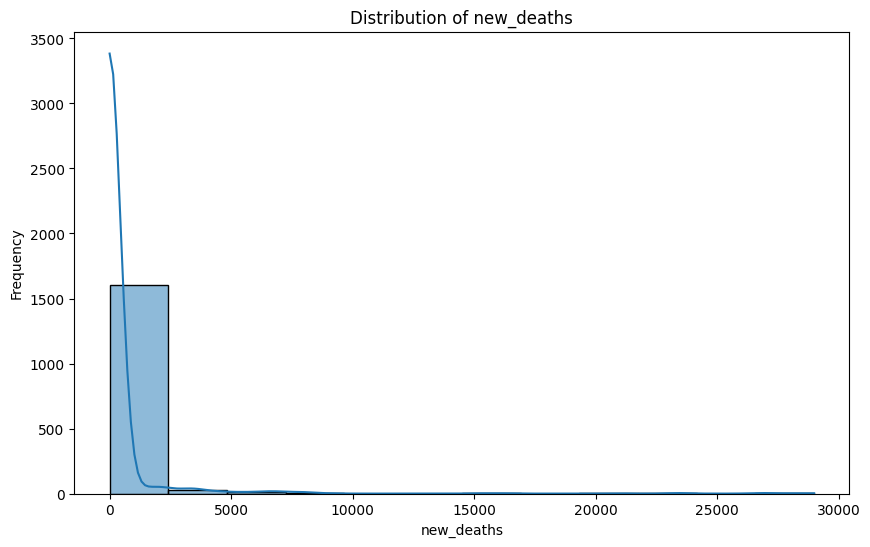

In [ ]:
# Initialize the DataExplorer class with the data
explorer = DataExplorer(original_india_data)

# Perform the analysis
explorer.display_info()
explorer.display_columns_info()
explorer.display_constant_variable_columns()

# Interactive elements
explorer.interactive_data_table()
explorer.interactive_widgets('new_deaths')


---

- The dataset currently has 1679 entries with 67 columns.
- There are 1 date column, 4 categorical columns and 62 numeric columns as follows:

| Date Column     | Categorical Columns           | Numeric Columns 1                    | Numeric Columns 2                     | Numeric Columns 3                    | Numeric Columns 4                  |
|-----------------|-------------------------------|--------------------------------------|---------------------------------------|--------------------------------------|------------------------------------|
| 1. `'date'`     | 1. `'iso_code'`               | 1. `'total_cases'`                   | 17. `'weekly_hosp_admissions_per_million'` | 33. `'total_vaccinations_per_hundred'`  | 49. `'aged_65_older'`              |
|                 | 2. `'continent'`              | 2. `'new_cases'`                     | 18. `'total_tests'`                   | 34. `'people_vaccinated_per_hundred'`   | 50. `'aged_70_older'`              |
|                 | 3. `'location'`               | 3. `'new_cases_smoothed'`            | 19. `'new_tests'`                     | 35. `'people_fully_vaccinated_per_hundred'`| 51. `'gdp_per_capita'`              |
|                 | 4. `'tests_units'`            | 4. `'total_deaths'`                  | 20. `'total_tests_per_thousand'`      | 36. `'total_boosters_per_hundred'`       | 52. `'extreme_poverty'`            |
|                 |                               | 5. `'new_deaths'`                    | 21. `'new_tests_per_thousand'`        | 37. `'new_vaccinations_smoothed_per_million'`| 53. `'cardiovasc_death_rate'`       |
|                 |                               | 6. `'new_deaths_smoothed'`           | 22. `'new_tests_smoothed'`            | 38. `'new_people_vaccinated_smoothed'`    | 54. `'diabetes_prevalence'`        |
|                 |                               | 7. `'total_cases_per_million'`       | 23. `'new_tests_smoothed_per_thousand'` | 39. `'new_people_vaccinated_smoothed_per_hundred'`| 55. `'female_smokers'`         |
|                 |                               | 8. `'new_cases_per_million'`         | 24. `'positive_rate'`                 | 40. `'stringency_index'`                 | 56. `'male_smokers'`               |
|                 |                               | 9. `'new_cases_smoothed_per_million'`| 25. `'tests_per_case'`                | 41. `'population_density'`              | 57. `'handwashing_facilities'`     |
|                 |                               | 10. `'total_deaths_per_million'`     | 26. `'total_vaccinations'`            | 42. `'median_age'`                      | 58. `'hospital_beds_per_thousand'` |
|                 |                               | 11. `'new_deaths_per_million'`       | 27. `'people_vaccinated'`             | 43. `'population'`                      | 59. `'life_expectancy'`            |
|                 |                               | 12. `'new_deaths_smoothed_per_million'`| 28. `'people_fully_vaccinated'`      | 44. `'excess_mortality_cumulative_absolute'`| 60. `'human_development_index'` |
|                 |                               | 13. `'reproduction_rate'`            | 29. `'total_boosters'`                | 45. `'excess_mortality_cumulative'`     | 61. `'excess_mortality_cumulative_per_million'`|
|                 |                               | 14. `'icu_patients'`                 | 30. `'new_vaccinations'`              | 46. `'excess_mortality'`                | 62. `'excess_mortality'`            |
|                 |                               | 15. `'icu_patients_per_million'`     | 31. `'new_vaccinations_smoothed'`     | 47. `'new_deaths_per_million'`          |                                    |
|                 |                               | 16. `'hosp_patients'`                | 32. `'total_vaccinations_per_hundred'`| 48. `'reproduction_rate'`               |                                    |

---

Thorough exploration of the dataset provides a comprehensive understanding of its structure, content, and relationships among variables. This step is crucial for identifying preprocessing needs, uncovering data patterns, and preparing for effective modeling. For instance, upon examining the distribution of the target variable, we discover that most values are zero. This imbalance could pose challenges for model accuracy. Therefore, further investigation into the target variable is necessary to identify any underlying patterns or issues. Based on these insights, we can implement appropriate preprocessing techniques to address potential problems and enhance the performance of our predictive models for forecasting new COVID-19 deaths.


---

##### **Filter irrelevant columns**
Apart from the date column, we identified 31 irrelevant columns including 4 categorical, 12 empty, and 15 constant numeric. These columns are set aside to preserve the dataset's originality. The details of all these columns are presented in the following table.

| Categorical columns    | Empty Columns    | Constant Numeric Columns    |
|----------------------|----------------|-------------------|
| 1. `iso_code`          | 1. `icu_patients`                            | 1. `population_density`       |
| 2. `continent`         | 2. `hosp_patients`                           | 2. `median_age`               |
| 3. `location`          | 3. `hosp_patients_per_million`               | 3. `aged_65_older`            |
| 4. `tests_unit`        | 4. `icu_patients_per_million`                | 4. `aged_70_older`            |
|                        | 5. `weekly_icu_admissions`                   | 5. `gdp_per_capita`           |
|                        | 6. `weekly_icu_admissions_per_million`       | 6. `extreme_poverty`          |
|                        | 7. `weekly_hosp_admissions`                  | 7. `cadiovasc_death_rate`     |
|                        | 8. `weekly_hosp_admissions_per_million`      | 8. `diabetes_prevalence`      |
|                        | 9. `excess_mortality_cumulative_absolute`    | 9. `female_smokers`           |
|                        | 10. `excess_mortality_cumulative`            | 10. `male_smokers`            |
|                        | 11. `excess_mortality`                       | 11. `handwashing_facilities`  |
|                        | 12. `excess_mortality_cumulative_per_million`| 12. `hospital_beds_per_thousand` |
|                        |                                              | 13. `life_expectancy`         |
|                        |                                              | 14. `human_development_index` |
|                        |                                              | 15. `population`              |


##### **Extract Numeric variable columns**

In our analysis, we have extracted 35 essential numeric variable columns. These columns are crucial for our analysis, providing valuable insights and significantly contributing to our results. The columns are listed as follows:

|         |         |   Numeric Variable Columns   |        |         |        |       |
|---------|---------|-----|-----------------------|---------|--------|-------|
| 1. `total_cases`         | 6. `new_deaths_smoothed` | 11. `new_deaths_per_million` | 16. `total_tests_per_thousand` | 21. `tests_per_case` | 26. `new_vaccinations` | 31. `total_boosters_per_hundred` |
| 2. `new_cases` | 7. `total_cases_per_million` | 12. `new_deaths_smoothed__per_million` | 17. `new_tests_per_thousand` | 22. `total_vaccinations` | 27. `new_vaccinations_smoothed` | 32. `new_vaccinations_smoothed_per_million` |
| 3. `new_cases_smoothed` | 8. `new_cases_per_million` | 13. `reproduction_rate` | 18. `new_tests_smoothed` | 23. `people_vaccinated` | 28. `total_vaccinations_per_hundred` | 33. `new_people_vaccinated_smoothed` |
| 4. `total_deaths` | 9. `new_cases_smoothed_per_million` | 14. `total_tests` | 19. `new_tests_smoothed_per_thousand` | 24. `people_fully_vaccinated` | 29. `people_vaccinated_per_hundred` | 34. `new_people_vaccinated_smoothed_per_hundred` |
| 5. `new_deaths` | 10. `total_deaths_per_million` | 15. `new_tests` | 20. `positive_rate` | 25. `total_boosters` | 30. `people_fully_vaccinated_per_hundred` | 35. `stringency_index` |




<div class="alert alert-info">

---

## **Data Preprocessing**

This section outlines two different preprocessing approaches (with some common steps) to process the same original extracted India data.

- **Standard Approach:** This approach represents the conventional preprocessing pipeline.

- **Custom Approach:** This approach represents a pipeline customized to preprocess the covid dataset.

---

</div>

### **Common Steps**

**1. Select Numeric Columns:** Identify and select numeric columns from the dataset, which will be used for further analysis and modeling.

**2. Detect and Process Missing Values:** Detect missing values and process them using linear interpolation followed by zero imputation.

**3. Iterative Feature Selection:** Refine features iteratively using correlation filtering, Permutation Feature Importance (PFI), Mutual Information (MI), Single Feature Impact (SFI), and Variance Inflation Factor (VIF) to identify the optimal subset of features that significantly contribute to predicting COVID-19 new deaths in India.

**4. Normalize and Scale the Data:** Normalize numerical features to a common scale using sklearn's StandardScalar to ensure all features contribute equally to the model and to improve convergence during training.

**5. Define Regression Models:** The primary goal of machine learning is to predict target variables based on the explanatory variables (or features).


**6. Define Cross Validation and Hyperparameter Space:** Using cross-validation techniques, we systematically tune the hyperparameters of each model to optimize its predictive performance. Hyperparameter tuning helps in finding the best configuration for each model, balancing bias and variance to achieve optimal accuracy on unseen data.

**7. Plot the Learning Curve:** A learning curve is a graphical representation that illustrates the performance of a machine learning model as a function of the training set size or training iterations. It is an essential tool for diagnosing overfitting and underfitting in predictive models.

**8. Evaluate the Model:** Assess the performance of the model using appropriate metrics to ensure it meets the desired criteria for accuracy and reliability.

---


#### **Select Numeric Columns**

The `NumericColumnSelector` class is a custom scikit-learn transformer designed to automatically select numeric columns from a given DataFrame. This is particularly useful in preprocessing pipelines where only numeric features should be passed to subsequent transformations or models. The class inherits from BaseEstimator and TransformerMixin, allowing it to be seamlessly integrated into scikit-learn pipelines.

In [ ]:
# NumericColumnSelector class

class NumericColumnSelector(BaseEstimator, TransformerMixin):
    """
    A custom transformer that selects numeric columns from a DataFrame.

    This transformer identifies and retains only the numeric columns from the input DataFrame,
    which can be particularly useful when building preprocessing pipelines that require numeric data.
    """

    def __init__(self):
        """
        Initializes the NumericColumnSelector.

        Attributes:
        ----------
        numeric_columns : list or None
            Stores the names of the numeric columns identified during the fit process.
        """
        self.numeric_columns = None

    def fit(self, X, y=None):
        """
        Identifies numeric columns in the DataFrame.

        Parameters:
        ----------
        X : pandas DataFrame
            The input data to be used for identifying numeric columns.
        y : None or pandas Series, optional
            Ignored, as this transformer does not require target labels.

        Returns:
        -------
        self : object
            Returns the instance itself.
        """
        # Identify and store the names of numeric columns
        self.numeric_columns = X.select_dtypes(include=[np.number]).columns
        return self

    def transform(self, X):
        """
        Selects and returns only the numeric columns from the DataFrame.

        Parameters:
        ----------
        X : pandas DataFrame
            The input data from which numeric columns are to be selected.

        Returns:
        -------
        X_numeric : pandas DataFrame
            A DataFrame containing only the numeric columns.

        Additional Effects:
        -------------------
        Prints the number of numeric columns identified.
        """
        # Print the number of numeric columns found
        print(f"Number of numeric columns: {len(self.numeric_columns)}")

        # Return a DataFrame containing only the numeric columns
        return X[self.numeric_columns]


When the `NumericColumnSelector` class is used within a scikit-learn pipeline or standalone, it identifies all numeric columns in the input DataFrame during the fit stage and then retains only these columns during the transform stage. This ensures that subsequent steps in the pipeline receive only numeric data. The print statement within the transform method provides immediate feedback on the number of numeric columns selected, which can be useful for debugging or data inspection purposes.

#### **Detect and Process Missing values**

The `NaNProcessor` class is a custom scikit-learn transformer designed to handle missing values (NaNs) in a dataset. The transformer first attempts to fill missing values using linear interpolation for each column. If a column contains only NaN values or if any NaNs remain after interpolation, these are filled with zero. This ensures that all missing data is handled, making the dataset suitable for models that cannot handle NaNs.

In [ ]:
# NaNProcessor class

class NaNProcessor(BaseEstimator, TransformerMixin):
    """
    A transformer for processing missing values in a dataset.

    This transformer fills missing values in the specified columns (or all columns if none are specified)
    by using linear interpolation where possible, followed by filling any remaining NaNs with zero.

    Attributes:
    -----------
    columns : list or None
        The list of columns to be processed. If None, all columns are processed.
    """

    def __init__(self, columns=None):
        """
        Initializes the NaNProcessor.

        Parameters:
        -----------
        columns : list or None, optional
            The columns to process for missing values. If None, all columns will be processed.
        """
        self.columns = columns

    def fit(self, X, y=None):
        """
        Fits the transformer to the data.

        This method doesn't need to learn anything from the data, so it simply returns the instance.

        Parameters:
        -----------
        X : pandas DataFrame
            The input data.
        y : None or pandas Series, optional
            Ignored, as this transformer does not require target labels.

        Returns:
        -------
        self : object
            Returns the instance itself.
        """
        return self

    def transform(self, X, y=None):
        """
        Transforms the data by handling missing values.

        This method processes each specified column (or all columns) by first applying linear interpolation
        to fill missing values. If a column has no non-NaN values or if any NaNs remain after interpolation,
        these are filled with zero.

        Parameters:
        -----------
        X : pandas DataFrame
            The input data to transform.
        y : None or pandas Series, optional
            Ignored, as this transformer does not require target labels.

        Returns:
        -------
        X_copy : pandas DataFrame
            The DataFrame with missing values processed.
        """
        # Create a copy of the DataFrame to avoid altering the original data
        X_copy = X.copy()

        # If no specific columns are provided, process all columns
        if self.columns is None:
            self.columns = X_copy.columns

        # Iterate over each specified column
        for col in self.columns:
            if X_copy[col].notna().any():  # Check if there's at least one non-NaN value
                # Apply linear interpolation to fill missing values
                X_copy[col] = X_copy[col].interpolate(method='linear')
            # Fill any remaining NaNs with zero
            X_copy[col] = X_copy[col].fillna(0)

        return X_copy

When the `NaNProcessor` class is applied to a DataFrame, it ensures that all missing values are addressed in a methodical way. Linear interpolation is attempted first, which estimates missing values based on existing data points in the column. If interpolation is not possible or does not fill all missing values, the remaining NaNs are replaced with zero. This approach is particularly useful in preparing data for machine learning models that cannot handle missing values, thereby improving data integrity and model performance.

---

#### **Iterative Feature Selector**

**Objective:** Implement a robust and systematic iterative feature selection process that combines multiple filtering and regularization techniques to identify an optimal subset of features for predictive modeling. This method ensures that selected features are both predictive and free from multicollinearity, thereby enhancing model performance, interpretability, and generalizability.

**Implementation Steps:**

**(i) Correlation Filtering:**

- **Purpose:** Initiate the selection process by eliminating features that are redundant or irrelevant based on their correlation with the target variable.
- **Details:**
  - Compute the correlation between each feature and the target variable.
  - Remove features with high absolute correlation (greater than a specified threshold) to avoid redundancy.
  - Drop features with `NaN` correlations (indicative of empty columns) and those with zero correlation (indicative of constant columns).

**(ii) Single Feature Impact:**

- **Purpose:** Assess the direct impact of individual features on model performance, ensuring that each feature contributes significantly to the predictive power.
- **Details:**
  - Evaluate the performance of the model using each feature independently.
  - Features that do not contribute meaningfully when used alone are flagged for potential removal.

**(iii) Permutation Importance:**

- **Purpose:** Evaluate the predictive contribution of each feature using permutation importance to prioritize features with high predictive power.
- **Details:**
  - Use a `RandomForestRegressor` model to compute permutation importance for each feature.
  - Identify and flag features with low or negative permutation importance, as they may contribute little to model performance.

**(iv) Mutual Information Importance:**

- **Purpose:** Capture nonlinear dependencies between features and the target variable using mutual information to ensure that important nonlinear relationships are considered.
- **Details:**
  - Calculate mutual information scores for each feature with respect to the target.
  - Features with low mutual information are potential candidates for removal, as they may have limited predictive value.

**(v) VIF Computation:**

- **Purpose:** Detect and address multicollinearity among features by calculating the Variance Inflation Factor (VIF), ensuring that the feature set remains stable and interpretable.
- **Details:**
  - Compute the VIF for each feature to identify multicollinearity.
  - Iteratively remove features with high VIF values (exceeding a specified threshold) to reduce redundancy and improve model stability.

**(vi) Feature Importance Table:**

- **Purpose:** Generate a comprehensive table summarizing permutation importance, mutual information, single feature impact, and VIF values, enabling informed decision-making in the feature selection process.
- **Details:**
  - Compile a table that ranks features based on their permutation importance, mutual information, single feature impact, and VIF values.
  - Use this table to guide the iterative removal of features:
    - Drop features with zero or negative permutation importance.
    - Remove features identified as constant columns (zero VIF) or empty columns (`NaN` VIF).
    - Consider removing features with the lowest combined importance and high VIF.

**(vii) Refinement with Regularization:**

- **Purpose:** Further refine the feature set using regularization techniques to penalize and remove irrelevant or redundant features, leading to a more parsimonious model.
- **Details:**
  - Apply Lasso or Ridge regression to perform regularization-based feature selection.
  - Retain only those features with non-zero coefficients, allowing the model to focus on the most impactful features.

**(viii) Iterative Feature Dropping and Stability:**

- **Purpose:** Continuously refine the feature set by iteratively dropping features until no features exceed the VIF threshold and the set stabilizes.
- **Details:**
  - The iterative process involves updating the feature set by removing features based on the combined filtering criteria until stability is achieved.
  - Stability is defined when all remaining features have VIF values below the specified threshold, ensuring that the final feature set is optimal.

**(ix) Final Feature Selection:**

- **Purpose:** Conclude the iterative process by selecting a refined set of features that offer the best trade-off between predictive accuracy and multicollinearity.
- **Details:**
  - The final feature set is determined after all filtering, regularization, and iterative refinement steps have been applied.
  - This set represents the features that are most predictive, have the lowest multicollinearity, and contribute significantly to the model's performance.

---

In [ ]:
# IterativeFeatureSelector class

class IterativeFeatureSelector(BaseEstimator, TransformerMixin):
    """
    IterativeFeatureSelector performs feature selection by iteratively applying correlation filtering,
    feature importance evaluation, and variance inflation factor (VIF) computation. It refines feature sets
    using regularization and combines various importance metrics to select the most relevant features.
    """

    def __init__(self, approach, target_column, correlation_threshold=0.8, vif_threshold=10,
                 alpha=1.0, n_repeats=5, cv=None, n_jobs=-1, random_state=42):
        """
        Initializes the IterativeFeatureSelector with given parameters.

        Parameters
        ----------
        approach : str
            The approach used for feature selection.
        target_column : str
            The name of the target column in the dataset.
        correlation_threshold : float, optional (default=0.8)
            Threshold for feature correlation with the target to consider for removal.
        vif_threshold : float, optional (default=10)
            Threshold for variance inflation factor above which features will be considered for removal.
        alpha : float, optional (default=1.0)
            Regularization strength for Lasso/Ridge regression. If None, Ridge is used.
        n_repeats : int, optional (default=5)
            Number of times to repeat permutation importance computation.
        cv : cross-validation generator or an iterable, optional (default=None)
            Determines the cross-validation splitting strategy.
        n_jobs : int, optional (default=-1)
            Number of jobs to run in parallel.
        random_state : int, optional (default=42)
            Seed for the random number generator.
        """
        self.approach = approach
        self.target_column = target_column
        self.correlation_threshold = correlation_threshold
        self.vif_threshold = vif_threshold
        self.alpha = alpha
        self.n_repeats = n_repeats
        self.cv = cv if cv is not None else KFold(n_splits=5)
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.estimator = RandomForestRegressor(random_state=self.random_state)

    def fit(self, X, y):
        """
        Fits the IterativeFeatureSelector to the data by performing feature selection through iterative
        correlation filtering, importance evaluation, and regularization.

        Parameters
        ----------
        X : pandas.DataFrame
            The input feature data.
        y : pandas.Series
            The target variable.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        X_copy = X.copy()
        print(f"\nInitial number of features before iterative feature selection: {X_copy.shape[1]}")

        # Step 1: Correlation Filtering
        X_copy = self._apply_correlation_filter(X_copy, y)

        iteration = 0
        start_time = time.time()

        while True:
            # Step 2: Compute Importances
            single_feature_impact = self._single_feature_impact(X_copy, y)
            perm_importances = self._permutation_importance(X_copy, y)
            mi_importances = self._mutual_info_importance(X_copy, y)
            combined_importance = self._compute_combined_importance(single_feature_impact, perm_importances, mi_importances)

            # Step 3: Compute VIF and Update Feature Selection
            vif = self._compute_vif(X_copy)
            feature_importance_table = self._create_feature_importance_table(X_copy.columns, perm_importances, single_feature_impact, mi_importances, combined_importance, vif, iteration)

            print(f"\nFeature Importance Table after Round: {iteration}")
            print(feature_importance_table)
            # Save the feature importance table to a CSV file
            save_file(feature_importance_table, f'{self.approach}/tables/feature_importance/feature_importance_table_round_{iteration}.csv')

            # Drop features with least combined importance and VIF > threshold
            features_to_drop = self._get_features_to_drop(feature_importance_table)
            if features_to_drop:
                X_copy = self._drop_features(X_copy, features_to_drop, "due to lowest combined importance and vif > 10")

            # Apply regularization to refine features
            X_copy = self._refine_features_with_regularization(X_copy, y)

            # Break if no features have VIF > threshold
            if vif.max() <= self.vif_threshold:
                break

            iteration += 1

        end_time = time.time()
        print(f"Total number of iterations: {iteration}")
        print(f"Time taken for feature selection: {end_time - start_time:.2f} seconds")

        self.features_ = X_copy.columns.tolist()
        print(f"Final selected features: {self.features_}")
        print(f"Number of selected features: {len(self.features_)}")

        return self

    def transform(self, X):
        """
        Transforms the data using the selected features.

        Parameters
        ----------
        X : pandas.DataFrame
            The input feature data.

        Returns
        -------
        X_transformed : pandas.DataFrame
            The transformed feature data with only the selected features.
        """
        X_transformed = X[self.features_]
        return X_transformed

    def _apply_correlation_filter(self, X, y):
        """
        Apply correlation filtering to remove features that are either empty, constant, or highly correlated with the target variable.

        Parameters
        ----------
        X : pandas.DataFrame
            The input feature data to filter.
        y : pandas.Series
            The target variable.

        Returns
        -------
        X_copy : pandas.DataFrame
            The filtered feature data with empty, constant, and highly correlated features removed.
        """
        X_copy = X.copy()
        # Compute the correlation between each feature and the target variable
        correlations = X_copy.apply(lambda col: col.corr(y))
        # Save the correlation values for reference
        corr_df = pd.DataFrame({'feature': X_copy.columns, 'correlation_with_target': correlations})
        save_file(corr_df, f'{self.approach}/tables/feature_correlation_with_target.csv')

        # Identify features with NaN correlation (empty columns)
        nan_corr_features = corr_df[corr_df['correlation_with_target'].isna()]['feature'].tolist()
        # Identify features with zero correlation (constant columns)
        zero_corr_features = corr_df[corr_df['correlation_with_target'] == 0]['feature'].tolist()
        # Identify features with high correlation
        high_corr_features = corr_df[abs(corr_df['correlation_with_target']) > self.correlation_threshold]['feature'].tolist()

        # Remove features identified due to NaN correlation
        if nan_corr_features:
            X_copy = self._drop_features(X_copy, nan_corr_features, "due to NaN correlation (empty columns)")

        # Remove features identified due to zero correlation
        if zero_corr_features:
            X_copy = self._drop_features(X_copy, zero_corr_features, "due to zero correlation (constant columns)")

        # Remove features identified due to high correlation
        if high_corr_features:
            X_copy = self._drop_features(X_copy, high_corr_features, f"due to high correlation with target (> {self.correlation_threshold})")

        return X_copy


    def _permutation_importance(self, X, y):
        """
        Compute permutation importance of features using a RandomForestRegressor.

        Parameters
        ----------
        X : pandas.DataFrame
            The input feature data.
        y : pandas.Series
            The target variable.

        Returns
        -------
        pd.Series
            A Series of permutation importances for each feature.
        """
        self.estimator.fit(X, y)
        importances = permutation_importance(self.estimator, X, y, n_repeats=self.n_repeats, random_state=self.random_state)
        return pd.Series(importances.importances_mean, index=X.columns)

    def _mutual_info_importance(self, X, y):
        """
        Compute mutual information importance of features.

        Parameters
        ----------
        X : pandas.DataFrame
            The input feature data.
        y : pandas.Series
            The target variable.

        Returns
        -------
        pd.Series
            A Series of mutual information importances for each feature.
        """
        return pd.Series(mutual_info_regression(X, y), index=X.columns)

    def _compute_vif(self, X):
        """
        Compute Variance Inflation Factor (VIF) for each feature to detect multicollinearity.

        Parameters
        ----------
        X : pandas.DataFrame
            The input feature data.

        Returns
        -------
        pd.Series
            A Series of VIF values for each feature.
        """
        vif = pd.DataFrame()
        vif['features'] = X.columns
        vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        return vif.set_index('features')['vif']

    def _compute_combined_importance(self, single_feature_impact, perm_importances, mi_importances):
        """
        Compute combined importance by averaging single feature impact, permutation importance, and mutual information.

        Parameters
        ----------
        single_feature_impact : pd.Series
            Series containing single feature impact importances.
        perm_importances : pd.Series
            Series containing permutation importances.
        mi_importances : pd.Series
            Series containing mutual information importances.

        Returns
        -------
        pd.Series
            A Series of combined importances for each feature.
        """
        return (single_feature_impact + perm_importances + mi_importances) / 3

    def _single_feature_impact(self, X, y):
        """
        Compute single feature impact on the target by fitting a model to each feature individually.

        Parameters
        ----------
        X : pandas.DataFrame
            The input feature data.
        y : pandas.Series
            The target variable.

        Returns
        -------
        pd.Series
            A Series of single feature impact importances for each feature.
        """
        single_feature_impact = {}
        for feature in X.columns:
            self.estimator.fit(X[[feature]], y)
            single_feature_impact[feature] = self.estimator.score(X[[feature]], y)
        return pd.Series(single_feature_impact)

    def _create_feature_importance_table(self, feature_names, perm_importances, single_feature_impact, mi_importances, combined_importance, vif, iteration):
        """
        Create a DataFrame to store and display feature importances, VIF values, and selected features.

        Parameters
        ----------
        feature_names : list
            List of feature names.
        perm_importances : pd.Series
            Series containing permutation importances.
        single_feature_impact : pd.Series
            Series containing single feature impact importances.
        mi_importances : pd.Series
            Series containing mutual information importances.
        combined_importance : pd.Series
            Series containing combined importances.
        vif : pd.Series
            Series containing VIF values.
        iteration : int
            The current iteration number.

        Returns
        -------
        pd.DataFrame
            A DataFrame containing the feature importance values, VIF values, and other relevant data.
        """
        return pd.DataFrame({
            'feature': feature_names,
            'permutation_importance': perm_importances,
            'single_feature_impact': single_feature_impact,
            'mutual_information_importance': mi_importances,
            'combined_importance': combined_importance,
            'vif': vif
        }).sort_values(by=['combined_importance'], ascending=False).reset_index(drop=True)

    def _get_features_to_drop(self, feature_importance_table):
        """
        Identify features to drop based on the lowest combined importance and VIF greater than the threshold.

        Parameters
        ----------
        feature_importance_table : pd.DataFrame
            The DataFrame containing feature importances and VIF values.

        Returns
        -------
        list
            A list of feature names to be dropped.
        """
        to_drop = feature_importance_table[feature_importance_table['vif'] > self.vif_threshold]
        if not to_drop.empty:
            return to_drop.sort_values(by='combined_importance').iloc[0]['feature']
        return []

    def _refine_features_with_regularization(self, X, y):
        """
        Apply regularization using Lasso or Ridge to refine the feature set.

        Parameters
        ----------
        X : pandas.DataFrame
            The input feature data.
        y : pandas.Series
            The target variable.

        Returns
        -------
        X_refined : pandas.DataFrame
            The refined feature data with irrelevant features dropped.
        """
        if self.alpha is not None:  # Use Lasso for feature selection
            model = Lasso(alpha=self.alpha, random_state=self.random_state)
        else:  # Use Ridge for feature selection
            model = Ridge(alpha=1.0, random_state=self.random_state)

        model.fit(X, y)
        selected_features = X.columns[model.coef_ != 0].tolist()
        dropped_features = X.columns[model.coef_ == 0].tolist()

        if dropped_features:
            print(f"\nFeatures dropped by regularization: {dropped_features}")

        return X[selected_features]

    def _drop_features(self, X, features_to_drop, reason):
        """
        Drop the specified features from the input data and print a message indicating the reason.

        Parameters
        ----------
        X : pandas.DataFrame
            The input feature data.
        features_to_drop : list
            List of feature names to be dropped.
        reason : str
            The reason for dropping the features.

        Returns
        -------
        X_reduced : pandas.DataFrame
            The input data with the specified features dropped.
        """
        print(f"\nDropping features {features_to_drop} {reason}.")
        return X.drop(columns=features_to_drop)




---

##### **Discussion and Considerations**

The iterative feature selection process implemented in this class is a powerful tool for optimizing the feature set used in predictive modeling. By combining various techniques—correlation filtering, permutation importance, mutual information, VIF analysis, and regularization—the process ensures that the final set of features is both highly predictive and free from problematic multicollinearity.

**Key Considerations:**

1. **Interpreting Feature Importance:**
   - The importance metrics (permutation importance, mutual information, VIF) offer different perspectives on the relevance of each feature. It is crucial to consider these metrics collectively rather than relying on a single criterion.
   - Features with low permutation or mutual information might still be valuable if they contribute to the reduction of multicollinearity, as indicated by VIF.

2. **Handling Multicollinearity:**
   - The iterative nature of VIF-based feature dropping ensures that multicollinearity is addressed progressively. This approach is particularly beneficial in datasets where multicollinearity is not immediately apparent.
   - While high VIF values suggest multicollinearity, it is essential to consider the context. In some cases, a feature with a high VIF might still be retained if it provides significant predictive power and cannot be easily replaced by other features.

3. **Regularization:**
   - Regularization techniques like Lasso or Ridge regression are incorporated to penalize less important features, leading to a more parsimonious model. These techniques are especially useful in high-dimensional datasets where feature selection is challenging.
   - Regularization serves as a final filter to eliminate features that may have passed previous steps but still do not contribute meaningfully to the model.

4. **Iterative Process and Stability:**
   - The process is designed to be iterative, ensuring that feature selection continues until stability is achieved. Stability is defined as the point where no features have VIF values exceeding the specified threshold, and the feature set no longer changes.
   - This iterative approach prevents premature stopping and ensures that the final model is robust, with an optimal balance between complexity and performance.

5. **Use Cases and Applications:**
   - This feature selection process is particularly useful in scenarios where the dataset has a large number of features, and the relationships between features and the target variable are complex (e.g., financial modeling, biomedical research).
   - The process is also well-suited for models where interpretability is crucial. By ensuring that the selected features are both predictive and free from multicollinearity, the final model is easier to interpret and trust.

**Final Remarks:**

The `IterativeFeatureSelector` class provides a comprehensive and systematic approach to feature selection, integrating multiple methodologies to achieve an optimal feature set. The resulting model is not only more accurate but also more interpretable and stable. This process, when applied correctly, can significantly enhance the performance of predictive models and reduce the risk of overfitting or misinterpretation.

---

#### **Normalize and Scale**

**Objective:** The purpose of the `Normalizer` class is to standardize the features of a dataset, ensuring that each feature has a mean of 0 and a standard deviation of 1. This is a common preprocessing step in machine learning that helps various models perform more effectively.

The `Normalizer` class can be customized to use different scaling methods, though it defaults to using the `StandardScaler`.

**Implementation Steps:**

- **Initialization:**
  - The class is initialized with a default scaler (`StandardScaler`) but can be modified to use other scalers if desired.
  
- **Fit:**
  - The `fit` method calculates the scaling parameters (mean and standard deviation) based on the training data, excluding the target column.

- **Transform:**
  - The `transform` method applies the scaling to the dataset, returning a scaled version of the features while leaving the target column unchanged.

In [ ]:
# Normalizer class

class Normalizer(BaseEstimator, TransformerMixin):
    """
    Custom transformer for normalizing feature data using a specified scaler.

    Attributes
    ----------
    scaler : object
        The scaler object used for normalizing the data. Defaults to StandardScaler.
    columns : list
        The list of column names in the dataset.

    Methods
    -------
    fit(X, y=None)
        Fits the scaler to the feature data.

    transform(X)
        Transforms the feature data using the fitted scaler and returns the normalized dataset.
    """
    def __init__(self, scaler=StandardScaler()):
        self.scaler = scaler
        self.columns = None

    def fit(self, X, y=None):
        """
        Fit the scaler to the feature data.

        Parameters
        ----------
        X : pandas.DataFrame
            The input data to fit the scaler.
        y : None
            Unused parameter, exists for compatibility.

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        self.columns = X.columns

        # Initialize the scaler and fit it to the features
        self.scaler.fit(X)
        return self

    def transform(self, X):
        """
        Transform the feature data using the fitted scaler.

        Parameters
        ----------
        X : pandas.DataFrame
            The input data to be transformed.

        Returns
        -------
        pandas.DataFrame
            The transformed data with normalized features.
        """
        X_copy = X.copy()

        # Apply the scaler to the features
        X_scaled = self.scaler.transform(X)

        # Create a DataFrame with the scaled features
        X_scaled_df = pd.DataFrame(X_scaled, columns=self.columns)

        return X_scaled_df

##### **Discussion**

- **Fit Method:** The `fit` method calculates the necessary scaling factors (mean and standard deviation) from the feature columns, ensuring that when the `transform` method is applied, the data will be appropriately normalized.

- **Transform Method:** The `transform` method then applies these scaling factors to the feature data, resulting in a dataset where all features (except the target) have a mean of 0 and a standard deviation of 1. This normalized dataset is crucial for ensuring that machine learning models perform optimally, as it prevents any single feature from disproportionately influencing the model due to differing scales.

#### **Define Regression Models**

**Model Selection:** For predicting new COVID-19 deaths in India, we evaluate a diverse range of regression models, including both linear and non-linear approaches. The selection encompasses models that leverage various learning techniques to understand and predict the target variable effectively. Each model is tested with both standard and custom preprocessing pipelines to assess the impact on predictive performance.

1. **Linear Models:**
   - **Linear Regression:** Fits a linear relationship between the dependent variable (`Y`) and one or more independent variables (`X`), aiming to minimize the sum of squared errors. It assumes a relationship of the form:
   $$
   Y_i = b_0 + b_1 X_i + u_i
   $$
   where $b_0$ and $b_1$ are the intercept and slope respectively, and $u_i$ represents random errors.

   - **Ridge Regression:** Adds $L_2$ regularization to linear regression to reduce overfitting. The loss function is:
   $$
   L(w) = \sum_{i=1}^{n} \left( y_i - w^T x_i \right)^2 + \lambda \sum_{j=1}^{p} \left( w_j \right)^2
   $$
   where $\lambda$ controls the regularization strength.

   - **Lasso Regression:** Incorporates $L_1$ regularization to perform feature selection by adding a penalty term:
   $$
   L(w) = \sum_{i=1}^{n} \left( y_i - w^T x_i \right)^2 + \lambda \sum_{j=1}^{p} \left| w_j \right|
   $$
   encouraging sparsity in the coefficients.

   - **ElasticNet:** Combines $L_1$ and $L_2$ penalties for regularization:
   $$
   L(w) = \sum_{i=1}^{n} \left( y_i - w^T x_i \right)^2 + \lambda_1 \sum_{j=1}^{p} \left| w_j \right| + \lambda_2 \sum_{j=1}^{p} \left( w_j \right)^2
   $$
   where $\lambda_1$ and $\lambda_2$ control the respective regularization strengths.

2. **Non-Linear Models:**
   - **Support Vector Regressor (SVR):** Uses kernel functions to fit non-linear relationships and find the optimal hyperplane for predictions.

   - **Random Forest Regressor (RFR):** An ensemble method combining multiple decision trees to improve prediction accuracy and robustness through averaging.

   - **Gradient Boosting Regressor (GBR):** Builds a series of weak learners, often decision trees, where each model corrects the errors of the previous ones, enhancing prediction accuracy.

   - **Decision Tree Regressor (DTR):** Uses a tree structure for predictions, with nodes representing features and branches representing decision rules. It can overfit, which is mitigated by pruning and depth constraints.

   - **KNeighbors Regressor (KNR):** Predicts based on the average target values of the \(k\)-nearest neighbors, requiring feature scaling for accurate distance calculations.

   - **Neural Network (MLPRegressor):** A model inspired by the brain’s structure, consisting of layers of neurons that learn to minimize prediction error through backpropagation.

In [ ]:
# Define linear and non-linear regression models

regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'Neural Network': MLPRegressor(random_state=42)
}

---

##### **Discussion**

After defining and implementing a diverse set of regression models, we perform evaluations to understand their performance. The key aspects include:

- **Model Performance:** Each model’s ability to predict new COVID-19 deaths is assessed through various metrics such as Root Mean Squared Error (RMSE) and R-squared (R²). These metrics provide insights into how well the model fits the data and its predictive accuracy.

- **Feature Selection Impact:** We analyze how incorporating iterative feature selection methods affect model performance. Feature selection helps in identifying the most relevant features, potentially enhancing model accuracy and reducing overfitting.

- **Model Comparison:** By comparing models with standard versus custom preprocessing, we determine how preprocessing techniques impact the models' efficacy. This comparison helps in selecting the most appropriate model and preprocessing pipeline for accurate predictions.

This evaluation helps in understanding the strengths and weaknesses of different regression approaches and in selecting the optimal model for predicting COVID-19 mortality rates in India.

#### **Define Cross Validation and Hyperparameter Grid for Model Tuning**

To enhance the performance of our regression models and achieve optimal predictive accuracy, we define a comprehensive hyperparameter grid for each model. Hyperparameter tuning involves systematically exploring different values for model parameters to find the best configuration that improves the model's performance.

**Hyperparameter Space:**

1. **Ridge Regression:**
   - `alpha`: Regularization strength to prevent overfitting.

2. **Lasso Regression:**
   - `alpha`: Regularization strength to prevent overfitting.

3. **ElasticNet:**
   - `alpha`: Regularization strength.
   - `l1_ratio`: Mixing parameter that balances L1 and L2 penalties.

4. **Support Vector Regressor (SVR):**
   - `C`: Regularization parameter.
   - `epsilon`: Epsilon parameter in epsilon-SVR.

5. **Random Forest Regressor:**
   - `n_estimators`: Number of trees in the forest.
   - `max_features`: Number of features to consider at each split.
   - `max_depth`: Maximum depth of the tree.
   - `min_samples_split`: Minimum number of samples required to split an internal node.
   - `min_samples_leaf`: Minimum number of samples required at a leaf node.
   - `bootstrap`: Method of selecting samples for training each tree.

6. **Gradient Boosting Regressor:**
   - `n_estimators`: Number of boosting stages.
   - `learning_rate`: Learning rate to shrink the contribution of each tree.
   - `subsample`: Fraction of samples used for fitting base learners.
   - `max_depth`: Maximum depth of individual base learners.
   - `min_samples_split`: Minimum number of samples required to split a node.
   - `min_samples_leaf`: Minimum number of samples required at each leaf node.
   - `max_features`: Number of features to consider at each split.
   - `validation_fraction`: Fraction of training data to set aside for validation.
   - `n_iter_no_change`: Number of iterations with no improvement to wait before stopping early.
   - `tol`: Tolerance for convergence.

7. **Decision Tree Regressor:**
   - `criterion`: Function to measure the quality of a split.
   - `splitter`: Strategy used to choose the split at each node.
   - `max_depth`: Maximum number of levels in the tree.
   - `min_samples_split`: Minimum number of samples required to split a node.
   - `min_samples_leaf`: Minimum number of samples required at each leaf node.
   - `max_features`: Number of features to consider at each split.
   - `max_leaf_nodes`: Maximum number of leaf nodes in the tree.

8. **KNeighbors Regressor:**
   - `n_neighbors`: Number of neighbors to use.
   - `weights`: Weight function used in prediction.
   - `algorithm`: Algorithm used to compute the nearest neighbors.
   - `leaf_size`: Leaf size for BallTree or KDTree.
   - `p`: Power parameter for the Minkowski metric.

9. **Neural Network (MLPRegressor):**
   - `hidden_layer_sizes`: Number of units in each hidden layer.
   - `activation`: Activation function for the hidden layer.
   - `solver`: Solver for weight optimization.
   - `tol`: Tolerance for convergence.
   - `early_stopping`: Whether to terminate training when validation performance stops improving.

This comprehensive grid allows us to systematically search for the best hyperparameters for each model, improving their predictive capabilities and ensuring robust performance.


In [ ]:
# Define cross-validation
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
"""
Cross-validation setup with 5 folds, shuffling the data before splitting, and a fixed random seed.
"""

# Define hyperparameter space
hyperparameter_space = {
    'Ridge': {
        'alpha': [0.1, 1, 10, 100]  # Regularization strength
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1, 10]  # Regularization strength
    },
    'ElasticNet': {
        'alpha': [0.01, 0.1, 1, 10],  # Regularization strength
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Mixing parameter for L1 and L2 penalty
    },
    'SVR': {
        'C': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],  # Regularization parameter
        'epsilon': [10, 20, 30, 40, 50]  # Epsilon in the epsilon-SVR model
    },
    'Random Forest': {
        'n_estimators': [3, 5, 8, 10],  # Number of trees in the forest
        'max_features': [None],  # Number of features to consider at each split
        'max_depth': [3, 5, 7, 9],  # Maximum depth of the tree
        'min_samples_split': [2, 3, 4, 5],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [2, 3, 4, 5],  # Minimum number of samples required to be at a leaf node
        'bootstrap': [False]  # Method of selecting samples for training each tree
    },
    'Gradient Boosting': {
        'n_estimators': [350, 400, 450, 500],  # Number of boosting stages to be run
        'learning_rate': [0.01],  # Learning rate shrinks the contribution of each tree
        'subsample': [1.0],  # Fraction of samples used for fitting the individual base learners
        'max_depth': [3, 5],  # Maximum depth of the individual base learners
        'min_samples_split': [2],  # Minimum number of samples required to split a node
        'min_samples_leaf': [2],  # Minimum number of samples required at each leaf node
        'max_features': [None],  # Number of features to consider at every split
        'validation_fraction': [0.2],    # Fraction of training data to set aside for validation
        'n_iter_no_change': [10],    # Number of iterations with no improvement to wait before stopping early
        'tol': [1e-3]  # Tolerance for convergence
    },
    'Decision Tree': {
        'criterion': ['squared_error', 'friedman_mse'],  # Function to measure the quality of a split
        'splitter': ['best', 'random'],  # Strategy used to choose the split at each node
        'max_depth': [3, 5, 10, 15, 20, 30],  # Maximum number of levels in tree
        'min_samples_split': [2],  # Minimum number of samples required to split a node
        'min_samples_leaf': [2],  # Minimum number of samples required at each leaf node
        'max_features': [None],  # Number of features to consider at every split
        'max_leaf_nodes': [5, 10, 15, 20, 30, 40]  # Maximum number of leaf nodes in the tree
    },
    'KNeighbors': {
        'n_neighbors': [2, 3, 4, 5, 6],  # Number of neighbors to use by default for kneighbors queries
        'weights': ['uniform'],  # Weight function used in prediction
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
        'leaf_size': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Leaf size passed to BallTree or KDTree
        'p': [1, 2]  # Power parameter for the Minkowski metric
    },
    'Neural Network': {
        'hidden_layer_sizes': [(10,), (20,), (30,), (50,), (100,), (10, 5, 10), (20, 10, 20), (30, 15, 30), (50, 25, 50)],  # Number of units in hidden layers
        'activation': ['relu'],  # Activation function for the hidden layer
        'solver': ['lbfgs'],  # Solver for weight optimization
        'tol': [1e-3],  # Tolerance for convergence
        'early_stopping': [True]  # Terminate training when validation performance stops improving
    }
}

##### **Discussion**
By defining a broad range of hyperparameters for each model, we ensure a robust and comprehensive search for the best model configuration. This process helps in identifying the most effective parameters that can significantly enhance the performance of our regression models.

The cross-validation setup with 5 folds ensures that our models are evaluated on different subsets of the data, providing a reliable estimate of their performance. The extensive hyperparameter grid facilitates fine-tuning, aiming to achieve the best predictive accuracy and model generalization.

With this approach, we are well-equipped to select the optimal model configuration and improve our predictive capabilities for forecasting COVID-19 mortality rates.


---

#### **Plot the Learning Curve**

Learning curves are crucial for diagnosing underfitting and overfitting in predictive models, offering insights into the model’s performance across varying training set sizes. By visualizing the relationship between training and validation errors as the training size increases, we can assess the model’s stability, generalization capability, and the impact of feature selection.

**Implementation Steps:**

- **Learning Curves Generation:**
  - Produce learning curves for models trained with iterative feature selection.
  - Visualize the training and validation RMSE scores against different training set sizes to capture the model's learning progress.
  
- **Overfitting and Underfitting Analysis:**
  - **Underfitting:** Observed when both training and validation RMSE scores converge at a high value, indicating poor model performance.
  - **Overfitting:** Evident when there is a large gap between training and validation RMSE scores, where training RMSE is significantly lower than validation RMSE.

- **Impact of Feature Selection:**
  - Assess how the iterative feature selection process influences the learning curves, potentially reducing overfitting or underfitting by selecting the most relevant features.

- **Results Interpretation:**
  - **Model Stability and Generalization:** Evaluate the stability of the model and its ability to generalize to unseen data based on the trends observed in the learning curves.
  - **Optimal Model Complexity:** Determine the appropriate level of model complexity that balances feature selection and performance metrics (RMSE, R²), ensuring robust predictive power without unnecessary complexity.




In [ ]:
# PLot the Learning Curve

def plot_learning_curve(approach, estimator, X_train, y_train, X_val, y_val, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plots the learning curve for a given estimator.

    Parameters
    ----------
    approach : str
        The name of the approach or strategy being evaluated.
    estimator : estimator object
        The machine learning model to be evaluated.
    X_train : pandas.DataFrame
        The training data features.
    y_train : pandas.Series or pandas.DataFrame
        The target values for training data.
    X_val : pandas.DataFrame
        The validation data features.
    y_val : pandas.Series or pandas.DataFrame
        The target values for validation data.
    cv : int, optional
        The number of cross-validation folds (default is 5).
    n_jobs : int, optional
        The number of parallel jobs to run (default is -1 for using all processors).
    train_sizes : array-like, optional
        Relative or absolute numbers of training examples that will be used to generate the learning curve.

    Returns
    -------
    None
        This function plots the learning curve and saves it as a PDF.
    """
    print(f"Plotting learning curve for {estimator}...")

    # Combine training and validation datasets
    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)

    # Compute learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_combined, y_combined, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error'
    )

    # Convert negative MSE to positive RMSE
    train_scores = -train_scores
    test_scores = -test_scores
    train_scores_mean = np.sqrt(np.mean(train_scores, axis=1))
    train_scores_std = np.sqrt(np.std(train_scores, axis=1))
    test_scores_mean = np.sqrt(np.mean(test_scores, axis=1))
    test_scores_std = np.sqrt(np.std(test_scores, axis=1))

    # Set the figure size
    fig, ax = plt.subplots(figsize=(16, 9))

    # Plot the data
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training RMSE", linewidth=3)
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation RMSE", linewidth=3)

    # Add shaded area for the training and test scores means
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Add legend
    ax.legend(fontsize=28)

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add axis labels
    ax.set_xlabel('Training examples', fontsize=28)
    ax.set_ylabel('RMSE', fontsize=28)

    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=24)

    # Set the layout
    plt.tight_layout()

    # Save the plot
    save_file(fig, f'{approach}/plots/learning_curves/{estimator}.pdf')

    # Display the plot
    plt.show()

---

##### **Discussion**

- **Learning Curve Analysis:** This function plots the learning curve by evaluating the model's performance across different training set sizes. By examining the training and validation RMSE scores, we can diagnose issues such as underfitting or overfitting.

- **Impact of Feature Selection:** The learning curve also highlights the impact of iterative feature selection on the model's ability to generalize, providing insights into whether the model complexity is appropriate for the task.

- **Practical Application:** The results from the learning curves guide decisions on model adjustments, such as adding or removing features, to enhance model stability and performance, ultimately contributing to a more accurate and reliable predictive model.


---

#### **Model Evaluation and Performance Metrics**

**Objective:** The goal is to evaluate the performance of predictive models using two primary metrics: Root Mean Squared Error (RMSE) and R-squared (R²). These metrics provide a comprehensive understanding of a model's accuracy and its ability to explain the variance in the data.

**Metrics Overview:**

- **Root Mean Squared Error (RMSE):** RMSE is the square root of the average squared differences between the observed and predicted values. It gives an indication of the model’s prediction accuracy in the same units as the target variable. A lower RMSE indicates better model performance:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:
- $y_i$ represents the actual values,
- $\hat{y}_i$ represents the predicted values,
- $n$ is the number of observations.

- **R-squared (R²):** The R² metric, also known as the coefficient of determination, measures the proportion of variance in the dependent variable that is predictable from the independent variables. An R² value closer to 1 indicates a better fit:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

Where:
- $\sum (y_i - \hat{y}_i)^2$ is the sum of squared residuals (SSR),
- $\sum (y_i - \bar{y})^2$ is the total sum of squares (TSS),
- $\bar{y}$ is the mean of the observed data.

A higher R² value suggests that a greater proportion of the variability in the target variable is captured by the model, implying better predictive power.

**Implementation: Model Evaluation with Cross-Validation and Hyperparameter Tuning**

The `evaluate_model` function is designed to assess the performance of a model using cross-validation. It also includes an optional hyperparameter tuning step using GridSearchCV to identify the best set of hyperparameters for the model.

- **Hyperparameter Tuning:** If a hyperparameter space is provided, the function performs hyperparameter tuning using GridSearchCV to find the best combination of parameters that minimize the RMSE.
  
- **Model Evaluation:** The function evaluates the model on training, validation, and test sets, calculating RMSE and R² for each. The model's performance is recorded along with other important details like model size and computation time.

---

In [ ]:
# Model Evaluation Function
def evaluate_model(approach, model, X_train, y_train, X_val, y_val, X_test, y_test, model_hyperparameter_space=None, cv=5, n_jobs=-1):
    """
    Evaluates a model's performance using cross-validation and optional hyperparameter tuning.

    Parameters
    ----------
    approach : str
        The name of the approach or strategy being evaluated.
    model : estimator object
        The machine learning model to be evaluated.
    X_train : pandas.DataFrame
        The training data features.
    y_train : pandas.Series or pandas.DataFrame
        The target values for training data.
    X_val : pandas.DataFrame
        The validation data features.
    y_val : pandas.Series or pandas.DataFrame
        The target values for validation data.
    X_test : pandas.DataFrame
        The test data features.
    y_test : pandas.Series or pandas.DataFrame
        The target values for test data.
    model_hyperparameter_space : dict, optional
        The hyperparameter space for GridSearchCV.
    cv : int, optional
        The number of cross-validation folds (default is 5).
    n_jobs : int, optional
        The number of parallel jobs to run (default is -1 for using all processors).

    Returns
    -------
    results_list : list
        A list of dictionaries containing the evaluation results.
    """
    results_list = []

    if model_hyperparameter_space is not None:
        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(
            model,
            model_hyperparameter_space,
            cv=cv,
            scoring='neg_mean_squared_error',
            return_train_score=False,
            n_jobs=n_jobs,
            verbose=5
        )

        print("Starting hyperparameter tuning...")
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        tuning_time = time.time() - start_time

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Save the best model
        model_filename = f"{approach}/models/{model.__class__.__name__}_best_model.pkl"
        save_file(best_model, model_filename)
        model_size = os.path.getsize(model_filename) / 1024  # Size in kB

        # Evaluate the best model using cross-validation
        scores = cross_validate(best_model, X_train, y_train, cv=cv,
                                scoring=('neg_root_mean_squared_error', 'r2'),
                                return_train_score=True, n_jobs=n_jobs)

        # Calculate performance metrics
        train_rmse = -scores['train_neg_root_mean_squared_error'].mean()
        train_r2 = scores['train_r2'].mean()
        val_rmse = -scores['test_neg_root_mean_squared_error'].mean()
        val_r2 = scores['test_r2'].mean()

        # Test the best model on the test set
        start_time_test = time.time()
        y_test_pred = best_model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
        test_time = time.time() - start_time_test

        # Compile results
        results = {
            'Approach': approach,
            'Model Name': model.__class__.__name__,
            'Model Size (kB)': model_size,
            'Best Hyperparameters': best_params,
            'Hyperparameter Tuning Time (s)': tuning_time,
            'Train RMSE': train_rmse,
            'Train R\u00B2': train_r2,
            'Training Time (s)': scores['fit_time'].sum(),
            'Validation RMSE': val_rmse,
            'Validation R\u00B2': val_r2,
            'Validation Time (s)': scores['score_time'].sum(),
            'Test RMSE': test_rmse,
            'Test R\u00B2': test_r2,
            'Test Time (s)': test_time
        }
        results_list.append(results)
    else:
        # Direct model training without hyperparameter tuning
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Save the trained model
        model_filename = f"{approach}/models/{model.__class__.__name__}_best_model.pkl"
        save_file(model, model_filename)
        model_size = os.path.getsize(model_filename) / 1024  # Size in kB

        # Evaluate the model using cross-validation
        scores = cross_validate(model, X_train, y_train, cv=cv,
                                scoring=('neg_root_mean_squared_error', 'r2'),
                                return_train_score=True)

        # Calculate performance metrics
        train_rmse = -scores['train_neg_root_mean_squared_error'].mean()
        train_r2 = scores['train_r2'].mean()
        val_rmse = -scores['test_neg_root_mean_squared_error'].mean()
        val_r2 = scores['test_r2'].mean()

        # Test the model on the test set
        start_time_test = time.time()
        y_test_pred = model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)
        test_time = time.time() - start_time_test

        # Compile results
        results = {
            'Approach': approach,
            'Model Name': model.__class__.__name__,
            'Model Size (kB)': model_size,
            'Best Hyperparameters': '-',  # Not applicable
            'Hyperparameter Tuning Time (s)': '-',  # Not applicable
            'Train RMSE': train_rmse,
            'Train R²': train_r2,
            'Training Time (s)': scores['fit_time'].sum(),
            'Validation RMSE': val_rmse,
            'Validation R²': val_r2,
            'Validation Time (s)': scores['score_time'].sum(),
            'Test RMSE': test_rmse,
            'Test R²': test_r2,
            'Test Time (s)': test_time
        }
        results_list.append(results)

    return results_list

---

##### **Discussion**

- **Hyperparameter Tuning:** When a hyperparameter space is provided, the function tunes the model parameters using GridSearchCV, which identifies the best parameters based on RMSE. The tuned model is then evaluated on training, validation, and test sets.

- **Model Evaluation:** The function calculates RMSE and R² for training, validation, and test datasets, allowing you to compare model performance across different data splits. Additionally, it records the time taken for training and testing, and the size of the trained model.

- **Result Compilation:** The function returns a list of dictionaries containing all relevant performance metrics, making it easy to compare different models and approaches.

#### **Variance Calculation for Model Performance Metrics**

In the evaluation of machine learning models, it is crucial to assess not only the overall performance but also the consistency of this performance across different data subsets, such as training, validation, and test sets. This method, `calculate_variance_table`, computes the variance in Root Mean Squared Error (RMSE) and (R²) across these datasets. By analyzing these variances, we gain insight into the stability and robustness of each model, identifying those that generalize well and perform consistently under varying conditions.


In [ ]:
# Calculate Variance Table

def calculate_variance_table(results_df):
    """
    Calculates the RMSE and R² variances for all models in the results DataFrame.

    Parameters
    ----------
    results_df : pandas.DataFrame
        A DataFrame containing the evaluation results with columns for 'Approach',
        'Model Name', 'Train RMSE', 'Validation RMSE', 'Test RMSE', 'Train R²', 'Validation R²', and 'Test R²'.

    Returns
    -------
    variance_table : pandas.DataFrame
        A DataFrame containing the RMSE and R² variances for each model.
    """
    variance_data = []

    for _, result in results_df.iterrows():
        # Extract relevant metrics
        train_rmse = result['Train RMSE']
        val_rmse = result['Validation RMSE']
        test_rmse = result['Test RMSE']

        train_r2 = result['Train R²']
        val_r2 = result['Validation R²']
        test_r2 = result['Test R²']

        # Calculate means
        mean_rmse = np.mean([train_rmse, val_rmse, test_rmse])
        mean_r2 = np.mean([train_r2, val_r2, test_r2])

        # Calculate RMSE variance
        rmse_variance = (1/3) * ((train_rmse - mean_rmse)**2 +
                                 (val_rmse - mean_rmse)**2 +
                                 (test_rmse - mean_rmse)**2)

        # Calculate R² variance
        r2_variance = (1/3) * ((train_r2 - mean_r2)**2 +
                               (val_r2 - mean_r2)**2 +
                               (test_r2 - mean_r2)**2)

        # Compile results for this model
        variance_result = {
            'Approach': result['Approach'],
            'Model Name': result['Model Name'],
            'RMSE Variance': rmse_variance,
            'R² Variance': r2_variance
        }
        variance_data.append(variance_result)

    # Create a DataFrame to display the variances
    variance_table = pd.DataFrame(variance_data)

    return variance_table


##### **Discussion**

The `calculate_variance_table` method provides a detailed variance analysis for RMSE and R² metrics across different data subsets. Models with lower variance in these metrics are considered more stable and reliable, indicating consistent performance. This analysis is essential for selecting models that not only perform well on average but also exhibit minimal fluctuation in their predictions, thus ensuring better generalization to unseen data. The resulting variance table serves as a critical tool for comparing and contrasting the robustness of different modeling approaches.


<div class="alert alert-info">

---

### **Standard Preprocessing**

A comprehensive preprocessing pipeline ensures that the data is clean, relevant, and prepared for effective model training. The key steps are as follows:

1. **Select Numeric Columns:**
   - Identify and retain columns with numeric data types, as these are essential for most modeling techniques and statistical analyses.

2. **Detect and Process Missing Values:**
   - Handle missing values through techniques such as imputation, interpolation, or extrapolation to maintain data integrity.

3. **Detect and Process Outliers:**
   - Identify and manage outliers that could distort model results using methods like z-scores to ensure data consistency.

4. **Select Features Based on Correlation:**
   - Evaluate and select features that show significant correlation with the target variable, enhancing model performance while reducing dimensionality.

5. **Normalize and Scale Features:**
   - Normalize features to ensure they contribute equally to model training, which can improve convergence and performance.

</div>

---
#### **Detect and Process Global Outliers**

In this section, we define a custom transformer class for processing outliers and outline the preprocessing pipeline used to prepare the dataset. The preprocessing steps include selecting numeric columns, handling missing values, processing outliers, feature selection, and normalization.

We start by defining a custom transformer to handle outliers and then create a comprehensive preprocessing pipeline to ensure that the data is ready for modeling.

---

In [ ]:
# StandardOutlierProcessor class

class StandardOutlierProcessor(BaseEstimator, TransformerMixin):
    """
    Transformer that processes outliers in the dataset.

    This transformer identifies global outliers using Z-scores and processes them by setting them to NaN,
    followed by interpolation and filling remaining NaNs with zero.

    Parameters
    ----------
    threshold : float, default=2
        The Z-score threshold to identify outliers.

    Methods
    -------
    fit(X, y=None)
        Fits the transformer to the data.

    transform(X, y=None)
        Transforms the data by processing outliers.

    detect_and_process_global_outliers(X, columns)
        Detects and processes global outliers for specified columns.

    get_global_outliers_indices(column)
        Returns the indices of detected outliers for a given column.
    """

    def __init__(self, threshold=2):
        """
        Initializes the transformer with a Z-score threshold for outlier detection.

        Parameters
        ----------
        threshold : float, default=2
            The Z-score threshold to identify outliers.
        """
        self.threshold = threshold
        self.columns = []
        self.outliers = {}
        self.bounds = {}
        self.input_data = {}
        self.output_data = {}

    def fit(self, X, y=None):
        """
        Fits the transformer to the data.

        Parameters
        ----------
        X : pandas.DataFrame
            The input data.

        y : None
            Ignored. This parameter is included for compatibility with scikit-learn.

        Returns
        -------
        self : StandardOutlierProcessor
            Returns the instance itself.
        """
        return self

    def transform(self, X, y=None):
        """
        Transforms the data by processing outliers.

        Parameters
        ----------
        X : pandas.DataFrame
            The input data.

        y : None
            Ignored. This parameter is included for compatibility with scikit-learn.

        Returns
        -------
        X_outlier_processed : pandas.DataFrame
            The transformed data with outliers processed.
        """
        X_outlier_processed = X.copy()
        X_outlier_processed, self.outliers, self.bounds = self.detect_and_process_global_outliers(X_outlier_processed, X_outlier_processed.columns)
        return X_outlier_processed

    def detect_and_process_global_outliers(self, X, columns):
        """
        Detects and processes global outliers for specified columns.

        Parameters
        ----------
        X : pandas.DataFrame
            The input data.
        columns : list of str
            The columns to process.

        Returns
        -------
        X_copy : pandas.DataFrame
            The data with outliers processed.
        outliers_dict : dict
            Dictionary with outlier indices for each column.
        bounds_dict : dict
            Dictionary with bounds for each column.
        """
        outliers_dict = {}
        bounds_dict = {}
        X_copy = X.copy()
        for col in columns:
            self.input_data[col] = X[col].copy()  # Store the input data for this column
            global_mean = X_copy[col].mean()
            global_std = X_copy[col].std()
            z_scores = (X_copy[col] - global_mean) / global_std
            outlier_mask = np.abs(z_scores) > self.threshold
            outliers_dict[col] = X_copy.loc[outlier_mask, col].dropna().index.tolist()
            X_copy.loc[outlier_mask, col] = np.nan
            X_copy[col] = X_copy[col].interpolate()
            X_copy[col].fillna(0, inplace=True)

            self.output_data[col] = X_copy[col].copy()  # Store the output data for this column

            upper_bound = global_mean + self.threshold * global_std
            lower_bound = global_mean - self.threshold * global_std
            bounds_dict[col] = (lower_bound, upper_bound)
        self.outliers = outliers_dict
        self.bounds = bounds_dict
        return X_copy, self.outliers, self.bounds

    def get_global_outliers_indices(self, column):
        """
        Returns the indices of detected outliers for a given column.

        Parameters
        ----------
        column : str
            The column name.

        Returns
        -------
        list
            The indices of detected outliers.
        """
        return self.outliers.get(column, [])

    def get_bounds(self, column):
        """
        Returns the bounds for a given column.

        Parameters
        ----------
        column : str
            The column name.

        Returns
        -------
        tuple
            The lower and upper bounds.
        """
        return self.bounds.get(column, (None, None))

    def get_input_data(self, column):
        """
        Returns the input data for a given column.

        Parameters
        ----------
        column : str
            The column name.

        Returns
        -------
        pandas.Series
            The input data for the column.
        """
        return self.input_data.get(column, None)

    def get_output_data(self, column):
        """
        Returns the output data for a given column.

        Parameters
        ----------
        column : str
            The column name.

        Returns
        -------
        pandas.Series
            The output data for the column.
        """
        return self.output_data.get(column, None)

---

##### **Discussion**

With the preprocessing pipeline established, including outlier handling, the dataset is now ready for model training. The `StandardOutlierProcessor` class provides a robust method for identifying and processing outliers, ensuring that the data used for modeling is clean and reliable. The pipeline integrates outlier detection with other preprocessing steps, preparing the data for effective model performance and accurate predictions.

The preprocessing steps and outlier handling are critical in enhancing the quality of the data and improving the overall predictive capabilities of the models.

---

---

#### **Standard Preprocessing Pipeline**

This section outlines the standard preprocessing pipeline used to prepare the dataset. The pipeline includes steps for selecting numeric columns, handling missing values, and processing outliers.

We define a pipeline that integrates these preprocessing steps to ensure the data is clean and well-prepared before applying further transformations or modeling.

---

In [ ]:
# Standard Preprocessing Pipeline setup

standard_preprocessing_pipeline = Pipeline([
    ('numeric_column_selector', NumericColumnSelector()),   # Step 1: Select numeric columns
    ('nan_processor', NaNProcessor()),  # Step 2: Process missing values
    ('standard_outlier_processor', StandardOutlierProcessor()),  # Step 3: Process outliers
])

# Visualize Standard Pipeline
standard_preprocessing_pipeline

Pipeline(steps=[('numeric_column_selector', NumericColumnSelector()),
                ('nan_processor', NaNProcessor()),
                ('standard_outlier_processor', StandardOutlierProcessor())])

##### **Discussion**

The `standard_preprocessing_pipeline` integrates essential preprocessing steps into a single pipeline. This ensures that the data undergoes numeric column selection, missing value imputation, and outlier processing in a systematic manner. Visualizing the pipeline helps confirm its structure and sequence of operations.

By using this pipeline, we standardize the preprocessing process, making it easier to manage and apply consistently across different datasets.

---

---

#### **Processing original data Using Standard Preprocessing Pipeline**

This step involves applying the `standard_preprocessing_pipeline` to the original dataset. This pipeline includes numeric column selection, missing value imputation, and outlier processing. By fitting and transforming the original data through this pipeline, we prepare it for further analysis and modeling.

---

In [ ]:
# Process original data using Standard Preprocessing Pipeline

standard_processed_india_data = standard_preprocessing_pipeline.fit_transform(original_india_data)

Number of numeric columns: 62


---

**Data Processing Results**

The `standard_processed_india_data` contains the transformed version of the original dataset after applying the standard preprocessing pipeline. This processed data is now ready for subsequent steps in the analysis or modeling pipeline, ensuring that it has been appropriately cleaned and prepared.

---

---

#### **Save Standard Processed Data**

After processing the original dataset through the standard preprocessing pipeline, the next step is to save the transformed data. This allows us to persist the cleaned and prepared dataset for future analysis or modeling tasks.

---

In [ ]:
save_file(standard_processed_india_data, 'standard/tables/standard_processed_india_data_after_preprocessing_pipeline.csv')

---

**Data Saved**

The processed dataset has been successfully saved to the specified CSV file. This file now contains the cleaned and preprocessed data, ready for the next stages in the analysis or modeling workflow.

---


#### **Visualizing the impact of Global Outlier Processing**

We visualize global outliers in the 'new_vaccinations' column. It plots the original and processed data, highlights outliers, and marks the acceptable range to illustrate the impact of outlier processing on data distribution.

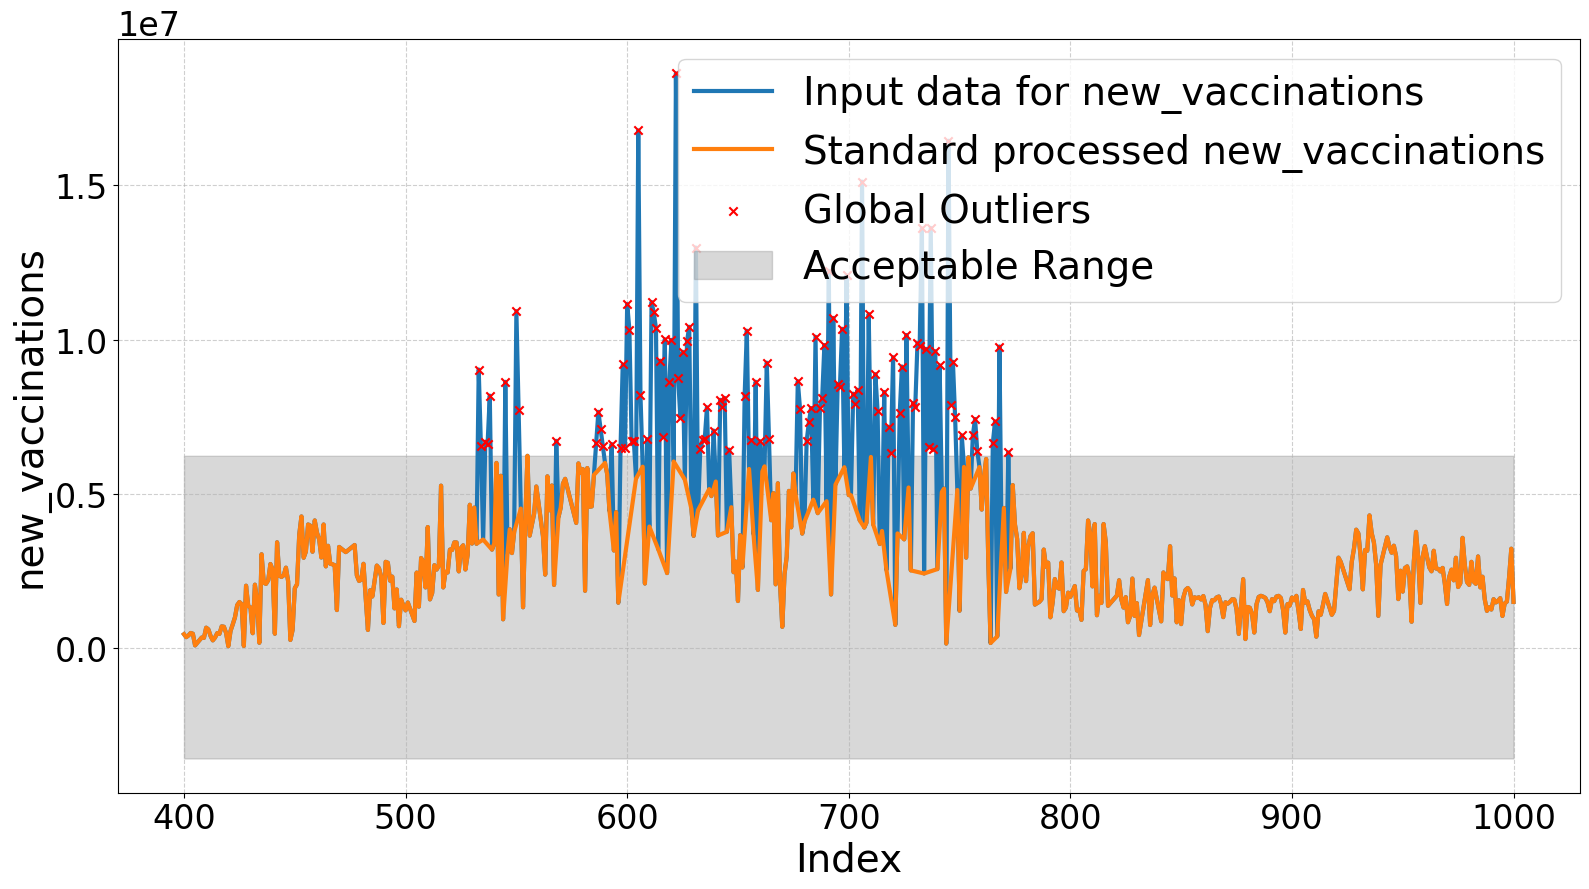

In [ ]:
# Select column for outliers
column = 'new_vaccinations'

# Get the outlier processor from the pipeline
outlier_processor_standard = standard_preprocessing_pipeline.named_steps['standard_outlier_processor']  # StandardOutlierProcessor class

# Retrieve the input and output data for the specified column
input_data_standard = outlier_processor_standard.get_input_data(column)
output_data_standard = outlier_processor_standard.get_output_data(column)

# Get the indices of the global outliers for the column
outlier_indices_standard = outlier_processor_standard.get_global_outliers_indices(column)

# Define the range for filtering outlier indices
left_range = 400
right_range = 1000

# Filter outlier indices to be within the defined range
filtered_outlier_indices_standard = [idx for idx in outlier_indices_standard if left_range <= (idx - input_data_standard.index[0]) <= right_range]

# Retrieve the acceptable range (bounds) for the column
lower_bound_standard, upper_bound_standard = outlier_processor_standard.get_bounds(column)

# Set up the figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 9))

# Plot the input data and processed data
ax.plot(input_data_standard.loc[left_range:right_range], label=f"Input data for {column}", linewidth=3)
ax.plot(output_data_standard.loc[left_range:right_range], label=f"Standard processed {column}", linewidth=3)

# Highlight the global outliers
plt.scatter(filtered_outlier_indices_standard, input_data_standard.loc[filtered_outlier_indices_standard], marker='x', color='red', label='Global Outliers', zorder=5)

# Add shaded area to represent the acceptable range
plt.fill_between(input_data_standard.loc[left_range:right_range].index, lower_bound_standard, upper_bound_standard, color='gray', alpha=0.3, label='Acceptable Range')

# Add legend, grid, and axis labels with customized fonts
ax.legend(fontsize=28)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlabel('Index', fontsize=28)
ax.set_ylabel(f"{column}", fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.yaxis.offsetText.set_fontsize(24)

# Adjust layout and save the plot
plt.tight_layout()
save_file(fig, f"standard/plots/global_outlier_processing_plot_{column}.pdf")

# Display the plot
plt.show()

Clearly, due to setting a constant global threshold ($z\_score = 2$), we loose the local variability a lot. We also miss some local outliers (e.g. around index 520) and this will contribute to the final model performance.

---

---

#### **Extract Features and Labels**

With the preprocessing and feature refinement completed, the next step is to extract the features and labels from the processed data. This involves separating the target variable from the features, which will be used for training and evaluating the machine learning models.

---


In [ ]:
# Extract features and label
# The target column is separated from the features to prepare the dataset for model training and evaluation

X_standard = standard_processed_india_data.drop(target_column, axis=1)  # Features
y_standard = standard_processed_india_data[target_column]  # Target variable


---

**Feature and Label Extraction Complete**

The features and labels have been successfully extracted from the processed data. The dataset is now ready for the next steps in the modeling process, including training and evaluating the machine learning models.

---

<div class="alert alert-info">

---

#### **Data Splitting and Model Training Process**

**Data Splitting:** The dataset is divided into training, validation, and test sets to ensure effective model training and evaluation.

**(i) Training Data:** Used for training the model and conducting feature selection.

**(ii) Validation Data:** Employed for tuning hyperparameters and assessing model performance during training.

**(iii) Test Data:** Reserved for the final evaluation to assess the model's predictive accuracy on unseen data.

#### **Model Training Process**

**(i) Training Final Models:**

- **Model Training:** The final models are trained using features selected from the iterative feature selection process with the full training dataset to maximize learning and generalizability.

- **Data Utilization:** Utilizing the entire training dataset ensures robust training and improves model performance.

**(ii) Validation on Validation Set:**

- **Model Validation:** Evaluates the trained models on the validation set to ensure they generalize well and helps in tuning hyperparameters.

- **Performance Metrics:** Metrics such as RMSE and R-squared are calculated to assess performance and guide further refinement.

**(iii) Testing on Test Set:**

- **Model Testing:** Final evaluation on the test set measures predictive accuracy on completely unseen data.

- **Final Performance Metrics:** Metrics are compared against baseline models to showcase improvements from the feature selection and training process.

By following this structured approach, we ensure comprehensive model validation and reliable predictions for COVID-19 new deaths in India.

---

</div>

In [ ]:
# Step 2: Split the Data into Training, Validation, and Testing Sets
# This step partitions the dataset to ensure proper training, validation, and testing of the models.

X_standard_train, X_standard_temp, y_standard_train, y_standard_temp = train_test_split(
    X_standard, y_standard, test_size=0.4, random_state=42
)
X_standard_val, X_standard_test, y_standard_val, y_standard_test = train_test_split(
    X_standard_temp, y_standard_temp, test_size=0.5, random_state=42
)


---

**Data Splitting Complete**

The dataset has been successfully partitioned into training, validation, and test sets. These sets will now be used for training models, tuning hyperparameters, and evaluating performance. This structured approach ensures robust model development and accurate performance assessment.

---


---
#### **Standard Feature Extraction Pipeline**
##### **Iterative Feature Extraction and Scaling**

After preprocessing the data, the next step is to refine features. This includes selecting relevant features and normalizing the data. In this pipeline, we are currently normalizing the features to ensure they have a consistent scale, which is crucial for many machine learning algorithms.

---


In [ ]:
# Define the feature extraction pipeline
standard_feature_extraction_pipeline = Pipeline([
    ('feature_selector', IterativeFeatureSelector(
        approach='standard',
        target_column=target_column,
        correlation_threshold=0.8,
        vif_threshold=10,
        n_repeats=5,
        cv=cv,
        n_jobs=-1
    )),  # Step 4: Select features based on correlation, PFI, MI, SFI and VIF
    ('scaler', Normalizer())  # Step 5: Normalize features
])

# Apply the feature extraction pipeline to the training data
X_standard_train = standard_feature_extraction_pipeline.fit_transform(X_standard_train, y_standard_train)

# Apply the same transformations to validation and test data
X_standard_val = standard_feature_extraction_pipeline.transform(X_standard_val)
X_standard_test = standard_feature_extraction_pipeline.transform(X_standard_test)



Initial number of features before iterative feature selection: 61

Dropping features ['icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'aged_65_older', 'male_smokers', 'human_development_index', 'population', 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_per_million'] due to NaN correlation (empty columns).

Dropping features ['new_deaths_per_million'] due to high correlation with target (> 0.8).

Feature Importance Table after Round: 0
                                       feature  permutation_importance  single_feature_impact  mutual_information_importance  combined_importance             vif
0                        new_cases_per_million                   0.358                  0.808                          0.421                0.529       727

---

**Feature Refinement Complete**

The feature refinement process is complete. The features have been normalized to ensure consistency in scale.

---

---

##### **Check Features and Number of Features**

After extracting the features and labels, it's important to review the features included in the processed data and determine the number of features available for modeling. This step ensures that the feature set is as expected and ready for the next stages of the modeling pipeline.

---


In [ ]:
# Check the features and number of features in the processed data
# This provides an overview of the features available for modeling and their count

standard_features = X_standard_train.columns  # Get the feature names
n_features_standard = len(standard_features)  # Number of features

print("\033[1mStandard features list:\033[0m")
print(f"Standard features list:\n{standard_features}")
print(f"\033[1mNumber of standard features:\033[0m {n_features_standard}")

Standard features list:
Standard features list:
Index(['new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'tests_per_case', 'new_vaccinations', 'new_people_vaccinated_smoothed', 'stringency_index'], dtype='object')
Number of standard features: 7


---

**Feature Review Complete**

The feature list and count have been reviewed. This information will help in understanding the dataset's structure and in ensuring that the subsequent modeling steps are performed with the expected set of features.

---


<div class="alert alert-info">

---

#### **Evaluate Models**

Assess the performance of various regression models on the processed data by comparing metrics such as root mean squared error (RMSE) and R-squared. This evaluation, combined with hyperparameter tuning and plotting learning curves, helps identify the best-fitting model for predicting the target variable.

#### **Steps:**
**1. Initialize Results List:** An empty list `all_standard_results` is initialized to store the evaluation results for all models.

**2. Perform Evaluation for Each Model:** Loop through each regression model in `regression_models`.

**3. Check for Hyperparameters:** Define the hyperparameter space in `hyperparameter_space` and use cross-validation to evaluate the model.

**4. Plot and Save Learning Curve:** Generate a learning curve plot for the current model using `plot_learning_curve`.

**5. Save Results:** Convert the results into a DataFrame and save the DataFrame of results to a CSV file for record-keeping.

---

</div>



Evaluating Linear Regression with cross-validation...
Linear Regression Results:
[{'Approach': 'standard', 'Model Name': 'LinearRegression', 'Model Size (kB)': 0.744140625, 'Best Hyperparameters': '-', 'Hyperparameter Tuning Time (s)': '-', 'Train RMSE': 324.6040670469914, 'Train R²': 0.551944536053645, 'Training Time (s)': 0.01591014862060547, 'Validation RMSE': 326.80576223478295, 'Validation R²': 0.5187006356448945, 'Validation Time (s)': 0.016246557235717773, 'Test RMSE': 406.1443584994204, 'Test R²': 0.3906835787276042, 'Test Time (s)': 0.0026848316192626953}]
Plotting learning curve for LinearRegression()...


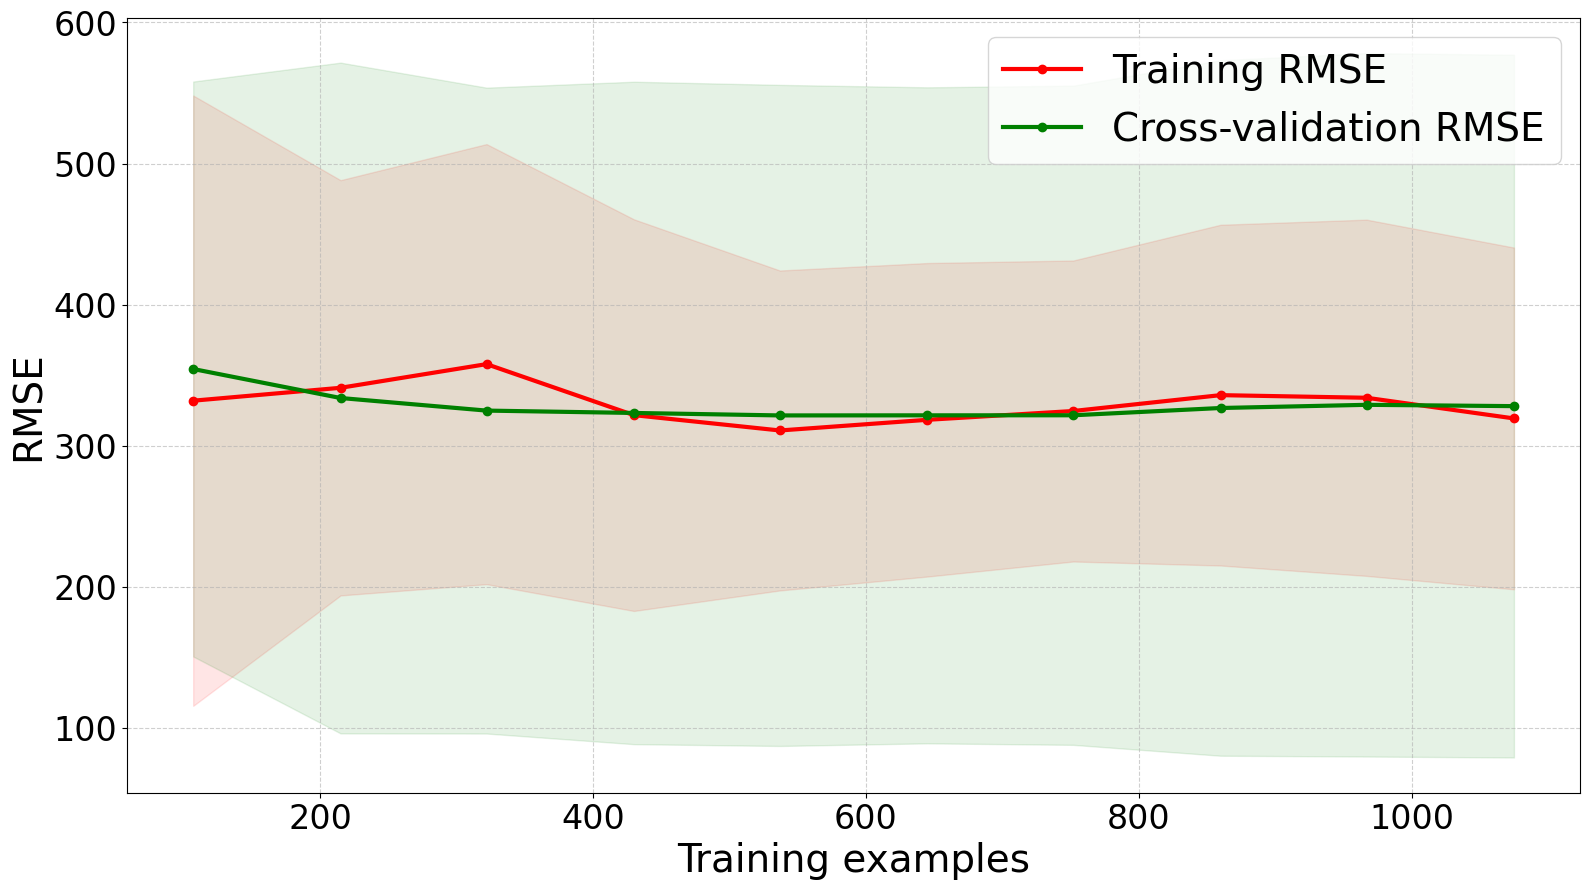


Evaluating Ridge with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Ridge Results:
[{'Approach': 'standard', 'Model Name': 'Ridge', 'Model Size (kB)': 0.697265625, 'Best Hyperparameters': {'alpha': 10}, 'Hyperparameter Tuning Time (s)': 0.6383812427520752, 'Train RMSE': 324.6380858922174, 'Train R²': 0.5518507675563149, 'Training Time (s)': 0.021337270736694336, 'Validation RMSE': 326.6594417351257, 'Validation R²': 0.5199296890107226, 'Validation Time (s)': 0.03307008743286133, 'Test RMSE': 406.0509346597392, 'Test R²': 0.39096386395812055, 'Test Time (s)': 0.002880096435546875}]
Plotting learning curve for Ridge()...


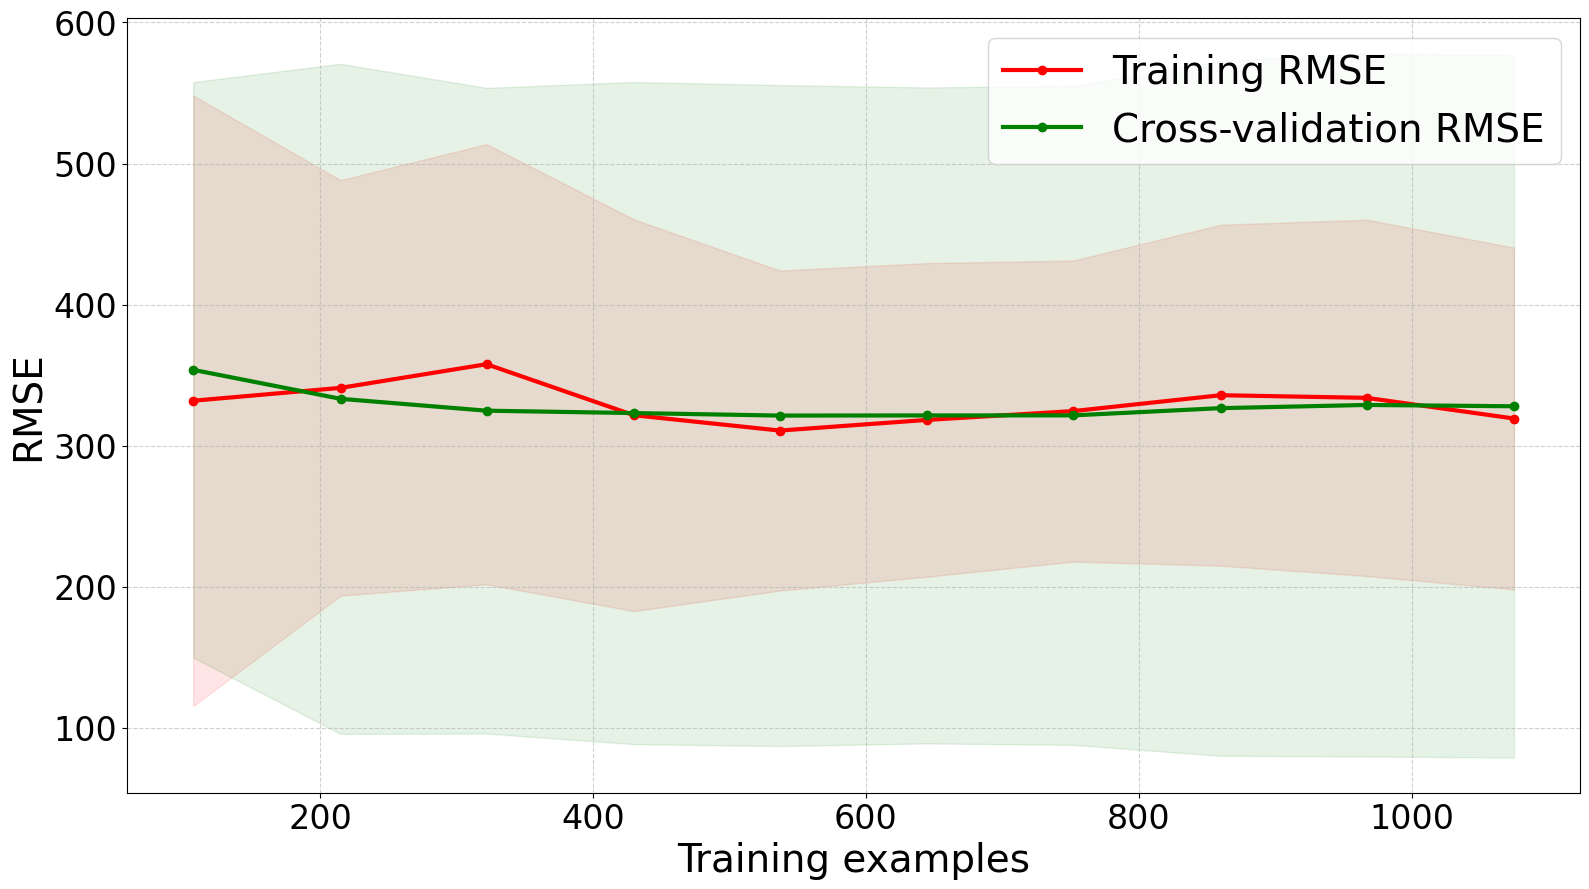


Evaluating Lasso with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Lasso Results:
[{'Approach': 'standard', 'Model Name': 'Lasso', 'Model Size (kB)': 0.794921875, 'Best Hyperparameters': {'alpha': 1}, 'Hyperparameter Tuning Time (s)': 0.12739014625549316, 'Train RMSE': 324.6319057234226, 'Train R²': 0.5518681017720362, 'Training Time (s)': 0.020435571670532227, 'Validation RMSE': 326.71171192991306, 'Validation R²': 0.5191809270703096, 'Validation Time (s)': 0.016939163208007812, 'Test RMSE': 406.18488182258176, 'Test R²': 0.3905619827603737, 'Test Time (s)': 0.0026702880859375}]
Plotting learning curve for Lasso()...


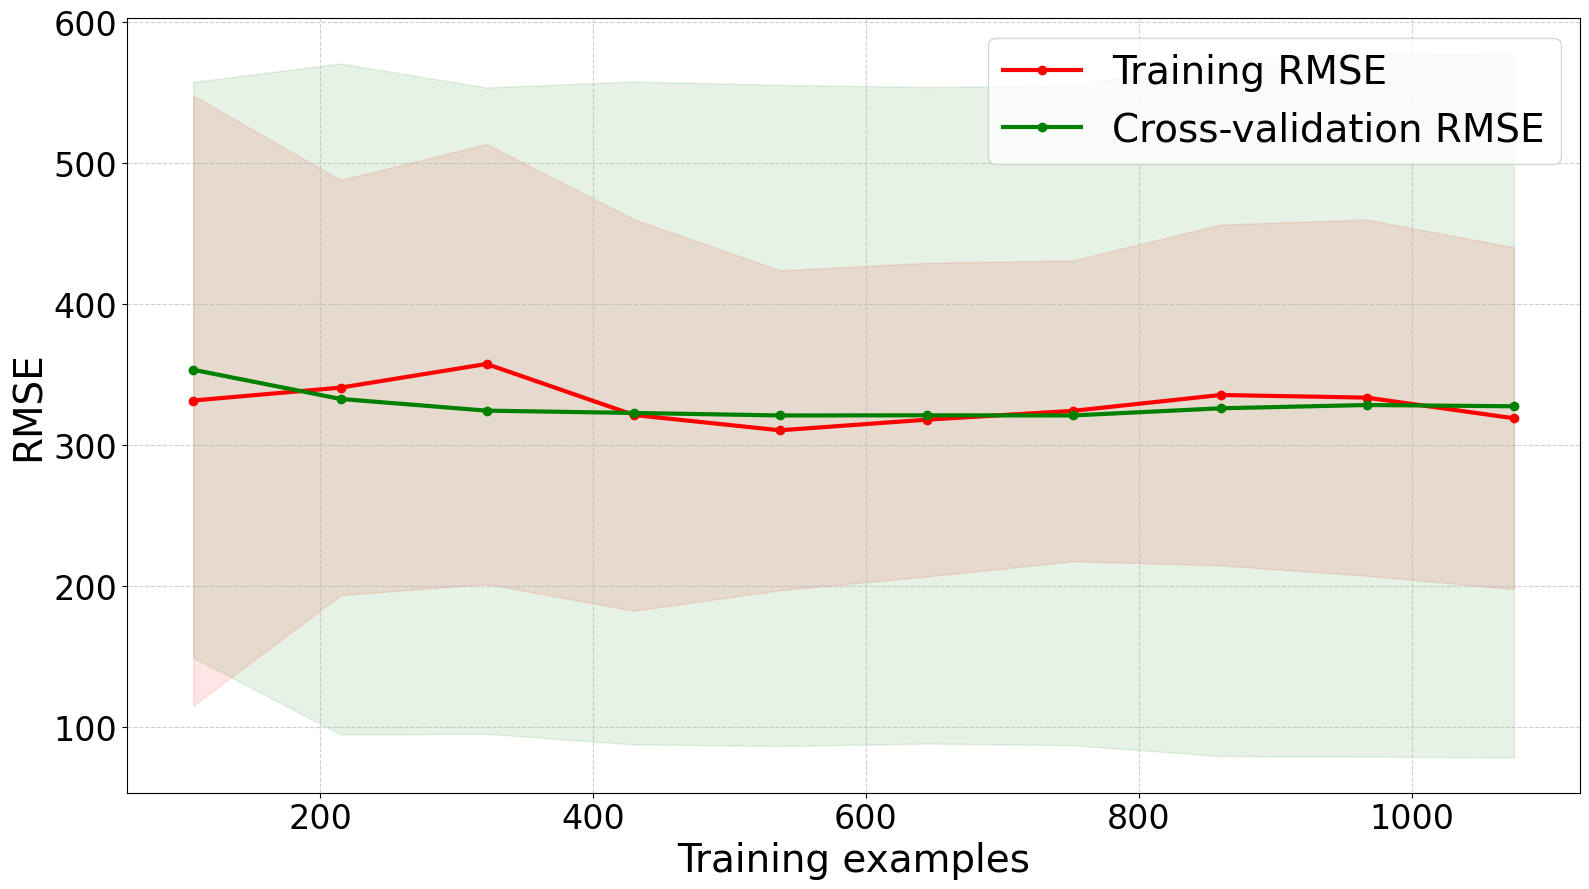


Evaluating ElasticNet with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
ElasticNet Results:
[{'Approach': 'standard', 'Model Name': 'ElasticNet', 'Model Size (kB)': 0.806640625, 'Best Hyperparameters': {'alpha': 0.1, 'l1_ratio': 0.9}, 'Hyperparameter Tuning Time (s)': 0.4425222873687744, 'Train RMSE': 324.6289878184158, 'Train R²': 0.5518758687186778, 'Training Time (s)': 0.02105569839477539, 'Validation RMSE': 326.6750865584438, 'Validation R²': 0.5197509257521822, 'Validation Time (s)': 0.01614832878112793, 'Test RMSE': 406.0543934800533, 'Test R²': 0.390953488138973, 'Test Time (s)': 0.002508878707885742}]
Plotting learning curve for ElasticNet()...


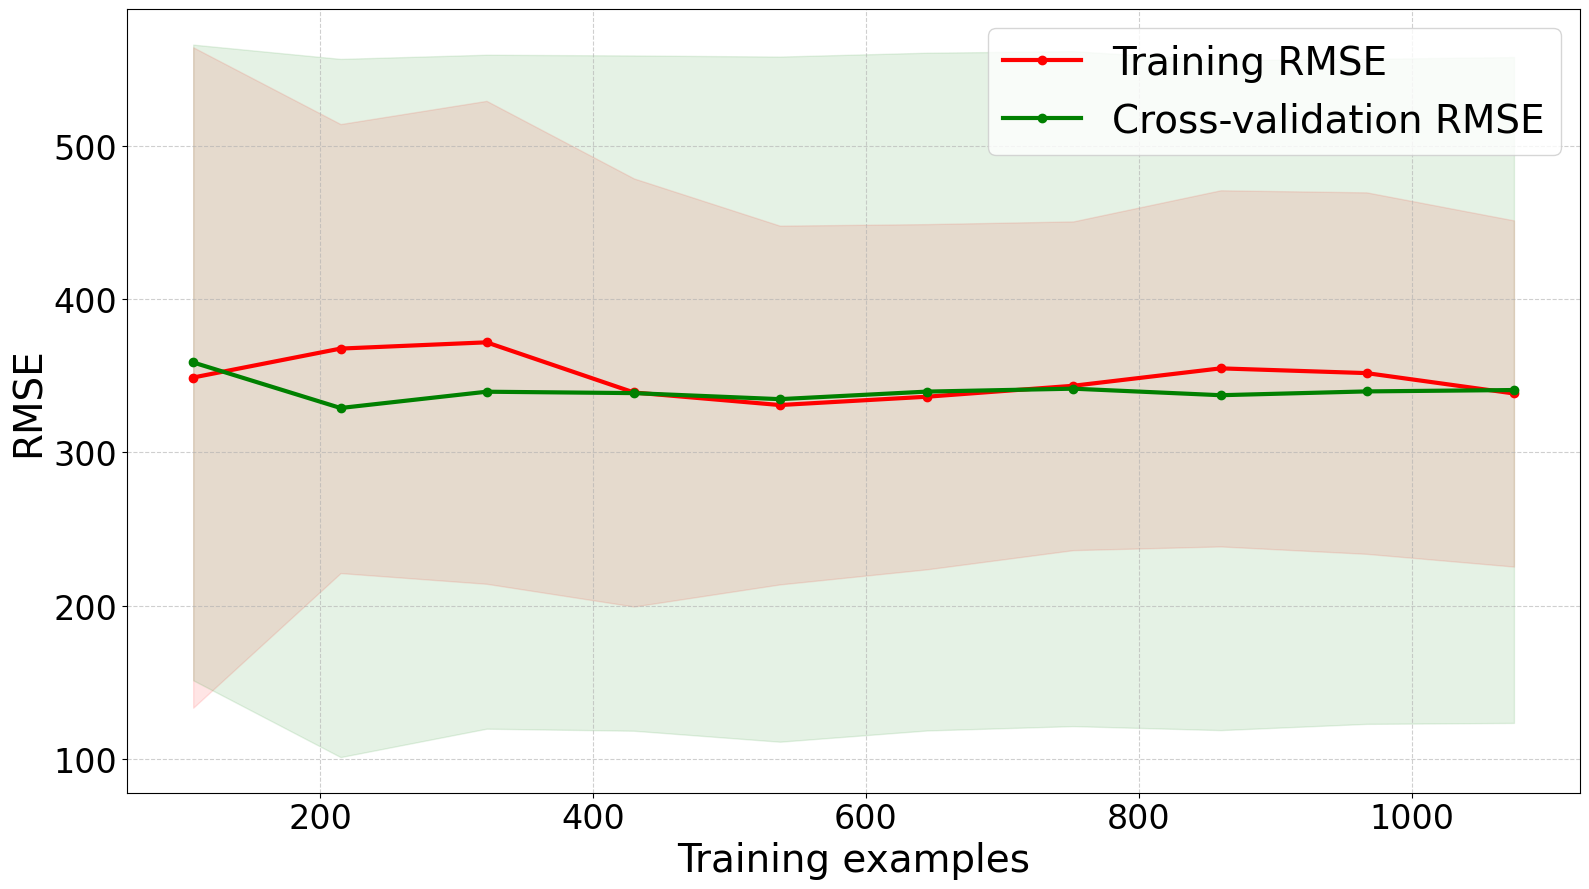


Evaluating SVR with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
SVR Results:
[{'Approach': 'standard', 'Model Name': 'SVR', 'Model Size (kB)': 11.095703125, 'Best Hyperparameters': {'C': 1000, 'epsilon': 20}, 'Hyperparameter Tuning Time (s)': 6.353511095046997, 'Train RMSE': 212.2514657022927, 'Train R²': 0.8072522561129698, 'Training Time (s)': 0.40448808670043945, 'Validation RMSE': 241.0964626042083, 'Validation R²': 0.7320089085812744, 'Validation Time (s)': 0.06940937042236328, 'Test RMSE': 278.9712988145584, 'Test R²': 0.7125243389861666, 'Test Time (s)': 0.011356830596923828}]
Plotting learning curve for SVR()...


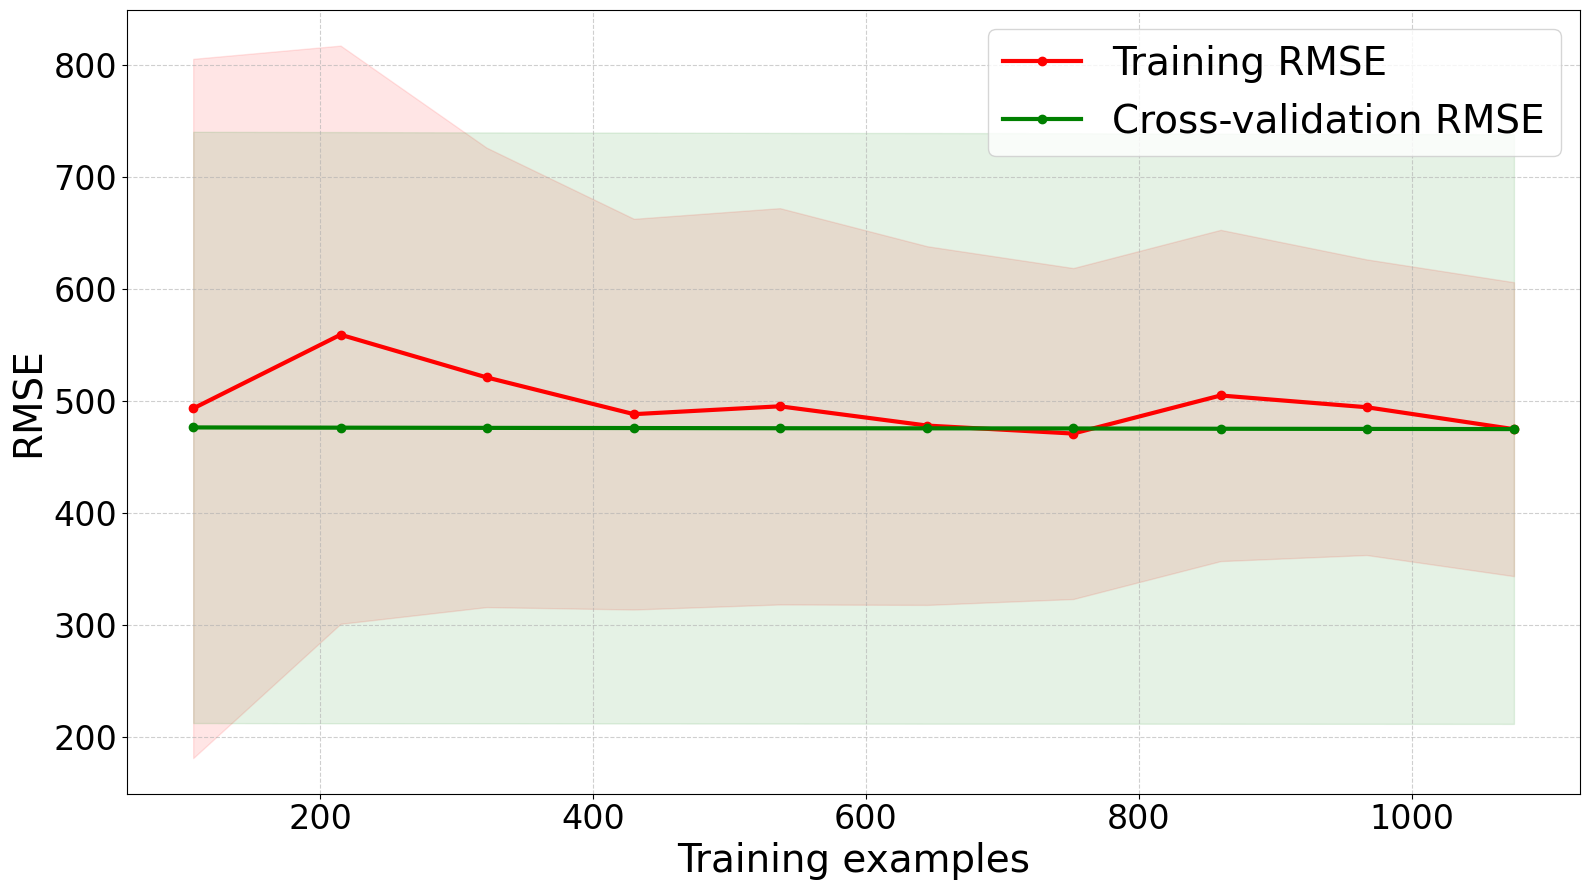


Evaluating Random Forest with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Random Forest Results:
[{'Approach': 'standard', 'Model Name': 'RandomForestRegressor', 'Model Size (kB)': 28.5654296875, 'Best Hyperparameters': {'bootstrap': False, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 8}, 'Hyperparameter Tuning Time (s)': 29.227912187576294, 'Train RMSE': 99.62518751799212, 'Train R²': 0.95348950607779, 'Training Time (s)': 0.30514001846313477, 'Validation RMSE': 217.90977336280616, 'Validation R²': 0.7511565728670886, 'Validation Time (s)': 0.03587460517883301, 'Test RMSE': 238.37344908210235, 'Test R²': 0.7901070781142945, 'Test Time (s)': 0.004744052886962891}]
Plotting learning curve for RandomForestRegressor(random_state=42)...


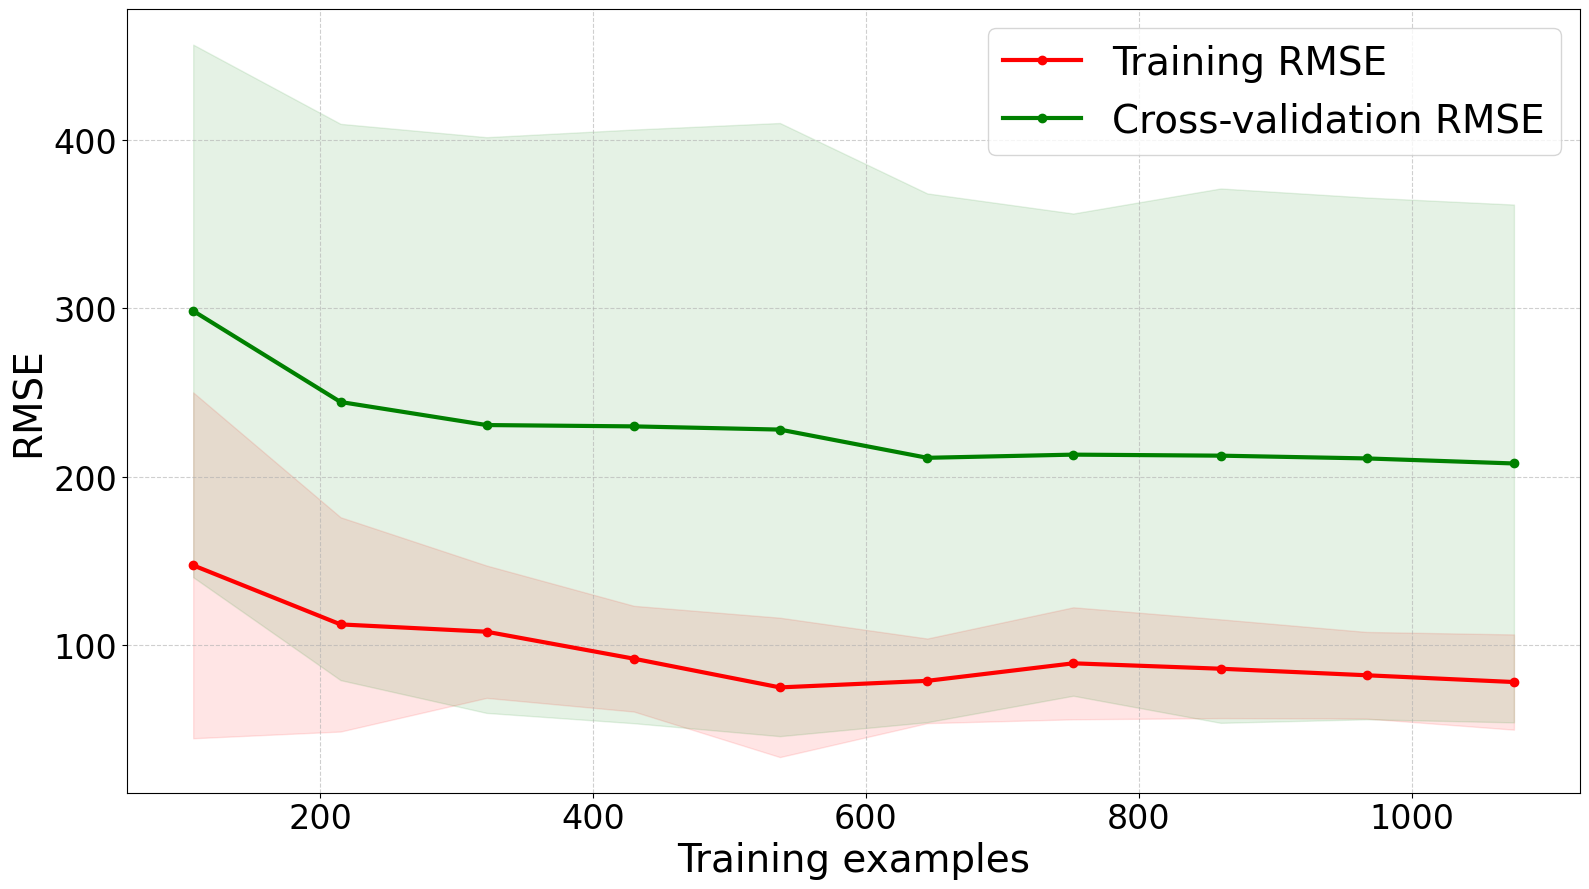


Evaluating Gradient Boosting with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Gradient Boosting Results:
[{'Approach': 'standard', 'Model Name': 'GradientBoostingRegressor', 'Model Size (kB)': 486.2138671875, 'Best Hyperparameters': {'learning_rate': 0.01, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400, 'n_iter_no_change': 10, 'subsample': 1.0, 'tol': 0.001, 'validation_fraction': 0.2}, 'Hyperparameter Tuning Time (s)': 21.431695222854614, 'Train RMSE': 149.4474794562615, 'Train R²': 0.899589139096707, 'Training Time (s)': 6.669189214706421, 'Validation RMSE': 234.44757686045827, 'Validation R²': 0.7265324723364086, 'Validation Time (s)': 0.054093360900878906, 'Test RMSE': 242.05292627866757, 'Test R²': 0.7835773516255835, 'Test Time (s)': 0.0045070648193359375}]
Plotting learning curve for GradientBoostingRegressor(random_state=42)...


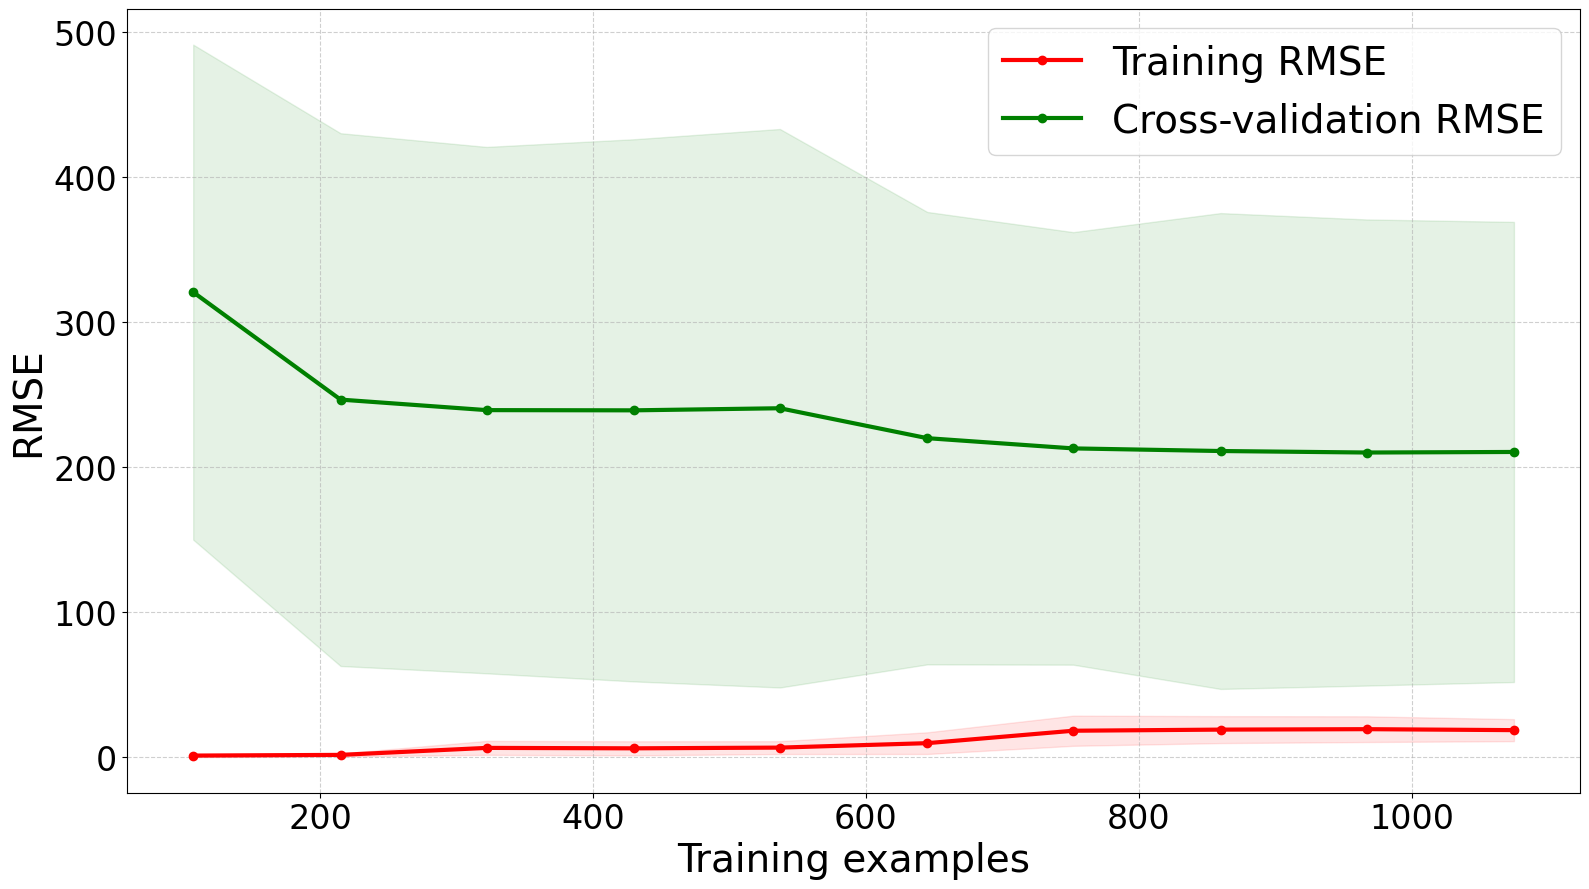


Evaluating Decision Tree with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Decision Tree Results:
[{'Approach': 'standard', 'Model Name': 'DecisionTreeRegressor', 'Model Size (kB)': 2.583984375, 'Best Hyperparameters': {'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}, 'Hyperparameter Tuning Time (s)': 3.5798537731170654, 'Train RMSE': 155.92748376110657, 'Train R²': 0.895316848104898, 'Training Time (s)': 0.043679237365722656, 'Validation RMSE': 201.02033441972682, 'Validation R²': 0.8014221239160519, 'Validation Time (s)': 0.02062225341796875, 'Test RMSE': 222.85828806424084, 'Test R²': 0.8165407504811888, 'Test Time (s)': 0.0033295154571533203}]
Plotting learning curve for DecisionTreeRegressor(random_state=42)...


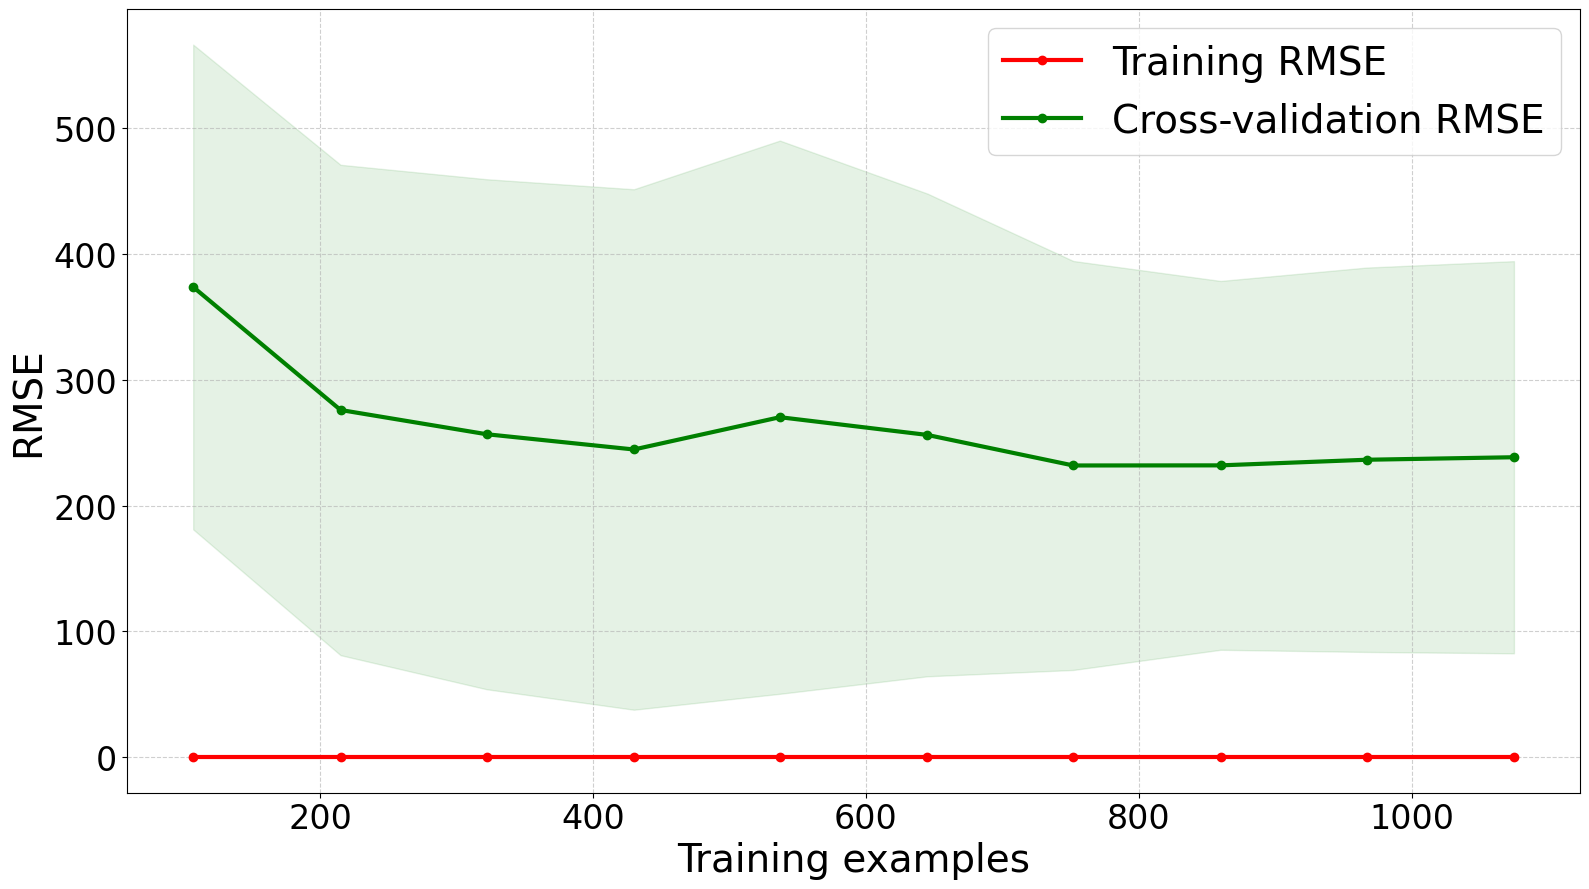


Evaluating KNeighbors with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
KNeighbors Results:
[{'Approach': 'standard', 'Model Name': 'KNeighborsRegressor', 'Model Size (kB)': 144.0478515625, 'Best Hyperparameters': {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}, 'Hyperparameter Tuning Time (s)': 13.262358665466309, 'Train RMSE': 143.10040585559574, 'Train R²': 0.9116941332331594, 'Training Time (s)': 0.03496432304382324, 'Validation RMSE': 252.34710762897993, 'Validation R²': 0.6837100329449284, 'Validation Time (s)': 0.04810380935668945, 'Test RMSE': 366.49635790433564, 'Test R²': 0.5038404456963411, 'Test Time (s)': 0.008042335510253906}]
Plotting learning curve for KNeighborsRegressor()...


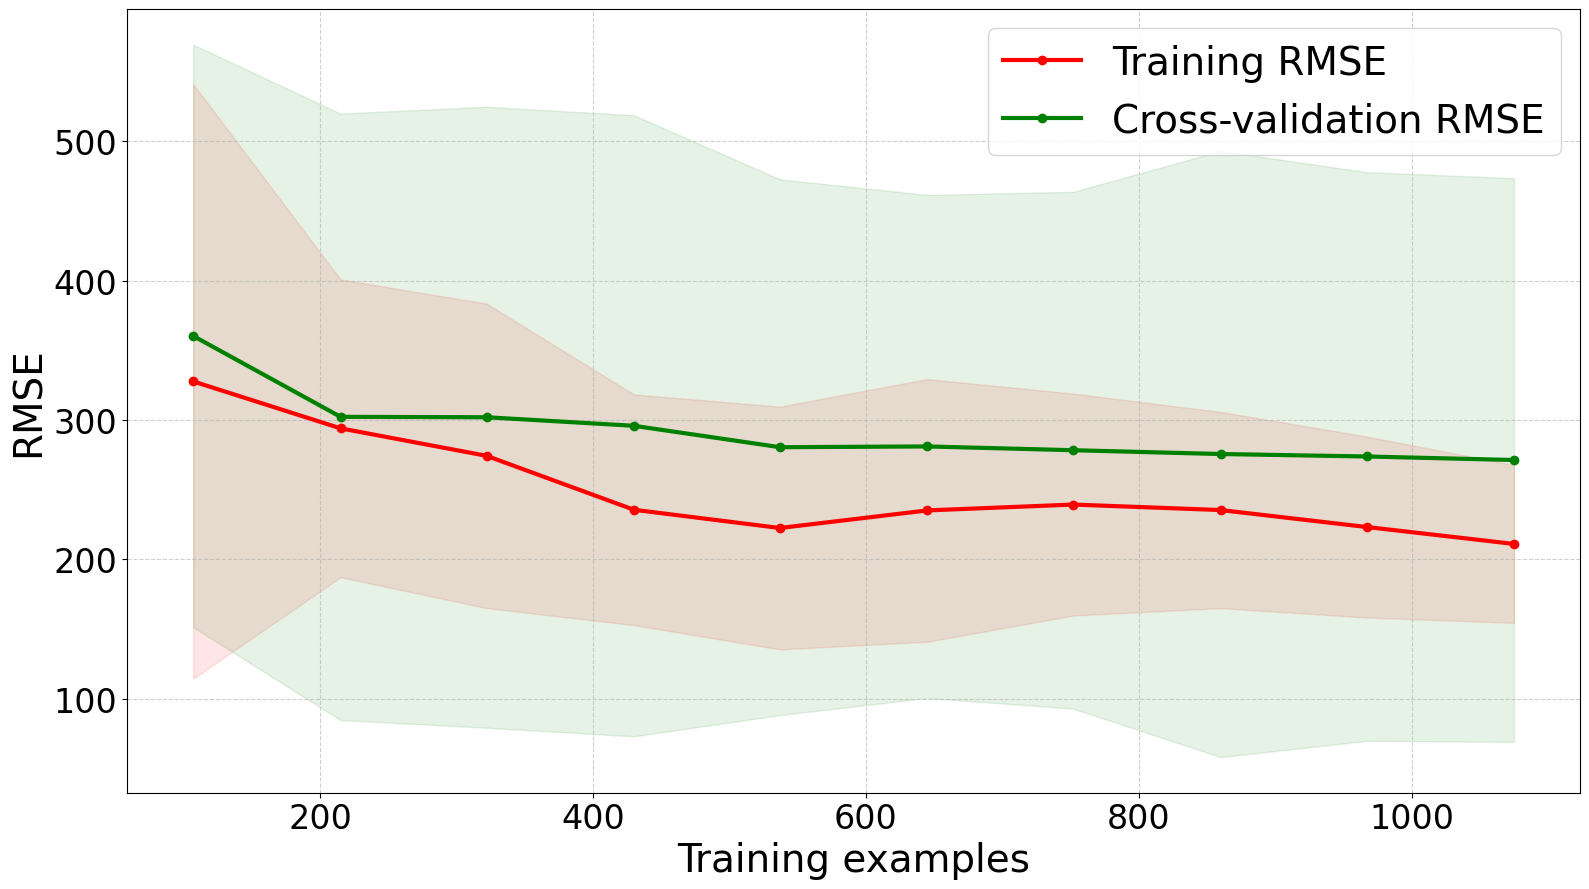


Evaluating Neural Network with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Neural Network Results:
[{'Approach': 'standard', 'Model Name': 'MLPRegressor', 'Model Size (kB)': 7.4912109375, 'Best Hyperparameters': {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (50,), 'solver': 'lbfgs', 'tol': 0.001}, 'Hyperparameter Tuning Time (s)': 13.931628704071045, 'Train RMSE': 132.2709117509054, 'Train R²': 0.924672106860621, 'Training Time (s)': 1.6500318050384521, 'Validation RMSE': 280.5964579570947, 'Validation R²': 0.6154175596515986, 'Validation Time (s)': 0.022538185119628906, 'Test RMSE': 419.34046067945656, 'Test R²': 0.35044554103726777, 'Test Time (s)': 0.008269548416137695}]
Plotting learning curve for MLPRegressor(random_state=42)...


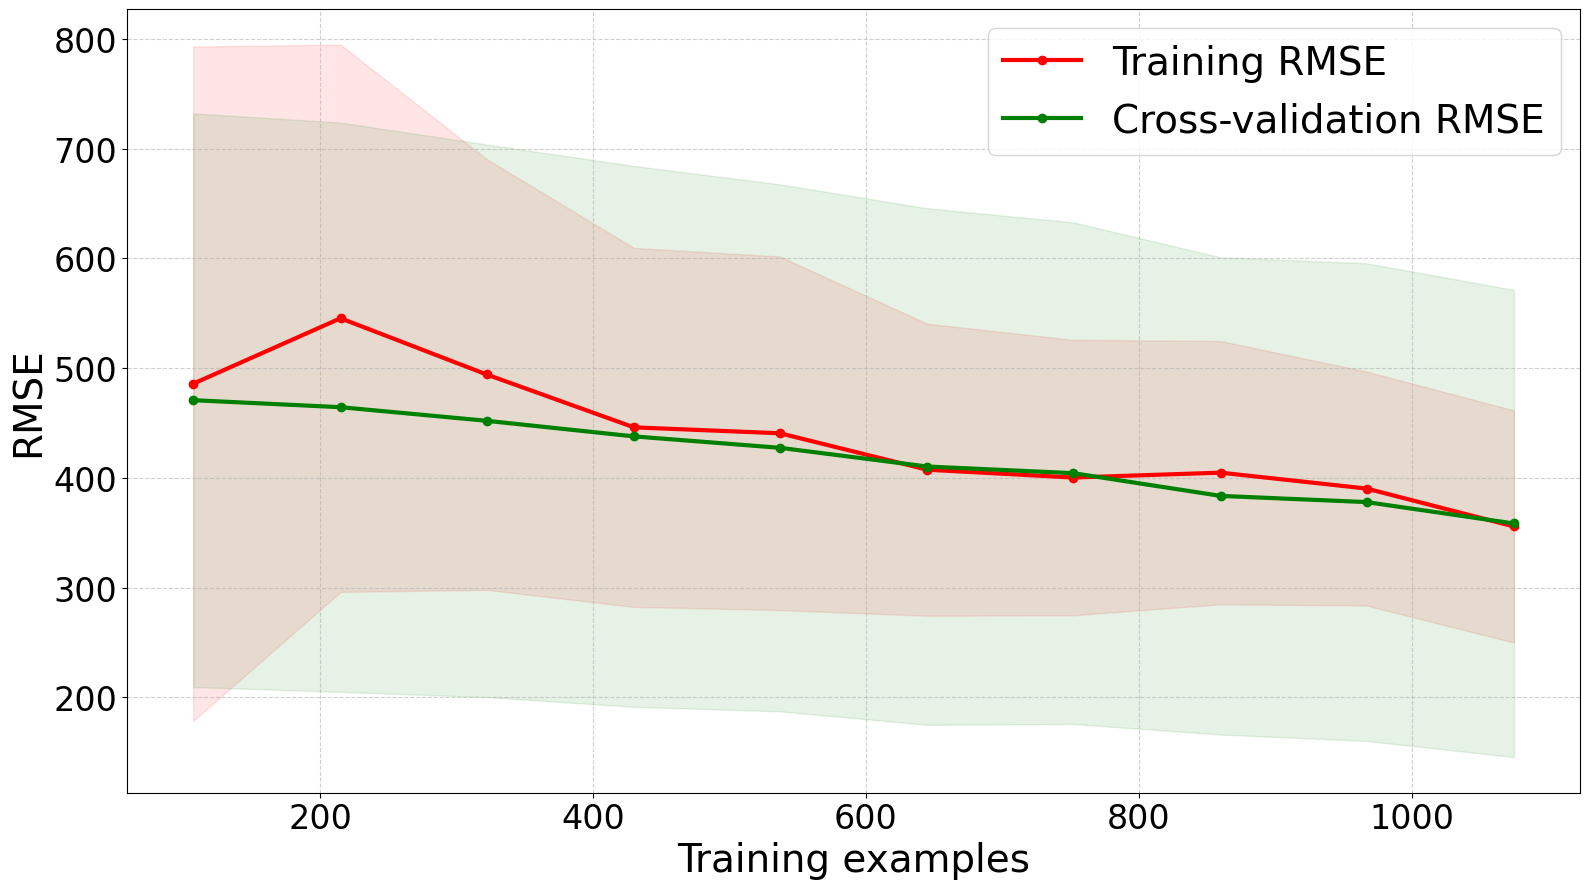

Results with Standard Preprocessing Pipeline:


Approach                 Model Name  Model Size (kB)                               Best Hyperparameters Hyperparameter Tuning Time (s)  Train RMSE  Train R²  Training Time (s)  Validation RMSE  Validation R²  Validation Time (s)  Test RMSE  Test R²  Test Time (s)
7  standard      DecisionTreeRegressor            2.584  {'criterion': 'squared_error', 'max_depth': 5,...                          3.580     155.927     0.895              0.044          201.020          0.801                0.021    222.858    0.817          0.003
5  standard      RandomForestRegressor           28.565  {'bootstrap': False, 'max_depth': 5, 'max_feat...                         29.228      99.625     0.953              0.305          217.910          0.751                0.036    238.373    0.790          0.005
6  standard  GradientBoostingRegressor          486.214  {'learning_rate': 0.01, 'max_depth': 3, 'max_f...                         21.432     149.447     0.900              6.669          234.448          0.727                0.054    242.053    0.784          0.005
4  standard                        SVR           11.096                         {'C': 1000, 'epsilon': 20}                          6.354     212.251     0.807              0.404          241.096          0.732                0.069    278.971    0.713          0.011
8  standard        KNeighborsRegressor          144.048  {'algorithm': 'auto', 'leaf_size': 2, 'n_neigh...                         13.262     143.100     0.912              0.035          252.347          0.684                0.048    366.496    0.504          0.008
1  standard                      Ridge            0.697                                      {'alpha': 10}                          0.638     324.638     0.552              0.021          326.659          0.520                0.033    406.051    0.391          0.003
3  standard                 ElasticNet            0.807                    {'alpha': 0.1, 'l1_ratio': 0.9}                          0.443     324.629     0.552              0.021          326.675          0.520                0.016    406.054    0.391          0.003
0  standard           LinearRegression            0.744                                                  -                              -     324.604     0.552              0.016          326.806          0.519                0.016    406.144    0.391          0.003
2  standard                      Lasso            0.795                                       {'alpha': 1}                          0.127     324.632     0.552              0.020          326.712          0.519                0.017    406.185    0.391          0.003
9  standard               MLPRegressor            7.491  {'activation': 'relu', 'early_stopping': True,...                         13.932     132.271     0.925              1.650          280.596          0.615                0.023    419.340    0.350          0.008

In [ ]:
# Initialize results list to store evaluation results for all models
all_standard_results = []

# Perform evaluation for each model
for model_name, model in regression_models.items():
    print(f"\nEvaluating {model_name} with cross-validation...")

    # Check if the model has associated hyperparameters
    if model_name in hyperparameter_space:
        model_hyperparameter_space = hyperparameter_space[model_name]
        # Evaluate model with hyperparameters and cross-validation
        model_results = evaluate_model(
            'standard', model, X_standard_train, y_standard_train,
            X_standard_val, y_standard_val, X_standard_test, y_standard_test,
            model_hyperparameter_space=model_hyperparameter_space, cv=cv, n_jobs=-1
        )
    else:
        # Evaluate model without hyperparameters
        model_results = evaluate_model(
            'standard', model, X_standard_train, y_standard_train,
            X_standard_val, y_standard_val, X_standard_test, y_standard_test,
            cv=cv, n_jobs=-1
        )

    # Print model results
    print(f"{model_name} Results:")
    print(model_results)
    # Extend the results list with the current model's results
    all_standard_results.extend(model_results)

    # Plot and save learning curve for the current model
    plot_learning_curve(
        'standard', model, X_standard_train, y_standard_train,
        X_standard_val, y_standard_val, cv=cv, n_jobs=-1
    )

# Convert results list to DataFrame for better readability
standard_results_df = pd.DataFrame(all_standard_results)
# Sort results by 'Test RMSE'
standard_results_df.sort_values(by='Test RMSE', inplace=True)

# Save results to a CSV file
save_file(standard_results_df, 'standard/tables/standard_results.csv')

# Print final results DataFrame
print("Results with Standard Preprocessing Pipeline:")
standard_results_df


---

**Results Summary**

The evaluation of regression models has been completed, and the results are stored in the `standard_results.csv` file. The results include metrics such as RMSE and R-squared (R²) for each model, allowing for comparison and selection of the best model. The learning curves have also been plotted to visualize model performance during training and validation.

By examining these results, we can identify the most effective model for predicting the target variable and make informed decisions for further analysis and model refinement.

---


<div class="alert alert-info">

---

### **Custom Preprocessing Pipeline**

The Custom Preprocessing Pipeline is designed to handle specific data transformations and feature engineering tasks tailored to the dataset's unique requirements. This pipeline includes multiple stages to ensure comprehensive preprocessing and feature enhancement.

#### **Pipeline Stages:**

1. **Numeric Column Selector:**
   - **Function:** Selects numeric columns from the dataset, preparing them for subsequent processing steps.
   
2. **Feature Transformation:**
   - **New Columns Pipeline:**
     - **Weekly Pattern Imputer:** Handles missing values in columns related to new cases, deaths, and vaccinations by considering weekly patterns.
     - **NaN Processor:** Processes missing values specifically for the new columns.
     - **Custom Outlier Processor:** Identifies and processes outliers in new columns data.
   - **Independent Columns Pipeline:**
     - **NaN Processor:** Processes missing values for independent columns.
     - **Custom Outlier Processor:** Identifies and processes outliers in independent columns data.

3. **Computation Processor:**
   - **Function:** Performs additional computations to generate dependent columns and normalize data based on various metrics, including:
     - **New Total Columns:** Generates total counts from new columns.
     - **Raw Smoothed Columns:** Computes smoothed values for various metrics.
     - **Raw Per Million, Per Thousand, and Per Hundred Columns:** Normalizes data per million, thousand, or hundred based on the column's nature.

#### **Purpose:**
The custom preprocessing pipeline ensures that the dataset is not only cleaned and normalized but also enriched with derived features that can enhance the model's predictive power. By meticulously processing both new and independent columns and performing crucial computations, the pipeline prepares the data for robust modeling and analysis.

---

</div>


<div class="alert alert-info">

---

#### **Preprocess `new` Columns**

This step involves processing `'new_cases'` and `'new_deaths'` columns. These two columns are updated weekly so that the columns have six consecutive zeros followed by a value representing the sum of the values for the entire week. Therefore the maximum values in the columns are 0. This can lead to designing biased models. Therefore, we propose `WeeklyPatternImputer` - a step to identify the weekly update patterns in a column and evenly distribute the sum across the entire week. After that we fill the missing values (if any) using `CustomNaNProcessor`. Finally we detect and process local outliers using `CustomOutlierProcessor`.

---

</div>

<div class="alert alert-info">

---

##### **Weekly Pattern Imputation**

In our data preprocessing, we identified a recurring issue where certain columns, such as `new_cases` and `new_deaths`, exhibit a weekly update pattern. Specifically, these columns contain zero values for the first six days of each week, with the total value for the week recorded on the seventh day. This pattern can introduce bias into predictive models by misrepresenting daily variations.

To address this, we use the `WeeklyPatternImputer` class. This class detects the weekly patterns and redistributes the weekly totals evenly across all seven days. This correction ensures that our models are not skewed by the aggregated weekly values and provides a more accurate representation of daily changes.

---

</div>


In [ ]:
# class for weekly imputation of new cases and new deaths
class WeeklyPatternImputer(BaseEstimator, TransformerMixin):
    """
    Transformer that imputes missing values in time series data based on weekly patterns.

    This transformer detects weekly patterns where data may be missing and interpolates missing values
    based on these patterns to maintain consistency and reflect underlying trends.

    Parameters
    ----------
    columns : list of str
        List of column names in the dataset that require weekly pattern imputation.

    Methods
    -------
    fit(X, y=None)
        Fits the transformer (no-op for this transformer).

    transform(X)
        Applies weekly pattern imputation to the specified columns in the dataset.

    detect_weekly_pattern(X_column)
        Detects segments of missing values in a column that follow a weekly pattern.

    interpolate_segments(segments, X_column)
        Interpolates missing values in a column based on detected weekly patterns.
    """
    def __init__(self, columns):
        """
        Initializes the WeeklyPatternImputer with the specified columns.

        Parameters
        ----------
        columns : list of str
            List of column names to apply the imputation process.
        """
        self.columns = columns

    def fit(self, X, y=None):
        """
        Fits the transformer to the data. This method does nothing for this transformer
        but is included to conform to the scikit-learn API.

        Parameters
        ----------
        X : pd.DataFrame
            Input data.
        y : None
            Target variable (not used).

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        return self

    def transform(self, X):
        """
        Transforms the data by applying weekly pattern imputation.

        Parameters
        ----------
        X : pd.DataFrame
            Input data.

        Returns
        -------
        X_copy : pd.DataFrame
            Transformed data with missing values imputed based on weekly patterns.
        """
        X_copy = X.copy()
        for col in self.columns:
            segments = self.detect_weekly_pattern(X_copy[col])
            X_copy[col] = self.interpolate_segments(segments, X_copy[col])

        return X_copy

    def detect_weekly_pattern(self, X_column):
        """
        Detects segments of missing values in the column that follow a weekly pattern.

        Parameters
        ----------
        X_column : pd.Series
            Column data to detect weekly patterns.

        Returns
        -------
        weekly_pattern_segments : list of tuples
            List of tuples where each tuple contains the start index and length of a segment
            of missing values.
        """
        start = None
        length = 1
        weekly_pattern_segments = []
        for i, value in enumerate(X_column):
            if start is None and i > 0 and value == 0 and X_column.iloc[i-1] != 0:
                start = i
            elif start is not None and value == 0:
                length += 1
            elif start is not None and value != 0:
                weekly_pattern_segments.append((start, length))
                start = None
                length = 1

        return weekly_pattern_segments

    def interpolate_segments(self, segments, X_column):
        """
        Interpolates missing values in the column based on detected weekly patterns.

        Parameters
        ----------
        segments : list of tuples
            List of tuples where each tuple contains the start index and length of a segment
            of missing values.
        X_column : pd.Series
            Column data to interpolate.

        Returns
        -------
        X_column_copy : pd.Series
            Column data with missing values interpolated.
        """
        X_column_copy = X_column.copy()
        for segment in segments:
            start_index = segment[0]
            length = segment[1]
            end_index = start_index + length
            weekly_sum = X_column_copy.iloc[end_index]
            mean_value = weekly_sum / (length + 1)
            X_column_copy.iloc[start_index : end_index + 1] = mean_value

        return X_column_copy

**Conclusion**

By applying the `WeeklyPatternImputer`, we correct the bias introduced by the weekly aggregation of data. This step is crucial for ensuring the accuracy and reliability of our predictive models, as it provides a consistent daily measure and prevents misinterpretation of the data.

##### **Detect and Process Local Outliers**

For handling local outliers, we implement the `CustomOutlierProcessor` class, designed to identify and process outliers within a moving window of data. This approach is useful for detecting anomalies that are contextually significant within smaller, localized time frames, such as a rolling 30-day window.

**Class Overview:**

- **Initialization (`__init__`)**: Sets up the columns to be processed, the threshold for outlier detection, and the size of the rolling window.

- **Fitting (`fit`)**: Prepares the transformer for use but does not require any training.

- **Transformation (`transform`)**: Applies the local outlier detection and processing to the data.

- **Local Outlier Detection (`detect_and_process_local_outliers`)**: Calculates rolling statistics to identify outliers and processes them by replacing them with interpolated values. The local bounds for outliers are also computed.

- **Data Access Methods**: Provides methods to retrieve input and output data, as well as outlier indices and bounds for specific columns.

By applying the `CustomOutlierProcessor`, we account for local variations and anomalies in the data, ensuring that the processing is sensitive to short-term fluctuations and not just overall trends.


In [ ]:
class CustomOutlierProcessor(BaseEstimator, TransformerMixin):
    """
    Transformer that processes local outliers in the dataset using a rolling window approach.

    This transformer identifies local outliers based on Z-scores calculated from rolling statistics. Outliers
    are handled by setting them to NaN, followed by interpolation.

    Parameters
    ----------
    columns : list
        List of column names to process for outliers.
    threshold : float, default=2
        The Z-score threshold to identify outliers.
    window_size : int, default=30
        The size of the rolling window used for calculating statistics.

    Methods
    -------
    fit(X, y=None)
        Prepares the transformer for use but does not require any training.

    transform(X)
        Transforms the data by identifying and processing local outliers.

    detect_and_process_local_outliers(X, columns)
        Detects and processes local outliers for specified columns using rolling statistics.

    get_local_outliers_indices(column)
        Returns the indices of detected outliers for a given column.

    get_bounds(column)
        Returns the bounds for outlier detection in a given column.

    get_input_data(column)
        Returns the input data for a given column before outlier processing.

    get_output_data(column)
        Returns the output data for a given column after outlier processing.
    """

    def __init__(self, columns, threshold=2, window_size=30):
        """
        Initializes the CustomOutlierProcessor with specified parameters.

        Parameters
        ----------
        columns : list
            List of column names to process.
        threshold : float, default=2
            The Z-score threshold for outlier detection.
        window_size : int, default=30
            The size of the rolling window for statistical calculations.
        """
        self.columns = columns
        self.threshold = threshold
        self.window_size = window_size
        self.outliers = {}
        self.bounds = {}
        self.input_data = {}
        self.output_data = {}

    def fit(self, X, y=None):
        """
        Prepares the transformer for use but does not require training.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : CustomOutlierProcessor
            The instance itself.
        """
        return self

    def transform(self, X):
        """
        Transforms the data by detecting and processing local outliers.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with local outliers processed.
        """
        X_copy = X.copy()
        X_copy, self.outliers, self.bounds = self.detect_and_process_local_outliers(X_copy, self.columns)
        return X_copy

    def detect_and_process_local_outliers(self, X, columns):
        """
        Detects and processes local outliers for specified columns using rolling statistics.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        columns : list
            List of column names to process.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with local outliers processed.
        outliers_dict : dict
            A dictionary containing indices of detected outliers for each column.
        bounds_dict : dict
            A dictionary containing bounds for outlier detection for each column.
        """
        X_copy = X.copy()
        outliers_dict = {}
        bounds_dict = {}

        for col in columns:
            # Store the input data for this column
            self.input_data[col] = X_copy[col].copy()

            # Calculate rolling mean and standard deviation
            rolling_mean = X_copy[col].rolling(window=self.window_size, min_periods=1, center=True).mean()
            rolling_std = X_copy[col].rolling(window=self.window_size, min_periods=1, center=True).std()

            # Compute Z-scores and identify outliers
            z_scores = (X_copy[col] - rolling_mean) / rolling_std
            outlier_mask = np.abs(z_scores) > self.threshold
            outliers_dict[col] = X_copy.loc[outlier_mask, col].dropna().index.tolist()
            X_copy.loc[outlier_mask, col] = np.nan
            X_copy[col] = X_copy[col].interpolate()

            # Store the output data for this column
            self.output_data[col] = X_copy[col].copy()

            # Compute bounds for outlier detection
            bounds_dict[col] = (rolling_mean - self.threshold * rolling_std, rolling_mean + self.threshold * rolling_std)

        self.outliers = outliers_dict
        self.bounds = bounds_dict
        return X_copy, self.outliers, self.bounds

    def get_local_outliers_indices(self, column):
        """
        Returns the indices of detected outliers for a given column.

        Parameters
        ----------
        column : str
            The column name for which to get outlier indices.

        Returns
        -------
        list
            The list of indices of detected outliers.
        """
        return self.outliers.get(column, [])

    def get_bounds(self, column):
        """
        Returns the bounds for outlier detection in a given column.

        Parameters
        ----------
        column : str
            The column name for which to get bounds.

        Returns
        -------
        tuple
            A tuple containing the lower and upper bounds.
        """
        return self.bounds.get(column, (None, None))

    def get_input_data(self, column):
        """
        Returns the input data for a given column before outlier processing.

        Parameters
        ----------
        column : str
            The column name for which to get input data.

        Returns
        -------
        pd.Series
            The input data for the specified column.
        """
        return self.input_data.get(column, None)

    def get_output_data(self, column):
        """
        Returns the output data for a given column after outlier processing.

        Parameters
        ----------
        column : str
            The column name for which to get output data.

        Returns
        -------
        pd.Series
            The output data for the specified column.
        """
        return self.output_data.get(column, None)


**Conclusion**

The `CustomOutlierProcessor` class allows for effective handling of local outliers by using rolling windows to adapt to short-term data fluctuations. This localized approach improves the accuracy and reliability of data preprocessing by addressing anomalies that may not be evident in broader analyses.

<div class="alert alert-info">

---

#### **Preprocess Independent Columns**

This step involves processing the columns we have considered as independent, including `'new_tests' `, `'new_vaccinations'`, `'reproduction_rate'`, `'stringency_index'`, `'people_vaccinated'`, `'people_fully_vaccinated'` and `'total_boosters'`. We fill the missing values in these columns using `CustomNaNProcessor`and then detect and process local outliers using `CustomOutlierProcessor` as we did for the 'new' columns.

---

</div>

<div class="alert alert-info">

---

#### **Preprocess Dependent Columns**

This step involves processing the columns we have considered as dependent. We followed the [owid documentation](https://github.com/owid/covid-19-data/tree/master/public/data) and column descriptions to identify the computation relations of these columns with other columns. We designed custom `transformers` to compute the column values following the relations. Since these columns are dependent we don't need any `CustomNaNProcessor`or `CustomOutlierProcessor`.

---

</div>

##### **Compute `'positive_rate'`**

The positive rate at time t is calculated by taking the 7-day rolling average of the ratio of `'new_cases'` to `'new_tests'`, as given by the following equation:

$$
X_{positive\_rate}^{t}=\frac{\sum_{i=0}^{6}\frac{X_{new\_cases}^{t-i}}{X_{new\_tests}^{t-i}}}{7}
$$


In [ ]:
# ComputePositiveRate class

class ComputePositiveRate(BaseEstimator, TransformerMixin):
    """
    Transformer for computing the positive rate from new cases and new tests columns.

    This transformer calculates the positive rate as the ratio of new cases to new tests. It then smooths this
    ratio using a rolling window to account for short-term fluctuations.

    Parameters
    ----------
    new_cases_column : str
        The name of the column containing new case counts.
    new_tests_column : str
        The name of the column containing new test counts.

    Methods
    -------
    fit(X, y=None)
        Prepares the transformer for use but does not require training.

    transform(X)
        Computes the positive rate and adds it as a new column in the dataset.
    """

    def __init__(self, new_cases_column, new_tests_column):
        """
        Initializes the ComputePositiveRate transformer with specified columns.

        Parameters
        ----------
        new_cases_column : str
            The name of the column with new case counts.
        new_tests_column : str
            The name of the column with new test counts.
        """
        self.new_cases_column = new_cases_column
        self.new_tests_column = new_tests_column

    def fit(self, X, y=None):
        """
        Prepares the transformer for use but does not require training.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : ComputePositiveRate
            The instance itself.
        """
        return self

    def transform(self, X):
        """
        Computes the positive rate and adds it as a new column to the dataset.

        The positive rate is calculated as the ratio of new cases to new tests, and is smoothed using a rolling
        window of size 7 days.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with an additional 'positive_rate' column.
        """
        X_copy = X.copy()
        # Calculate the positive rate
        ratio = X_copy[self.new_cases_column] / X_copy[self.new_tests_column]
        # Replace any NaN or infinite values with 0
        ratio.replace([np.nan, np.inf, -np.inf], 0, inplace=True)
        # Add the positive rate to the DataFrame with rolling mean smoothing
        X_copy['positive_rate'] = ratio.rolling(window=7, min_periods=1).mean()

        return X_copy


##### **Compute `'tests_per_case'`**

It is computed as the inverse of `'positive_rate'`, given by the following equation.

$$
X_{tests\_per\_case}^{t} = \frac{1}{X_{positive\_rate}^{t}}
$$

In [ ]:
# column transformer of 'tests_per_case'

class ComputeTestsPerCase(BaseEstimator, TransformerMixin):
    """
    Transformer for computing the number of tests per case from the positive rate column.

    This transformer calculates the number of tests per case as the reciprocal of the positive rate. It ensures
    that any NaN or infinite values are handled appropriately.

    Parameters
    ----------
    tests_per_case_column : str
        The name of the column where the computed tests per case will be stored.
    positive_rate_column : str
        The name of the column containing the positive rate values.

    Methods
    -------
    fit(X, y=None)
        Prepares the transformer for use but does not require training.

    transform(X)
        Computes the number of tests per case and adds it as a new column in the dataset.
    """

    def __init__(self, tests_per_case_column, positive_rate_column):
        """
        Initializes the ComputeTestsPerCase transformer with specified columns.

        Parameters
        ----------
        tests_per_case_column : str
            The name of the column where the computed tests per case will be stored.
        positive_rate_column : str
            The name of the column containing the positive rate values.
        """
        self.tests_per_case_column = tests_per_case_column
        self.positive_rate_column = positive_rate_column

    def fit(self, X, y=None):
        """
        Prepares the transformer for use but does not require training.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : ComputeTestsPerCase
            The instance itself.
        """
        return self

    def transform(self, X):
        """
        Computes the number of tests per case and adds it as a new column to the dataset.

        The number of tests per case is calculated as the reciprocal of the positive rate. Any NaN or infinite
        values are replaced with zero to ensure the data integrity.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with an additional column for the number of tests per case.
        """
        X_copy = X.copy()
        # Compute the number of tests per case as the reciprocal of the positive rate
        X_copy[self.tests_per_case_column] = 1 / X_copy[self.positive_rate_column]
        # Replace any NaN or infinite values with 0
        X_copy[self.tests_per_case_column].replace([np.nan, np.inf, -np.inf], 0, inplace=True)
        return X_copy


##### **Compute `new` from `total`**

The new column is calculated by taking the difference between consecutive values in the total column. For the first entry, the value is set by subtracting the second day's value from the first day's value to ensure a meaningful initial value. The computation method is given by the following equation:


$$
X_{new}^{t} =
    \begin{cases}
        X_{total}^{t}, &{\text{if}}\ t = 0 \\
        X_{total}^{t} - X_{total}^{t-1}, &{\text{if}}\ t > 0
    \end{cases}
$$

In [ ]:
# column trasformer for new from total column

class CreateNewFromTotal(BaseEstimator, TransformerMixin):
    """
    Transformer for creating a new column representing the difference between successive values of a total column.

    This transformer calculates the new column values as the difference between consecutive values in a total column.
    It handles the edge case for the first value by using the difference between the first and second values of the total column.

    Parameters
    ----------
    new_column : str
        The name of the new column to be created from the total column.
    total_column : str
        The name of the total column from which the new column will be derived.

    Methods
    -------
    fit(X, y=None)
        Prepares the transformer for use but does not require training.

    transform(X)
        Computes the new column based on the difference between successive values of the total column.
    """

    def __init__(self, new_column, total_column):
        """
        Initializes the CreateNewFromTotal transformer with specified columns.

        Parameters
        ----------
        new_column : str
            The name of the new column to be created.
        total_column : str
            The name of the total column from which to derive the new column.
        """
        self.new_column = new_column
        self.total_column = total_column

    def fit(self, X, y=None):
        """
        Prepares the transformer for use but does not require training.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : CreateNewFromTotal
            The instance itself.
        """
        return self

    def transform(self, X):
        """
        Computes the new column as the difference between successive values in the total column.

        For the new column, the first value is calculated as the difference between the first and second values of the total column.
        This ensures that the new column accurately reflects changes from the total column.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with the additional new column derived from the total column.
        """
        X_copy = X.copy()
        # Compute the difference between successive values in the total column
        X_copy[self.new_column] = X_copy[self.total_column].diff()
        # Handle the edge case for the first value
        X_copy[self.new_column].iloc[0] = X_copy[self.total_column].iloc[1] - X_copy[self.new_column].iloc[1]

        return X_copy


This computation equation and the corresponding custom transformer is used to compute the following `new` columns. The column `new_people_vaccinated` is not present in the original data, we created this column in the custom pipeline.

| `total` Columns                       | `new` Columns      |
|---------------------------------------------|--------------------|
| 1. `people_vaccinated`           | `new_people_vaccinated` |

##### **Compute `total` from `new`**

In the study, all total columns are calculated as the cumulative sum of the variables derived from the corresponding new columns, are expressed by the following equation:

$$
X_{total}^{t} = \sum_{i=0}^{t}X_{new}^{t}
$$

In [ ]:
# column transformer for total from new columns

class ComputeTotalFromNew(BaseEstimator, TransformerMixin):
    """
    Transformer for computing total columns from new columns by calculating the cumulative sum.

    This transformer creates total columns by computing the cumulative sum of the corresponding new columns.
    It handles missing values by filling them with zero.

    Parameters
    ----------
    column_pairs : list of tuples
        A list where each tuple contains two elements:
        - new: The name of the new column from which to compute the total.
        - total: The name of the total column to be created.

    Methods
    -------
    fit(X, y=None)
        Prepares the transformer for use but does not require training.

    transform(X)
        Computes total columns by calculating the cumulative sum of the new columns.
    """

    def __init__(self, column_pairs):
        """
        Initializes the ComputeTotalFromNew transformer with specified column pairs.

        Parameters
        ----------
        column_pairs : list of tuples
            A list of tuples where each tuple contains the new column and the corresponding total column.
        """
        self.column_pairs = column_pairs

    def fit(self, X, y=None):
        """
        Prepares the transformer for use but does not require training.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : ComputeTotalFromNew
            The instance itself.
        """
        return self

    def transform(self, X):
        """
        Computes total columns by calculating the cumulative sum of the new columns.

        For each pair of new and total columns, the total column is created as the cumulative sum of the corresponding new column.
        Missing values in the total column are filled with zero.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with additional total columns derived from the new columns.
        """
        X_copy = X.copy()
        # Compute the cumulative sum for each new column to derive the total column
        for new, total in self.column_pairs:
            X_copy[total] = X_copy[new].cumsum()
            # Fill missing values with zero
            X_copy[total] = X_copy[total].fillna(0)
        return X_copy


This computation equation and the corresponding custom transformer is used to compute the following columns

| `new` Columns                       | `total` Columns      |
|---------------------------------------------|--------------------|
| 1. `new_cases`           | `total_cases` |
|2. `new_deaths`| `total_deaths`|
|3. `new_tests`| `total_tests`|
|4. `new_vaccinations` | `total_vaccinations`|

##### **Compute `smoothed` from `raw`**

The `'smoothed'` columns are computed by applying a rolling average technique to the original column values (`raw`). This process is expressed by the following equation:

$$
X_{smoothed}^{t} = \frac{\sum_{i=0}^{6} X_{raw}^{t-i}}{7}
$$

In [ ]:
# column transformer from raw to smoothed

class ComputeSmoothedFromRaw(BaseEstimator, TransformerMixin):
    """
    Transformer for computing smoothed columns from raw columns using a rolling average.

    This transformer creates smoothed columns by applying a rolling average to the raw columns.
    It uses a window of 7 periods for smoothing and fills missing values with zero.

    Parameters
    ----------
    column_pairs : list of tuples
        A list where each tuple contains two elements:
        - raw: The name of the raw column to be smoothed.
        - smoothed: The name of the smoothed column to be created.

    Methods
    -------
    fit(X, y=None)
        Prepares the transformer for use but does not require training.

    transform(X)
        Computes smoothed columns by applying a rolling average to the raw columns.
    """

    def __init__(self, column_pairs):
        """
        Initializes the ComputeSmoothedFromRaw transformer with specified column pairs.

        Parameters
        ----------
        column_pairs : list of tuples
            A list of tuples where each tuple contains the raw column and the corresponding smoothed column.
        """
        self.column_pairs = column_pairs

    def fit(self, X, y=None):
        """
        Prepares the transformer for use but does not require training.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : ComputeSmoothedFromRaw
            The instance itself.
        """
        return self

    def transform(self, X):
        """
        Computes smoothed columns by applying a rolling average to the raw columns.

        For each pair of raw and smoothed columns, the smoothed column is created as the rolling mean of the raw column.
        Missing values in the smoothed column are filled with zero.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with additional smoothed columns derived from the raw columns.
        """
        X_copy = X.copy()
        # Apply rolling average to each raw column to derive the smoothed column
        for raw, smoothed in self.column_pairs:
            X_copy[smoothed] = X_copy[raw].rolling(window=7).mean()
            # Fill missing values with zero
            X_copy[smoothed] = X_copy[smoothed].fillna(0)
        return X_copy


This computation equation and the corresponding custom transformer is used to compute the following columns

| `raw` Columns                       | `smoothed` Columns      |
|---------------------------------------------|--------------------|
| 1. `new_cases`           | `new_cases_smoothed` |
|2. `new_deaths`| `new_deaths_smoothed`|
|3. `new_tests`| `new_tests_smoothed`|
|4. `new_vaccinations` | `new_vaccinations_smoothed`|
|5. `new_people_vaccinated`|`new_people_vaccinated_smoothed`|

##### **Compute `per_million` from `raw`**

The `'per_million'` column values are computed by dividing the original column values (`raw`) by the total population in millions, expressed by the following equation:

$$
X_{per\_million}^{t} = \frac{X_{raw}^{t} \times 10^6}{population}
$$

In [ ]:
# column transformer of per million from raw

class ComputePerMillionFromRaw(BaseEstimator, TransformerMixin):
    """
    Transformer for computing per-million values from raw data.

    This transformer calculates per-million values by dividing raw column values by the total population (in millions).
    It creates new columns for these per-million values based on specified column pairs.

    Parameters
    ----------
    pairs : list of tuples
        A list where each tuple contains two elements:
        - raw: The name of the raw column to be converted.
        - per_million: The name of the new column to be created with per-million values.

    population : int
        The total population used to compute per-million values.

    Methods
    -------
    fit(X, y=None)
        Prepares the transformer for use but does not require training.

    transform(X)
        Computes per-million values from the raw columns based on the total population.
    """

    def __init__(self, pairs, population):
        """
        Initializes the ComputePerMillionFromRaw transformer with specified column pairs and total population.

        Parameters
        ----------
        pairs : list of tuples
            A list of tuples where each tuple contains the raw column and the corresponding per-million column.
        population : int
            The total population used for computing per-million values.
        """
        self.pairs = pairs
        self.population = population

    def fit(self, X, y=None):
        """
        Prepares the transformer for use but does not require training.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : ComputePerMillionFromRaw
            The instance itself.
        """
        return self

    def transform(self, X):
        """
        Computes per-million values from raw columns based on the total population.

        For each pair of raw and per-million columns, the per-million column is created by dividing the raw column values
        by the total population (converted to millions).

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with additional columns representing values per million.
        """
        X_copy = X.copy()
        # Convert total population to millions
        population_in_million = self.population / 1000000
        # Compute per-million values for each specified column pair
        for raw, per_million in self.pairs:
            X_copy[per_million] = X_copy[raw] / population_in_million
        return X_copy


This computation equation and the corresponding custom transformer is used to compute the following columns

| `raw` Columns                       | `per million` Columns      |
|---------------------------------------------|--------------------|
| 1. `total_cases`           | `total_cases_per_million` |
|2. `new_cases`| `new_cases_per_million`|
|3. `total_deaths`| `total_deaths_per_million`|
|4. `new_deaths` | `new_deaths_per_million`|
|5. `new_deaths_smoothed`|`new_deaths_smoothed_per_million`|
|6. `new_cases_smoothed`| `new_cases_smoothed_per_million`|
|7. `new_vaccinations_smoothed`| `new_vaccinations_smoothed_per_million`|


##### **Compute `per_thousand` from `raw`**

The `'per_thousand'` column values are computed by dividing the original column values (`raw`) by the total population in thousands, expressed by the following equation:


$$
X_{per\_thousand}^{t} = \frac{X_{raw}^{t} \times 10^3}{population}
$$

In [ ]:
# column transformer of per thousand from raw

class ComputePerThousandFromRaw(BaseEstimator, TransformerMixin):
    """
    Transformer for computing per thousand values from raw columns based on a given population.

    This transformer creates new columns representing values per thousand people by dividing the raw column values by
    the population in thousands.

    Parameters
    ----------
    pairs : list of tuples
        A list where each tuple contains two elements:
        - raw: The name of the raw column to be converted.
        - per_thousand: The name of the column to be created, representing values per thousand.
    population : int
        The total population used to compute the per thousand values.

    Methods
    -------
    fit(X, y=None)
        Prepares the transformer for use but does not require training.

    transform(X)
        Computes per thousand values from the raw columns based on the provided population.
    """

    def __init__(self, pairs, population):
        """
        Initializes the ComputePerThousandFromRaw transformer with specified column pairs and population.

        Parameters
        ----------
        pairs : list of tuples
            A list of tuples where each tuple contains the raw column and the corresponding per thousand column.
        population : int
            The total population used to compute the per thousand values.
        """
        self.pairs = pairs
        self.population = population

    def fit(self, X, y=None):
        """
        Prepares the transformer for use but does not require training.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : ComputePerThousandFromRaw
            The instance itself.
        """
        return self

    def transform(self, X):
        """
        Computes per thousand values from the raw columns based on the provided population.

        For each pair of raw and per thousand columns, the per thousand column is created by dividing the raw column
        values by the population in thousands.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with additional per thousand columns derived from the raw columns.
        """
        X_copy = X.copy()
        population_in_thousand = self.population / 1000
        # Compute per thousand values for each raw column
        for raw, per_thousand in self.pairs:
            X_copy[per_thousand] = X_copy[raw] / population_in_thousand
        return X_copy


This computation equation and the corresponding custom transformer is used to compute the following columns

| `raw` Columns                       | `per thousand` Columns      |
|---------------------------------------------|--------------------|
| 1. `total_tests`           | `total_tests_per_thousand` |
|2. `new_tests`| `new_tests_per_thousand`|
|3. `new_tests_smoothed`| `new_tests_smoothed_per_thousand`|


##### **Compute `per_hundred` from `raw`**

The `'per_hundred'` column values are computed by dividing the original column values (`raw`) by the total population in hundreds, expressed by the following equation:


$$
X_{per\_hundred}^{t} = \frac{X_{raw}^{t} \times 10^2}{population}
$$

In [ ]:
# column transformer of per hundred from raw

class ComputePerHundredFromRaw(BaseEstimator, TransformerMixin):
    """
    Transformer for computing per hundred values from raw columns based on a given population.

    This transformer creates new columns representing values per hundred people by dividing the raw column values by
    the population in hundreds.

    Parameters
    ----------
    pairs : list of tuples
        A list where each tuple contains two elements:
        - raw: The name of the raw column to be converted.
        - per_hundred: The name of the column to be created, representing values per hundred.
    population : int
        The total population used to compute the per hundred values.

    Methods
    -------
    fit(X, y=None)
        Prepares the transformer for use but does not require training.

    transform(X)
        Computes per hundred values from the raw columns based on the provided population.
    """

    def __init__(self, pairs, population):
        """
        Initializes the ComputePerHundredFromRaw transformer with specified column pairs and population.

        Parameters
        ----------
        pairs : list of tuples
            A list of tuples where each tuple contains the raw column and the corresponding per hundred column.
        population : int
            The total population used to compute the per hundred values.
        """
        self.pairs = pairs
        self.population = population

    def fit(self, X, y=None):
        """
        Prepares the transformer for use but does not require training.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : ComputePerHundredFromRaw
            The instance itself.
        """
        return self

    def transform(self, X):
        """
        Computes per hundred values from the raw columns based on the provided population.

        For each pair of raw and per hundred columns, the per hundred column is created by dividing the raw column
        values by the population in hundreds.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with additional per hundred columns derived from the raw columns.
        """
        X_copy = X.copy()
        population_in_hundred = self.population / 100
        # Compute per hundred values for each raw column
        for raw, per_hundred in self.pairs:
            X_copy[per_hundred] = X_copy[raw] / population_in_hundred
        return X_copy


This computation equation and the corresponding custom transformer is used to compute the following columns

| `raw` Columns                       | `per hundred` Columns      |
|---------------------------------------------|--------------------|
| 1. `total_vaccinations`           | `total_vaccinations_per_hundred` |
|2. `people_vaccinated`| `people_vaccinated_per_hundred`|
|3. `people_fully_vaccinated`| `people_fully_vaccinated_per_hundred`|
|4. `total_boosters` | `total_boosters_per_hundred`|
|5. `new_people_vaccinated_smmothed`|`new_people_vaccinated_smmothed_per_hundred`


##### **Computation Processor**

The `ComputationProcessor` class is designed to handle various computations and transformations of columns within a dataset. This class is responsible for calculating additional features from existing data, such as ratios, smoothed values, and scaled metrics, based on a defined population.

Through a series of transformations, it converts raw data into more insightful features that can be used for modeling. These transformations include computing positive rates, tests per case, and columns representing new values from totals, as well as converting raw values into smoothed, per million, per thousand, and per hundred metrics.

This class integrates several column transformers into a pipeline, ensuring a streamlined and organized approach to feature engineering.



In [ ]:
class ComputationProcessor(BaseEstimator, TransformerMixin):
    """
    Transformer for computing various derived features from raw data columns based on a given population.

    This processor calculates:
    - Positive rates
    - Tests per case
    - New values from total columns
    - Cumulative totals from new columns
    - Smoothed values
    - Scaled values per million, per thousand, and per hundred

    Parameters
    ----------
    population : int
        The total population used to compute scaled values.
    new_total_column_pairs : list of tuples
        A list where each tuple contains two elements:
        - new: The name of the new column.
        - total: The name of the total column.
    raw_smoothed_column_pairs : list of tuples
        A list where each tuple contains two elements:
        - raw: The name of the raw column.
        - smoothed: The name of the smoothed column.
    raw_per_million_column_pairs : list of tuples
        A list where each tuple contains two elements:
        - raw: The name of the raw column.
        - per_million: The name of the column for values per million.
    raw_per_thousand_column_pairs : list of tuples
        A list where each tuple contains two elements:
        - raw: The name of the raw column.
        - per_thousand: The name of the column for values per thousand.
    raw_per_hundred_column_pairs : list of tuples
        A list where each tuple contains two elements:
        - raw: The name of the raw column.
        - per_hundred: The name of the column for values per hundred.

    Methods
    -------
    fit(X, y=None)
        Initializes the pipeline but does not require training.

    transform(X)
        Applies the transformations defined in the pipeline to the input data and stores the output data.

    get_output_data(column)
        Retrieves the processed data for a specific column.
    """

    def __init__(self, population, new_total_column_pairs, raw_smoothed_column_pairs,
                 raw_per_million_column_pairs, raw_per_thousand_column_pairs, raw_per_hundred_column_pairs):
        """
        Initializes the ComputationProcessor with specified column pairs and population.

        Parameters
        ----------
        population : int
            The total population used to compute scaled values.
        new_total_column_pairs : list of tuples
            Column pairs for computing new values from totals.
        raw_smoothed_column_pairs : list of tuples
            Column pairs for computing smoothed values from raw data.
        raw_per_million_column_pairs : list of tuples
            Column pairs for computing values per million from raw data.
        raw_per_thousand_column_pairs : list of tuples
            Column pairs for computing values per thousand from raw data.
        raw_per_hundred_column_pairs : list of tuples
            Column pairs for computing values per hundred from raw data.
        """
        self.population = population
        self.new_total_column_pairs = new_total_column_pairs
        self.raw_smoothed_column_pairs = raw_smoothed_column_pairs
        self.raw_per_million_column_pairs = raw_per_million_column_pairs
        self.raw_per_thousand_column_pairs = raw_per_thousand_column_pairs
        self.raw_per_hundred_column_pairs = raw_per_hundred_column_pairs

        # Define the pipeline for sequential transformations
        self.pipeline = Pipeline([
            ('compute_positive_rate', ComputePositiveRate('new_cases', 'new_tests')),
            ('compute_tests_per_case', ComputeTestsPerCase('tests_per_case', 'positive_rate')),
            ('compute_new', CreateNewFromTotal('new_people_vaccinated', 'people_vaccinated')),
            ('compute_total', ComputeTotalFromNew(new_total_column_pairs)),
            ('compute_smoothed', ComputeSmoothedFromRaw(raw_smoothed_column_pairs)),
            ('compute_per_million', ComputePerMillionFromRaw(raw_per_million_column_pairs, population)),
            ('compute_per_thousand', ComputePerThousandFromRaw(raw_per_thousand_column_pairs, population)),
            ('compute_per_hundred', ComputePerHundredFromRaw(raw_per_hundred_column_pairs, population))
        ])
        self.output_data = {}

    def fit(self, X, y=None):
        """
        Initializes the pipeline with the input data.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.
        y : None
            Ignored.

        Returns
        -------
        self : ComputationProcessor
            The instance itself.
        """
        self.pipeline.fit(X, y)
        return self

    def transform(self, X):
        """
        Applies the transformations defined in the pipeline to the input data.

        Parameters
        ----------
        X : pd.DataFrame
            The input data.

        Returns
        -------
        X_copy : pd.DataFrame
            The data with additional columns computed by the transformations.
        """
        X_copy = X.copy()
        X_copy = self.pipeline.transform(X)

        # Store the output data for each column
        for col in X_copy.columns:
            self.output_data[col] = X_copy[col].copy()

        return X_copy

    def get_output_data(self, column):
        """
        Retrieves the processed data for a specific column.

        Parameters
        ----------
        column : str
            The name of the column for which the processed data is requested.

        Returns
        -------
        pd.Series or None
            The processed data for the specified column, or None if the column does not exist.
        """
        return self.output_data.get(column, None)


The `ComputationProcessor` class streamlines the process of generating additional features from raw data columns, applying various transformations including ratios, smoothing, and scaling. By integrating multiple column transformers into a single pipeline, this class ensures that the data is processed consistently and efficiently.

Through its methods, the class can fit to data, apply transformations, and retrieve processed features, making it an essential component for feature engineering in predictive modeling. The class enhances the dataset by deriving meaningful metrics that can improve model performance and interpretability.



#### **Custom Preprocessing Pipeline**

The `custom_preprocessing_pipeline` is a comprehensive pipeline designed to preprocess and transform data for predictive modeling. It integrates various preprocessing steps to ensure that the data is cleaned, enhanced, and ready for analysis. This pipeline is tailored to handle a set of specific columns and perform a sequence of transformations that address common issues in time-series data.

The pipeline is structured as follows:
1. **Numeric Column Selection**: Identifies and selects numeric columns from the dataset.
2. **Feature Transformation**: Applies a series of transformations to the selected columns:
   - **Weekly Pattern Imputation**: Corrects the weekly update pattern observed in 'new' columns.
   - **NaN Processing**: Handles missing values in both 'new' and independent columns.
   - **Local Outlier Processing**: Detects and processes outliers using a rolling window approach.
3. **Computation Processing**: Computes additional features based on the processed data, including new totals, smoothed values, and scaled metrics.

This pipeline ensures that the data is preprocessed in a structured manner, addressing key aspects such as missing values, outliers, and feature engineering.


In [ ]:
# Custom Preprocessing Pipeline

# Define the list of new columns and independent columns
new_columns = ['new_cases', 'new_deaths']
independent_columns = ['new_tests', 'new_vaccinations', 'reproduction_rate', 'stringency_index',
                       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters']

# Define the pipelines for 'new' columns and independent columns
pipeline_new_columns = Pipeline([
    ('weekly_pattern_imputer', WeeklyPatternImputer(new_columns)),
    ('nan_processor', NaNProcessor(new_columns)),
    ('custom_outlier_processor', CustomOutlierProcessor(new_columns))
])

pipeline_independent_columns = Pipeline([
    ('nan_processor', NaNProcessor(independent_columns)),
    ('custom_outlier_processor', CustomOutlierProcessor(independent_columns))
])

# Define column pairs for computations
new_total_column_pairs = {
    ('new_cases', 'total_cases'),
    ('new_deaths', 'total_deaths'),
    ('new_tests', 'total_tests'),
    ('new_vaccinations', 'total_vaccinations')
}

raw_smoothed_column_pairs = {
    ('new_cases', 'new_cases_smoothed'),
    ('new_deaths', 'new_deaths_smoothed'),
    ('new_vaccinations', 'new_vaccinations_smoothed'),
    ('new_tests', 'new_tests_smoothed'),
    ('new_people_vaccinated', 'new_people_vaccinated_smoothed')
}

raw_per_million_column_pairs = {
    ('total_cases', 'total_cases_per_million'),
    ('new_cases', 'new_cases_per_million'),
    ('total_deaths', 'total_deaths_per_million'),
    ('new_deaths', 'new_deaths_per_million'),
    ('new_deaths_smoothed', 'new_deaths_smoothed_per_million'),
    ('new_cases_smoothed', 'new_cases_smoothed_per_million'),
    ('new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million')
}

raw_per_thousand_column_pairs = {
    ('total_tests', 'total_tests_per_thousand'),
    ('new_tests', 'new_tests_per_thousand'),
    ('new_tests_smoothed', 'new_tests_smoothed_per_thousand')
}

raw_per_hundred_column_pairs = {
    ('total_vaccinations', 'total_vaccinations_per_hundred'),
    ('people_vaccinated', 'people_vaccinated_per_hundred'),
    ('people_fully_vaccinated', 'people_fully_vaccinated_per_hundred'),
    ('total_boosters', 'total_boosters_per_hundred'),
    ('new_people_vaccinated_smoothed', 'new_people_vaccinated_smoothed_per_hundred')
}

# Combine the feature pipeline with the ComputationProcessor
custom_preprocessing_pipeline = Pipeline([
    ('numeric_column_selector', NumericColumnSelector()),  # Step 1: Select numeric variable columns
    ('feature_transformer', ColumnTransformer([
        ('new_columns_pipeline', pipeline_new_columns, new_columns),    # Step 2: Process 'new' columns
        ('independent_columns_pipeline', pipeline_independent_columns, independent_columns)  # Step 3: Process independent columns
    ], remainder='passthrough', verbose_feature_names_out=False)),
    ('computation_processor', ComputationProcessor(     # Step 4: Process dependent columns
        population=original_india_data['population'].iloc[0],
        new_total_column_pairs=new_total_column_pairs,
        raw_smoothed_column_pairs=raw_smoothed_column_pairs,
        raw_per_million_column_pairs=raw_per_million_column_pairs,
        raw_per_thousand_column_pairs=raw_per_thousand_column_pairs,
        raw_per_hundred_column_pairs=raw_per_hundred_column_pairs
    ))
])

custom_preprocessing_pipeline


Pipeline(steps=[('numeric_column_selector', NumericColumnSelector()),
                ('feature_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('new_columns_pipeline',
                                                  Pipeline(steps=[('weekly_pattern_imputer',
                                                                   WeeklyPatternImputer(columns=['new_cases',
                                                                                                 'new_deaths'])),
                                                                  ('nan_processor',
                                                                   NaNProcessor(columns=['new_cases',
                                                                                         'new_deaths'])),
                                                                  ('custom_out...
                                                                      'new_tests_per_thousand'),
                                                                     ('new_tests_smoothed',
                                                                      'new_tests_smoothed_per_thousand'),
                                                                     ('total_tests',
                                                                      'total_tests_per_thousand')},
                                      raw_smoothed_column_pairs={('new_cases',
                                                                  'new_cases_smoothed'),
                                                                 ('new_deaths',
                                                                  'new_deaths_smoothed'),
                                                                 ('new_people_vaccinated',
                                                                  'new_people_vaccinated_smoothed'),
                                                                 ('new_tests',
                                                                  'new_tests_smoothed'),
                                                                 ('new_vaccinations',
                                                                  'new_vaccinations_smoothed')}))])

The `custom_preprocessing_pipeline` integrates various preprocessing steps into a unified process, ensuring that the dataset is thoroughly prepared for modeling. This pipeline systematically addresses missing values, outliers, and performs feature engineering to enhance the dataset's quality.

By applying transformations such as weekly pattern imputation, local outlier processing, and advanced feature calculations, this pipeline prepares the data in a way that is consistent and effective for subsequent analysis. This approach helps in mitigating biases and improving the reliability of predictive models.


#### **Process Original Data Using Custom Preprocessing Pipeline**

The following code snippet demonstrates how to apply the `custom_preprocessing_pipeline` to the original dataset. This pipeline integrates various preprocessing steps to ensure that the data is cleaned, transformed, and enhanced for further analysis and modeling.


In [ ]:
# Process original data using Custom Preprocessing Pipeline

# Apply the custom preprocessing pipeline to the original dataset
custom_processed_india_data = custom_preprocessing_pipeline.fit_transform(original_india_data)


Number of numeric columns: 62


The `custom_preprocessing_pipeline` has been applied to the original dataset, resulting in a processed dataset that is now ready for analysis and modeling. This step ensures that all preprocessing tasks, such as handling missing values, outliers, and feature transformations, are completed according to the specified pipeline configuration. The transformed dataset is expected to provide a more accurate and robust basis for building predictive models.


#### **Save Custom Processed Data**

The processed dataset resulting from the `custom_preprocessing_pipeline` is saved to a CSV file. This step is crucial for preserving the transformed data, allowing for future use and ensuring reproducibility of the data preprocessing steps.


In [ ]:
# Save the processed data to a CSV file
save_file(custom_processed_india_data, 'custom/tables/custom_processed_india_data_after_preprocessing_pipeline.csv')

The dataset has been successfully saved to the specified CSV file. The file `custom_processed_india_data_after_preprocessing_pipeline.csv` now contains the data after applying the custom preprocessing pipeline, ensuring that the transformed data is available for subsequent analysis or modeling tasks.


#### **Visualizing the Impact of Weekly Pattern Imputation**

To visually assess the impact of the custom preprocessing pipeline, we compared the original and processed data for the `new_deaths` column. This visualization helps in understanding how the weekly update pattern was adjusted through the custom processing steps.

The plot below illustrates the `new_deaths` column from the original dataset alongside the custom-processed dataset. This comparison provides insights into how the preprocessing has addressed the weekly pattern observed in the data.


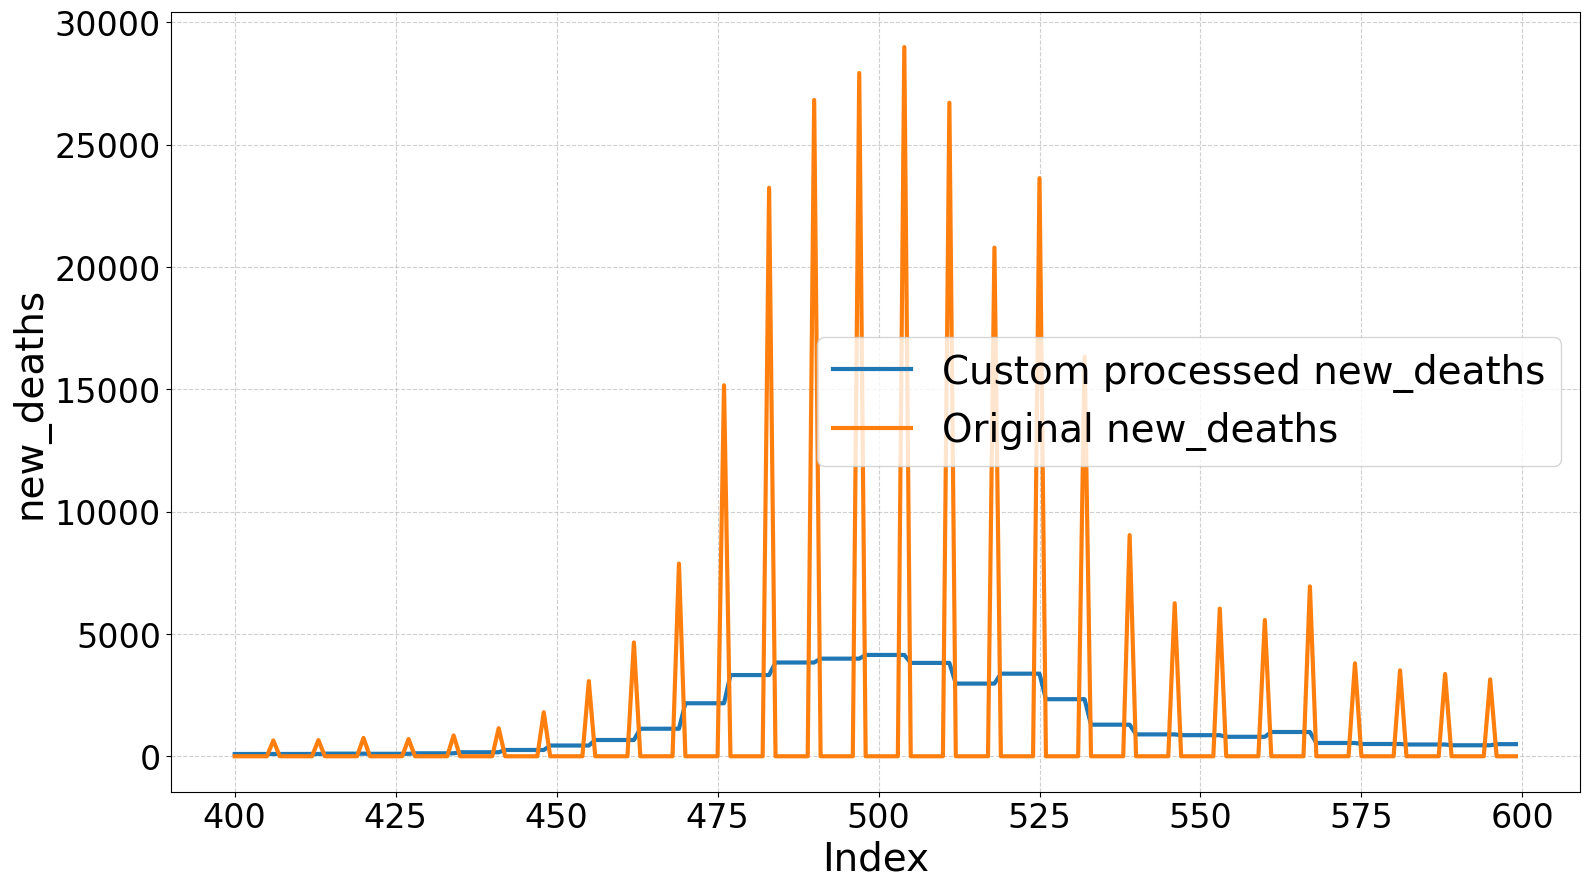

In [ ]:
# Visualizing weekly update pattern

def plot_weekly_pattern_comparison(original_data, processed_data, column, save_path):
    """
    Visualizes and compares the original and custom processed data for a specific column.

    Parameters:
    - original_data (DataFrame): The original dataset.
    - processed_data (DataFrame): The dataset after applying the custom preprocessing pipeline.
    - column (str): The column name to be visualized.
    - save_path (str): Path to save the plot.
    """
    # Set the figure size to be appropriate for a research paper
    fig, ax = plt.subplots(figsize=(16, 9))

    # Plot the data with increased line width
    ax.plot(processed_data[column].iloc[400:600], label=f"Custom processed {column}", linewidth=3)
    ax.plot(original_data[column].iloc[400:600], label=f"Original {column}", linewidth=3)

    # Add legend with larger font size and bold labels
    ax.legend(fontsize=28)

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add axis labels with larger font size and bold text
    ax.set_xlabel('Index', fontsize=28)
    ax.set_ylabel(f"{column}", fontsize=28)

    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=24)

    # Save the plot with high resolution
    plt.tight_layout()
    save_file(fig, save_path)

    # Display the plot
    plt.show()

# Call the function to generate and save the plot
plot_weekly_pattern_comparison(
    original_india_data,
    custom_processed_india_data,
    column='new_deaths',
    save_path='custom/plots/weekly_pattern_imputation_plot_new_deaths.pdf'
)


The comparison plot has been successfully generated and saved. The plot showcases the `new_deaths` column from both the original and custom-processed datasets, demonstrating the effect of the weekly pattern correction applied through the custom preprocessing pipeline. This visualization serves as a critical tool for evaluating the effectiveness of the preprocessing steps.


#### **Visualizing the Impact of Local Outlier Processing**

The following plot visualizes the impact of local outlier processing on the `new_vaccinations` column. This visualization highlights the effect of outlier detection and processing applied through the custom preprocessing pipeline.

The plot includes:
- **Input Data**: The original values for `new_vaccinations`.
- **Custom Processed Data**: The values after applying local outlier processing.
- **Local Outliers**: Marked in red to show where the outlier detection occurred.
- **Acceptable Range**: The shaded area representing the bounds used for identifying outliers.

This comparison helps to evaluate how effectively the outlier processing has adjusted the data.


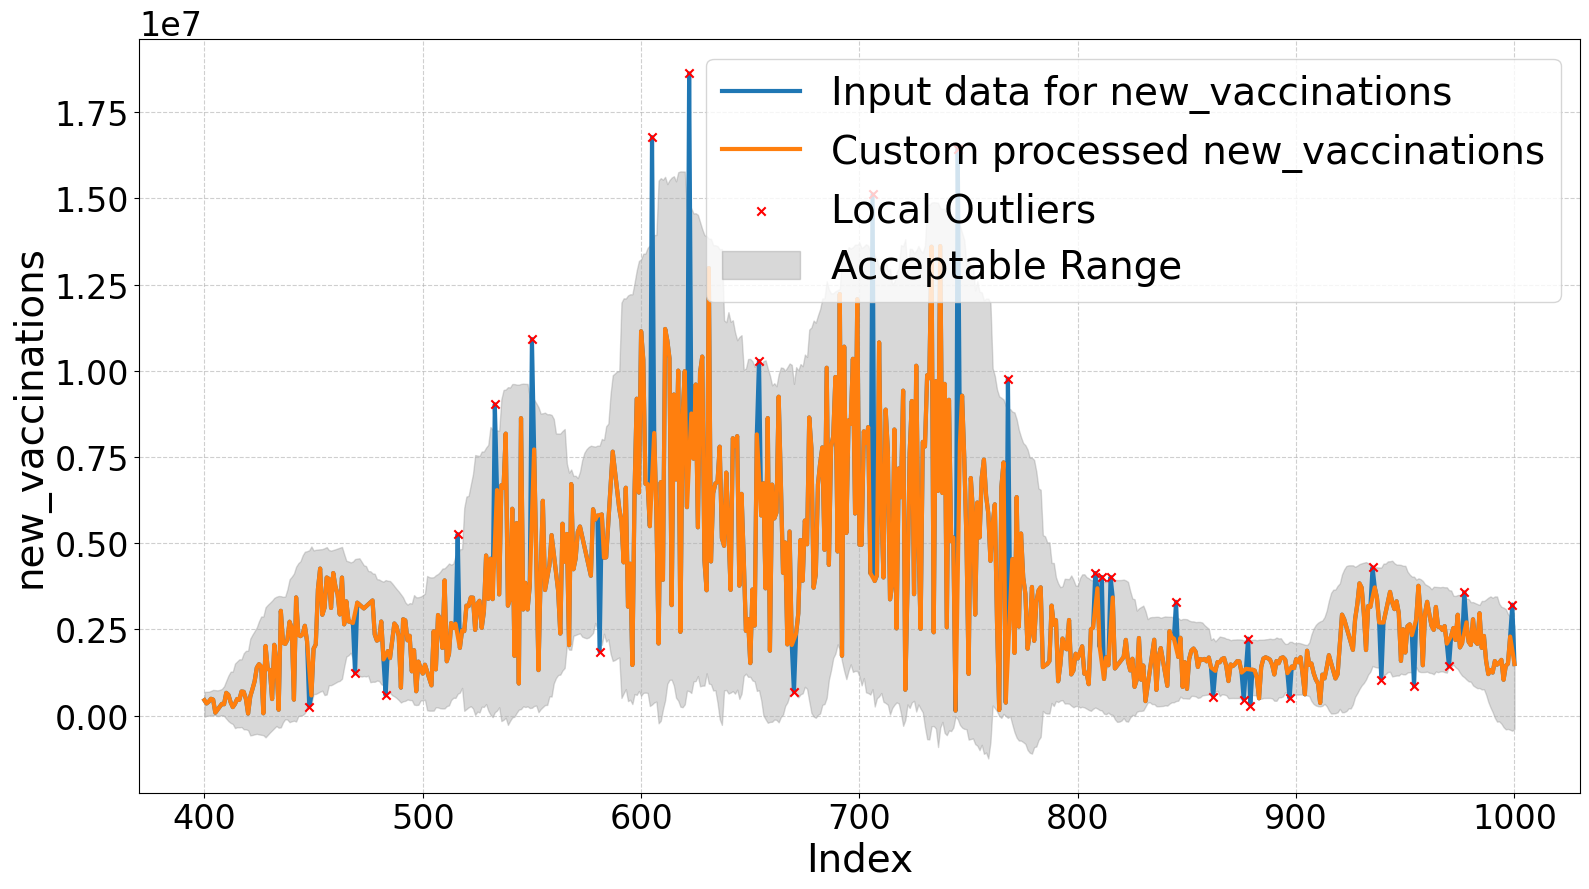

In [ ]:
# Visualizing local outliers detection and processing

def plot_local_outlier_processing(original_data, processed_data, column, outlier_processor, save_path, left_range=400, right_range=1000):
    """
    Visualizes the impact of local outlier processing on a specific column.

    Parameters:
    - original_data (DataFrame): The original dataset.
    - processed_data (DataFrame): The dataset after applying the custom preprocessing pipeline.
    - column (str): The column name to be visualized.
    - outlier_processor (CustomOutlierProcessor): The outlier processor instance used in the pipeline.
    - save_path (str): Path to save the plot.
    - left_range (int): Start index for the range to be plotted.
    - right_range (int): End index for the range to be plotted.
    """
    # Get the input and output data of the outlier processor for the column
    input_data = outlier_processor.get_input_data(column)
    output_data = outlier_processor.get_output_data(column)

    # Get the indices of the local outliers for the column
    outlier_indices = outlier_processor.get_local_outliers_indices(column)

    # Filter the outlier indices to be within the specified range
    filtered_outlier_indices = [idx for idx in outlier_indices if left_range <= (idx - input_data.index[0]) <= right_range]

    # Get the bounds for the column
    lower_bound, upper_bound = outlier_processor.get_bounds(column)

    # Set the figure size
    fig, ax = plt.subplots(figsize=(16, 9))

    # Plot the data with increased line width
    ax.plot(input_data.loc[left_range:right_range], label=f"Input data for {column}", linewidth=3)
    ax.plot(output_data.loc[left_range:right_range], label=f"Custom processed {column}", linewidth=3)

    # Highlight the outliers
    plt.scatter(filtered_outlier_indices, input_data.loc[filtered_outlier_indices], marker='x', color='red', label='Local Outliers', zorder=5)

    # Add shaded area for the bounds
    plt.fill_between(input_data.loc[left_range:right_range].index, lower_bound.loc[left_range:right_range], upper_bound.loc[left_range:right_range], color='gray', alpha=0.3, label='Acceptable Range')

    # Add legend with larger font size and bold labels
    ax.legend(fontsize=28)

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add axis labels with larger font size and bold text
    ax.set_xlabel('Index', fontsize=28)
    ax.set_ylabel(f"{column}", fontsize=28)

    # Customize ticks
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.yaxis.offsetText.set_fontsize(24)

    # Save the plot with high resolution
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')

    # Display the plot
    plt.show()

# Call the function to generate and save the plot
outlier_processor_custom = custom_preprocessing_pipeline.named_steps['feature_transformer'].named_transformers_['independent_columns_pipeline'].named_steps['custom_outlier_processor']
plot_local_outlier_processing(
    original_india_data,
    custom_processed_india_data,
    column='new_vaccinations',
    outlier_processor=outlier_processor_custom,
    save_path='custom/plots/local_outlier_processing_plot_new_vaccinations.pdf'
)


The plot demonstrating the impact of local outlier processing on the `new_vaccinations` column has been successfully generated and saved. This visualization provides a clear comparison between the original and processed data, highlighting detected outliers and the range used for their identification. This is an essential step in understanding the effectiveness of the outlier handling approach in the custom preprocessing pipeline.


#### **Extract Features and labels**

In this step, we extract the features and target label from the `custom_processed_india_data`.

- **Features (X_custom)**: All columns except the target column, which will be used as input for modeling.
- **Target Label (y_custom)**: The specified target column, which will be predicted by the model.

This separation prepares the data for the training and evaluation of machine learning models.


In [ ]:
# Extract features and target label from the processed data

# Features are all columns except the target column
X_custom = custom_processed_india_data.drop(target_column, axis=1)

# Target label is the specified target column
y_custom = custom_processed_india_data[target_column]


The features and target label have been successfully extracted from the `custom_processed_india_data`. The features are stored in `X_custom`, while the target label is stored in `y_custom`. This prepares the data for the next steps in the modeling process.


<div class="alert alert-info">

---

#### **Split the processed data into training, validation and test subsets**

In this step, we divide the dataset into three subsets: training, validation, and testing sets. This process ensures that the model is evaluated on separate data and helps in assessing its generalization ability.

- **Training Set**: Used to train the model (60% of the data).
- **Validation Set**: Used to tune hyperparameters and make decisions about the model (20% of the data).
- **Testing Set**: Used to evaluate the final performance of the model (20% of the data).

The split is done in two stages: first separating the training set from the temporary set, and then further dividing the temporary set into validation and testing sets.

---

</div>

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and testing sets
# Step 2: Divide the dataset into training (60%), validation (20%), and testing (20%) sets

# Split the original data into training (60%) and temporary (40%) sets
X_custom_train, X_custom_temp, y_custom_train, y_custom_temp = train_test_split(
    X_custom,
    y_custom,
    test_size=0.4,
    random_state=42
)

# Split the temporary data into validation (50% of 40%) and testing (50% of 40%) sets
X_custom_val, X_custom_test, y_custom_val, y_custom_test = train_test_split(
    X_custom_temp,
    y_custom_temp,
    test_size=0.5,
    random_state=42
)


The dataset has been successfully divided into training, validation, and testing sets. The training set will be used to fit the model, the validation set to tune hyperparameters, and the testing set to evaluate the final model performance. This preparation is crucial for ensuring that the model is trained and tested on distinct data subsets.


#### **Custom Feature Extraction Pipeline**

In this step, we refine the features of the `custom_processed_india_data` using a feature extraction pipeline. The pipeline is designed to normalize the features to ensure they are on a similar scale.

The pipeline includes:
- **Feature Selection** (Commented Out): Planned for future implementation, this step would involve selecting features based on correlation, permutation feature importance (PFI), mutual information (MI), single feature impact (SFI), and variance inflation factor (VIF).
- **Normalization**: Applies normalization to the features, transforming them to have a unit norm.

The processed data is then ready for further analysis or modeling.


In [ ]:
# Define the feature extraction pipeline
custom_feature_extraction_pipeline = Pipeline([
    ('iterative_feature_selector', IterativeFeatureSelector(
        approach='custom',
        target_column=target_column,
        correlation_threshold=0.8,
        vif_threshold=10,
        n_repeats=5,
        cv=cv,
        n_jobs=-1
    )),  # Step 5: Select features based on correlation, pfi, mi, sfi, and vif

    ('normalizer', Normalizer())  # Step 6: Normalize features
])

# Apply the feature extraction pipeline to the training data
X_custom_train = custom_feature_extraction_pipeline.fit_transform(X_custom_train, y_custom_train)

# Apply the same transformations to validation and test data
X_custom_val = custom_feature_extraction_pipeline.transform(X_custom_val)
X_custom_test = custom_feature_extraction_pipeline.transform(X_custom_test)



Initial number of features before iterative feature selection: 62

Dropping features ['icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'aged_65_older', 'male_smokers', 'human_development_index', 'population', 'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative', 'excess_mortality', 'excess_mortality_cumulative_per_million'] due to NaN correlation (empty columns).

Dropping features ['new_cases_smoothed', 'new_deaths_smoothed', 'new_cases_smoothed_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million'] due to high correlation with target (> 0.8).

Feature Importance Table after Round: 0
                                       feature  permutation_importance  single_feature_impact  mutual_information_importance  combined_importance                 vif
0                        new_cases_pe

The feature extraction pipeline has been applied to the `custom_processed_india_data`. Although feature selection was planned, it is currently commented out. The data has been normalized to ensure all features are on a comparable scale, making it suitable for subsequent analysis or modeling steps.


#### **Check Features and Number of Features**

In this step, we examine the features extracted from the processed data and determine the number of features available for modeling.

- **Feature List**: Displays all feature names present in the `X_custom` dataset.
- **Feature Count**: Shows the total number of features.

This information helps in understanding the dimensionality of the dataset and ensures that the feature extraction process has been correctly applied.


In [ ]:
# Check the features and number of features in the processed data

# List of feature names
custom_features = X_custom_train.columns

# Number of features
n_features_custom = len(custom_features)

# Print the list of custom features
print(f"\033[1mCustom features list:\033[0m {custom_features}")

# Print the number of custom features
print(f"\n\033[1mCustom features count:\033[0m {n_features_custom}")


Custom features list: Index(['new_cases', 'stringency_index', 'total_deaths_per_million', 'tests_per_case', 'new_people_vaccinated'], dtype='object')

Custom features count: 5


The features and their count have been successfully displayed. The list of features is shown along with the total number of features extracted. This confirms that the feature extraction process is complete and provides a clear view of the dataset’s dimensionality.


#### **Evaluate Models**

In this section, we evaluate various regression models using cross-validation with the custom preprocessing pipeline. The process involves the following steps:

1. **Model Evaluation**: Each model is evaluated using cross-validation, and if applicable, hyperparameter tuning is applied.
2. **Learning Curve**: A learning curve is plotted and saved for each model to visualize its performance over different training sizes.
3. **Results Collection**: The results are collected and stored for each model.

After evaluation, the results are organized in a DataFrame and saved to a CSV file for further analysis.



Evaluating Linear Regression with cross-validation...
Linear Regression Results:
[{'Approach': 'custom', 'Model Name': 'LinearRegression', 'Model Size (kB)': 0.6533203125, 'Best Hyperparameters': '-', 'Hyperparameter Tuning Time (s)': '-', 'Train RMSE': 400.0448949014361, 'Train R²': 0.6547475520575503, 'Training Time (s)': 0.011247873306274414, 'Validation RMSE': 401.5268157663017, 'Validation R²': 0.642590625452624, 'Validation Time (s)': 0.010819673538208008, 'Test RMSE': 406.20360717450774, 'Test R²': 0.6523700170707312, 'Test Time (s)': 0.002025127410888672}]
Plotting learning curve for LinearRegression()...


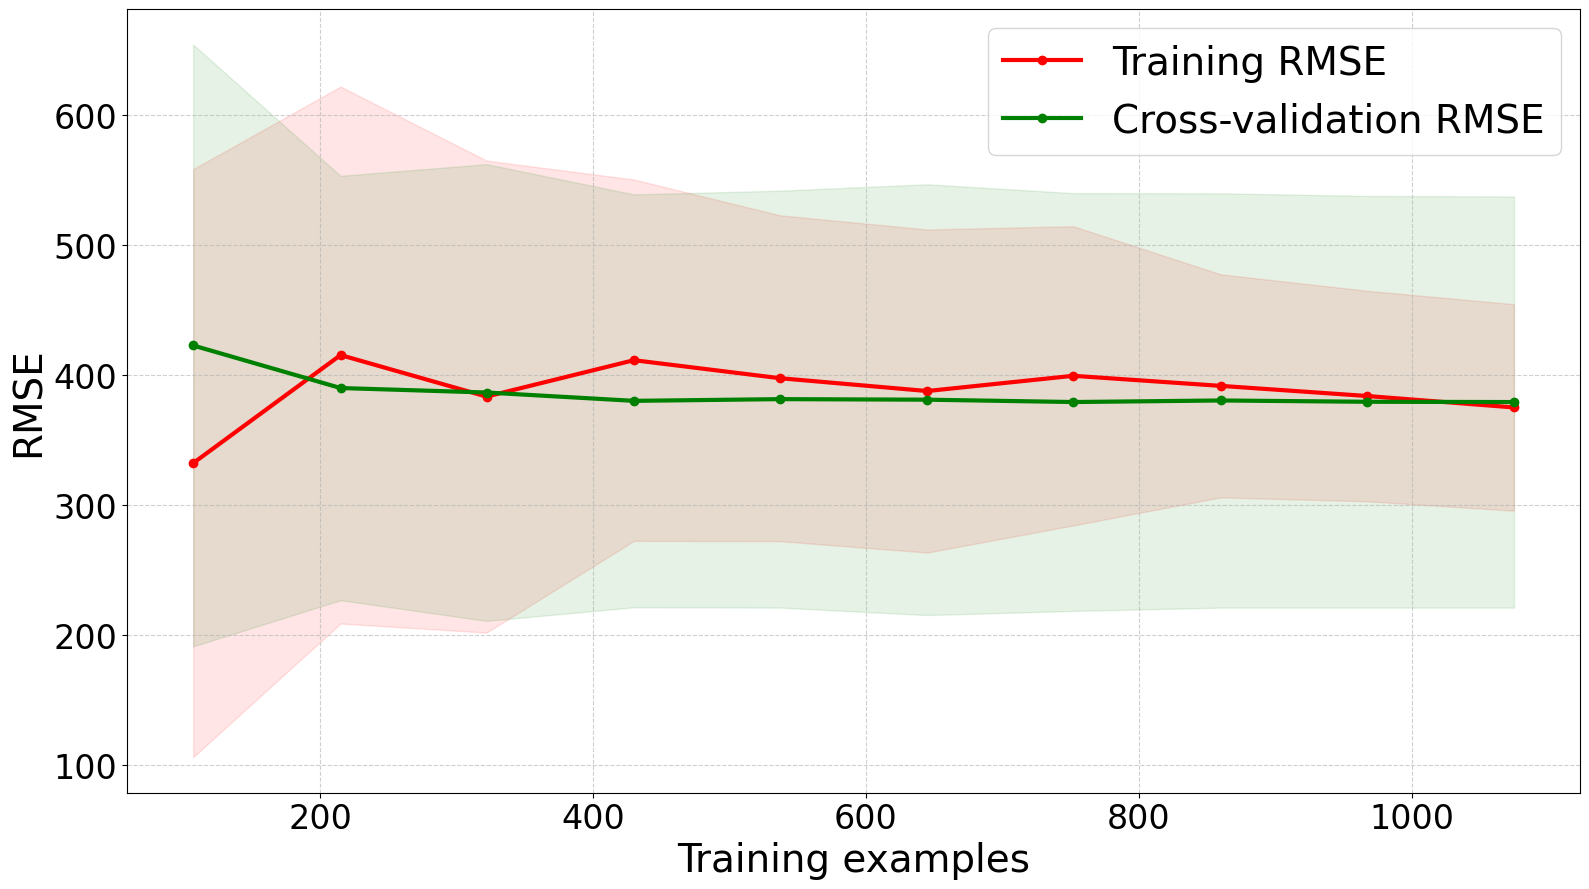


Evaluating Ridge with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Ridge Results:
[{'Approach': 'custom', 'Model Name': 'Ridge', 'Model Size (kB)': 0.6220703125, 'Best Hyperparameters': {'alpha': 10}, 'Hyperparameter Tuning Time (s)': 0.1260695457458496, 'Train RMSE': 400.094980534114, 'Train R²': 0.6546611046847264, 'Training Time (s)': 0.021375417709350586, 'Validation RMSE': 401.4453451699083, 'Validation R²': 0.6428744310468951, 'Validation Time (s)': 0.01692485809326172, 'Test RMSE': 406.1883966184492, 'Test R²': 0.652396051041134, 'Test Time (s)': 0.00455927848815918}]
Plotting learning curve for Ridge()...


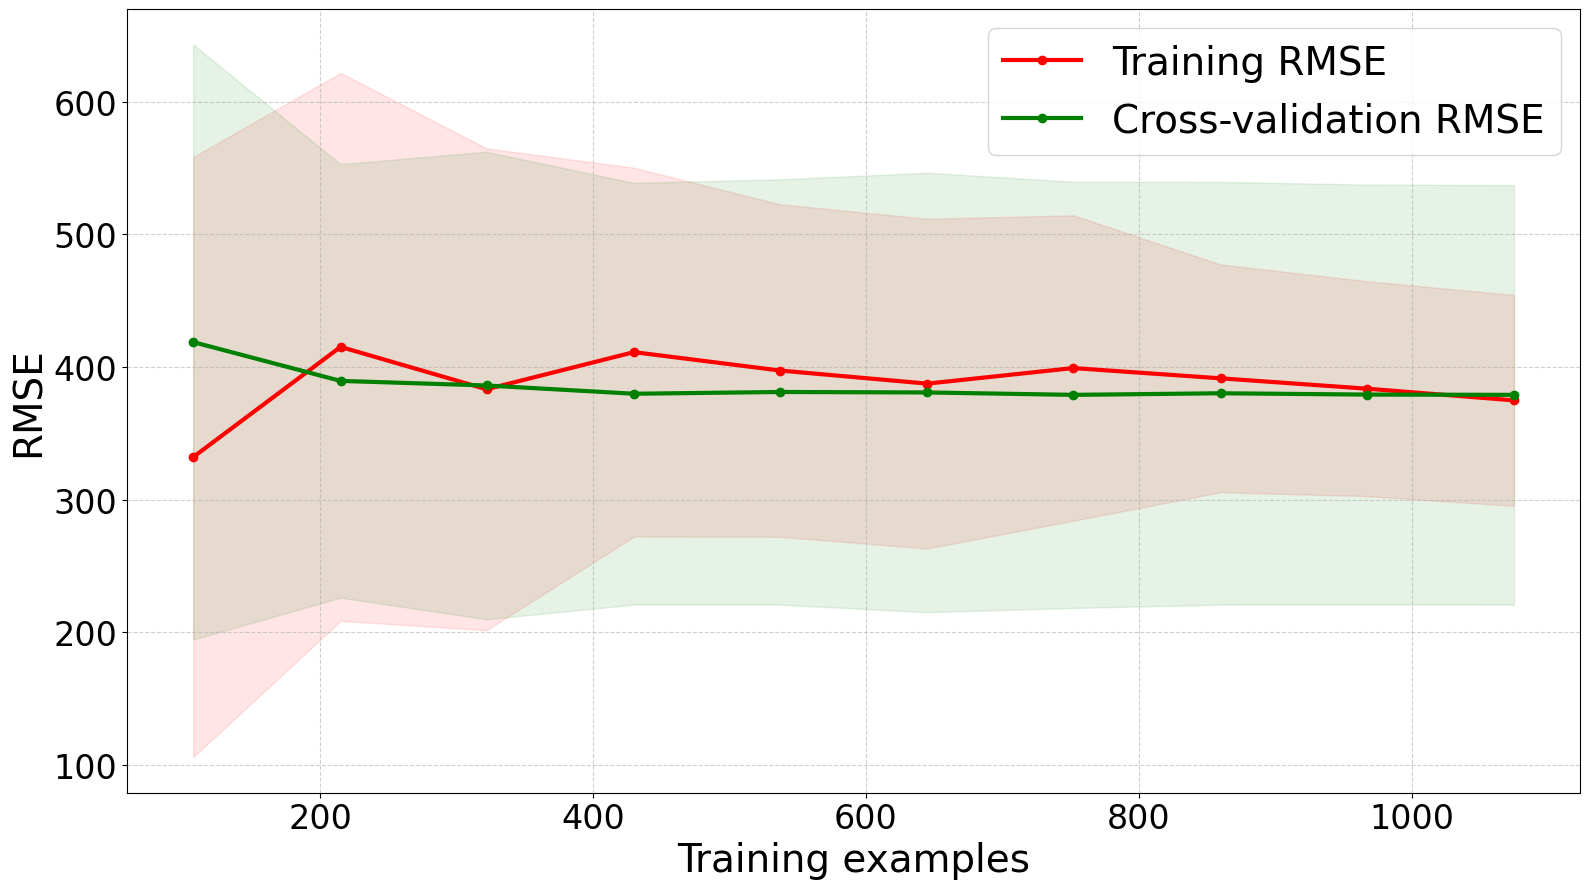


Evaluating Lasso with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Lasso Results:
[{'Approach': 'custom', 'Model Name': 'Lasso', 'Model Size (kB)': 0.7197265625, 'Best Hyperparameters': {'alpha': 10}, 'Hyperparameter Tuning Time (s)': 0.11463260650634766, 'Train RMSE': 400.32580142150437, 'Train R²': 0.6542624177070564, 'Training Time (s)': 0.02133655548095703, 'Validation RMSE': 401.2283540360148, 'Validation R²': 0.6431776318622985, 'Validation Time (s)': 0.016462326049804688, 'Test RMSE': 406.3216879558956, 'Test R²': 0.6521678800854896, 'Test Time (s)': 0.0027015209197998047}]
Plotting learning curve for Lasso()...


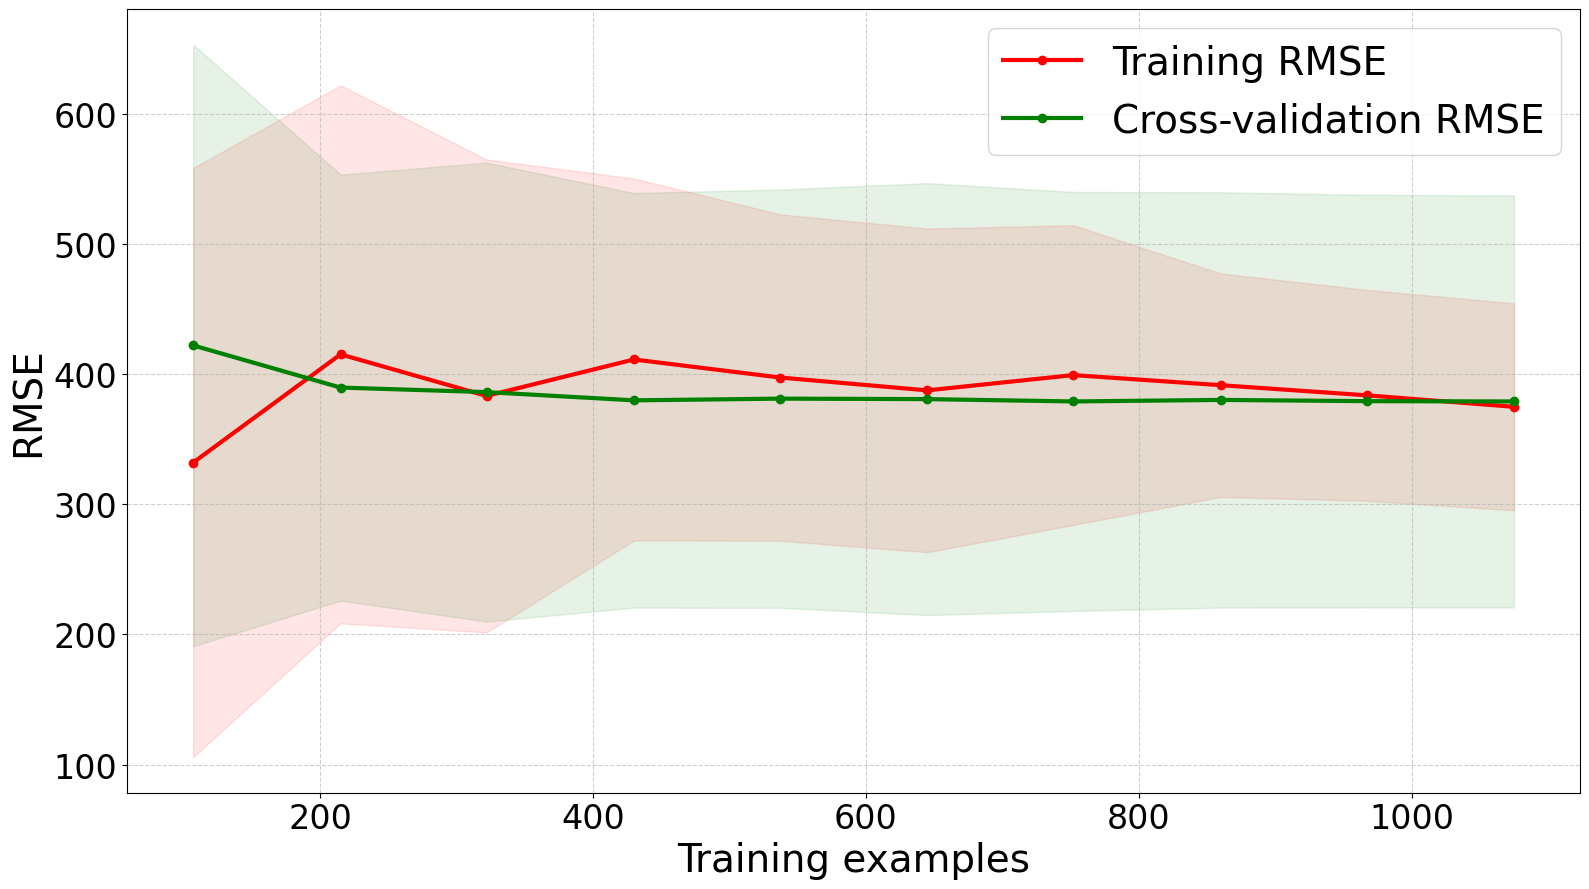


Evaluating ElasticNet with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
ElasticNet Results:
[{'Approach': 'custom', 'Model Name': 'ElasticNet', 'Model Size (kB)': 0.7314453125, 'Best Hyperparameters': {'alpha': 0.1, 'l1_ratio': 0.7}, 'Hyperparameter Tuning Time (s)': 0.4574880599975586, 'Train RMSE': 400.3264041034025, 'Train R²': 0.6542615780840413, 'Training Time (s)': 0.022865772247314453, 'Validation RMSE': 401.5081401554068, 'Validation R²': 0.6429606721085497, 'Validation Time (s)': 0.016996145248413086, 'Test RMSE': 406.34185537189205, 'Test R²': 0.6521333505520892, 'Test Time (s)': 0.0028028488159179688}]
Plotting learning curve for ElasticNet()...


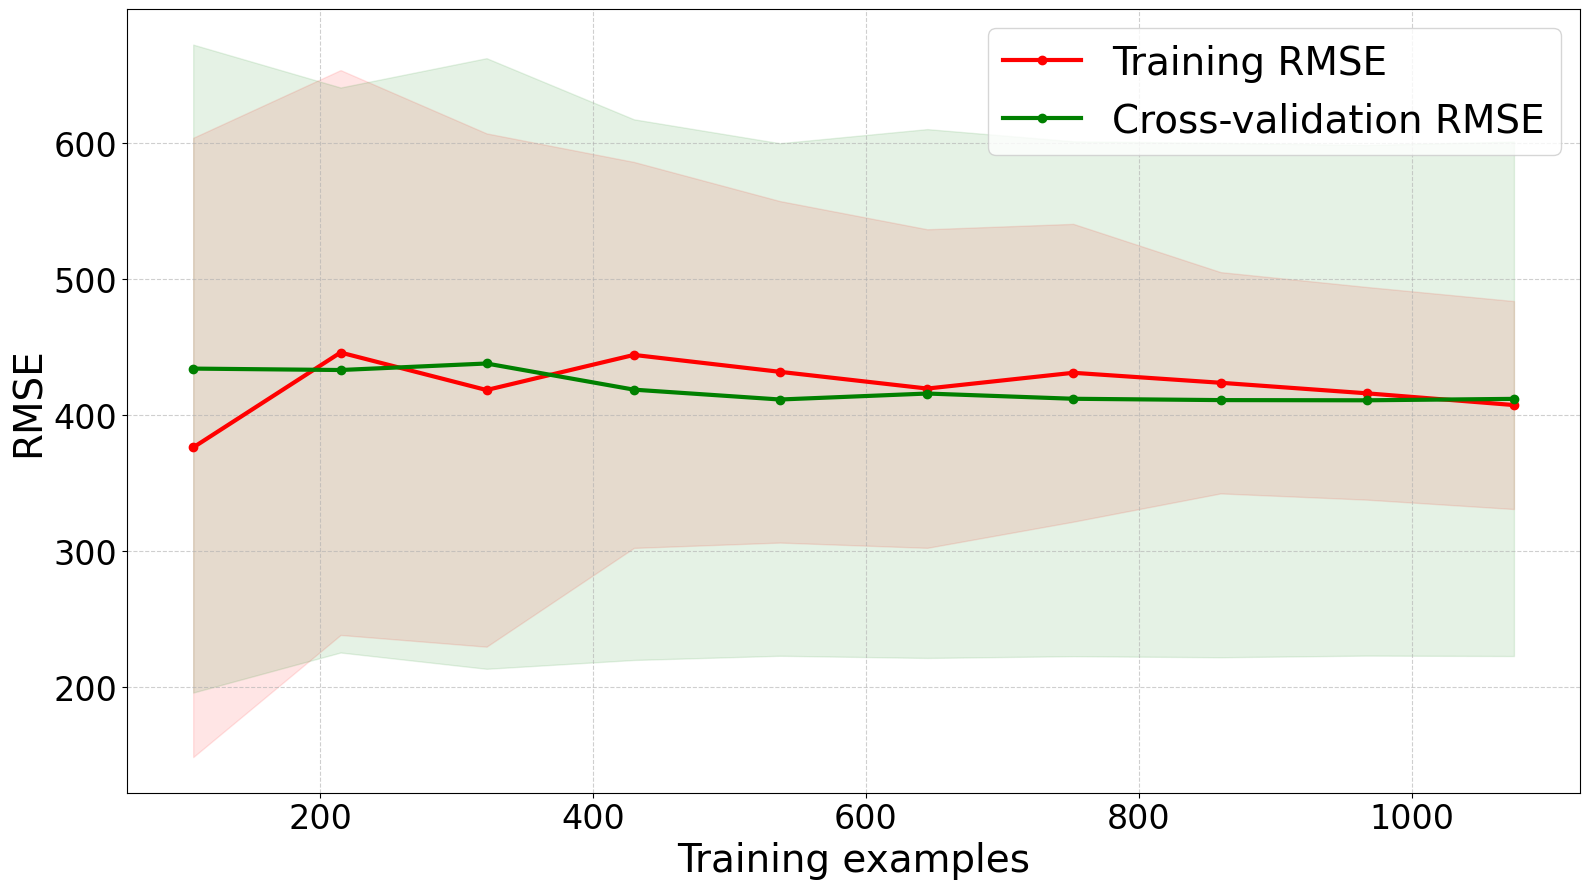


Evaluating SVR with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
SVR Results:
[{'Approach': 'custom', 'Model Name': 'SVR', 'Model Size (kB)': 13.5830078125, 'Best Hyperparameters': {'C': 1000, 'epsilon': 50}, 'Hyperparameter Tuning Time (s)': 10.47474718093872, 'Train RMSE': 247.56756281113516, 'Train R²': 0.8672675174381805, 'Training Time (s)': 0.3772013187408447, 'Validation RMSE': 276.30206199803564, 'Validation R²': 0.8321819874582184, 'Validation Time (s)': 0.06568217277526855, 'Test RMSE': 208.73729133287506, 'Test R²': 0.9082027306140279, 'Test Time (s)': 0.00668644905090332}]
Plotting learning curve for SVR()...


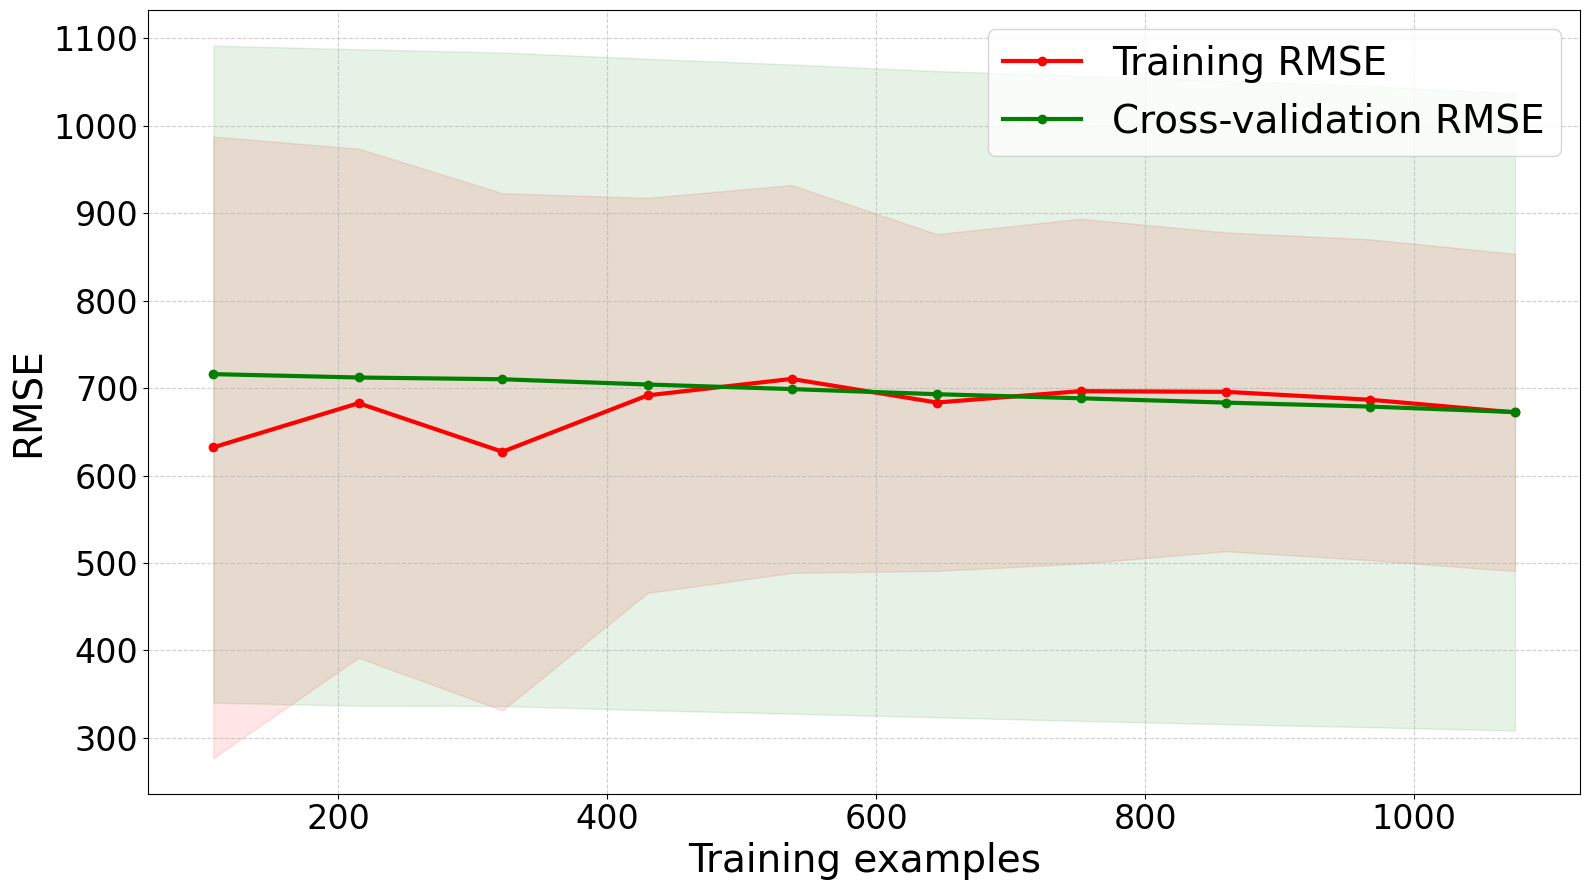


Evaluating Random Forest with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Random Forest Results:
[{'Approach': 'custom', 'Model Name': 'RandomForestRegressor', 'Model Size (kB)': 148.494140625, 'Best Hyperparameters': {'bootstrap': False, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 8}, 'Hyperparameter Tuning Time (s)': 28.29207491874695, 'Train RMSE': 34.537548297224205, 'Train R²': 0.9973482601215136, 'Training Time (s)': 0.4223904609680176, 'Validation RMSE': 65.3125100673765, 'Validation R²': 0.9881820719915426, 'Validation Time (s)': 0.046051979064941406, 'Test RMSE': 144.04609529338063, 'Test R²': 0.9562847812345593, 'Test Time (s)': 0.01000070571899414}]
Plotting learning curve for RandomForestRegressor(random_state=42)...


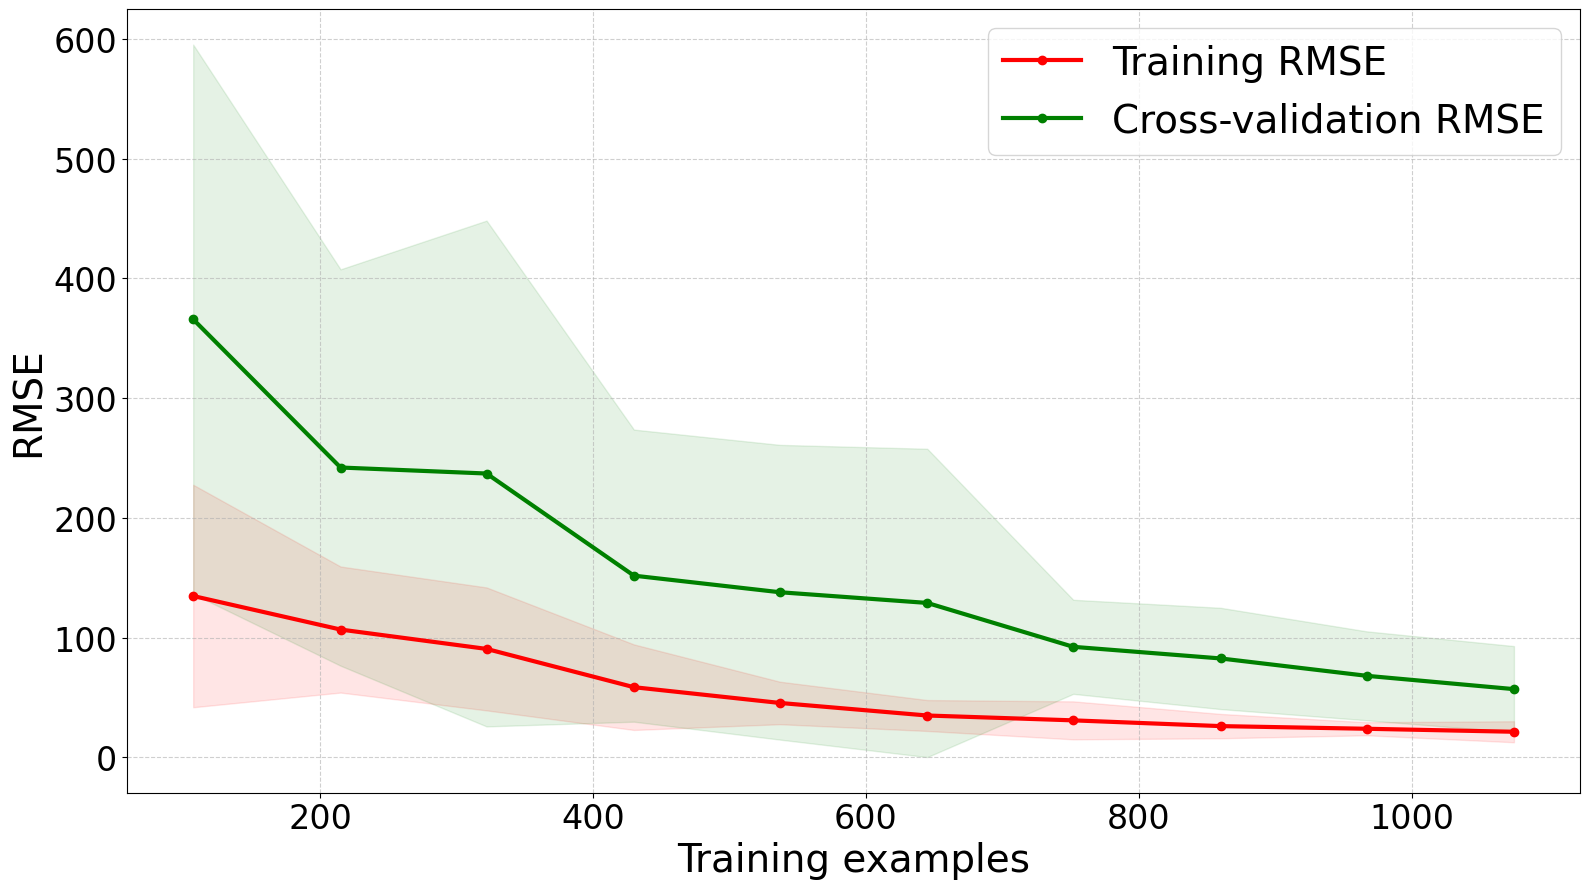


Evaluating Gradient Boosting with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Gradient Boosting Results:
[{'Approach': 'custom', 'Model Name': 'GradientBoostingRegressor', 'Model Size (kB)': 623.9140625, 'Best Hyperparameters': {'learning_rate': 0.01, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'n_iter_no_change': 10, 'subsample': 1.0, 'tol': 0.001, 'validation_fraction': 0.2}, 'Hyperparameter Tuning Time (s)': 26.417964935302734, 'Train RMSE': 68.68947308767393, 'Train R²': 0.9897992346770726, 'Training Time (s)': 5.192131757736206, 'Validation RMSE': 93.3140506236397, 'Validation R²': 0.9796955577897751, 'Validation Time (s)': 0.032244205474853516, 'Test RMSE': 86.92625269330557, 'Test R²': 0.9840804205145457, 'Test Time (s)': 0.0072858333587646484}]
Plotting learning curve for GradientBoostingRegressor(random_state=42)...


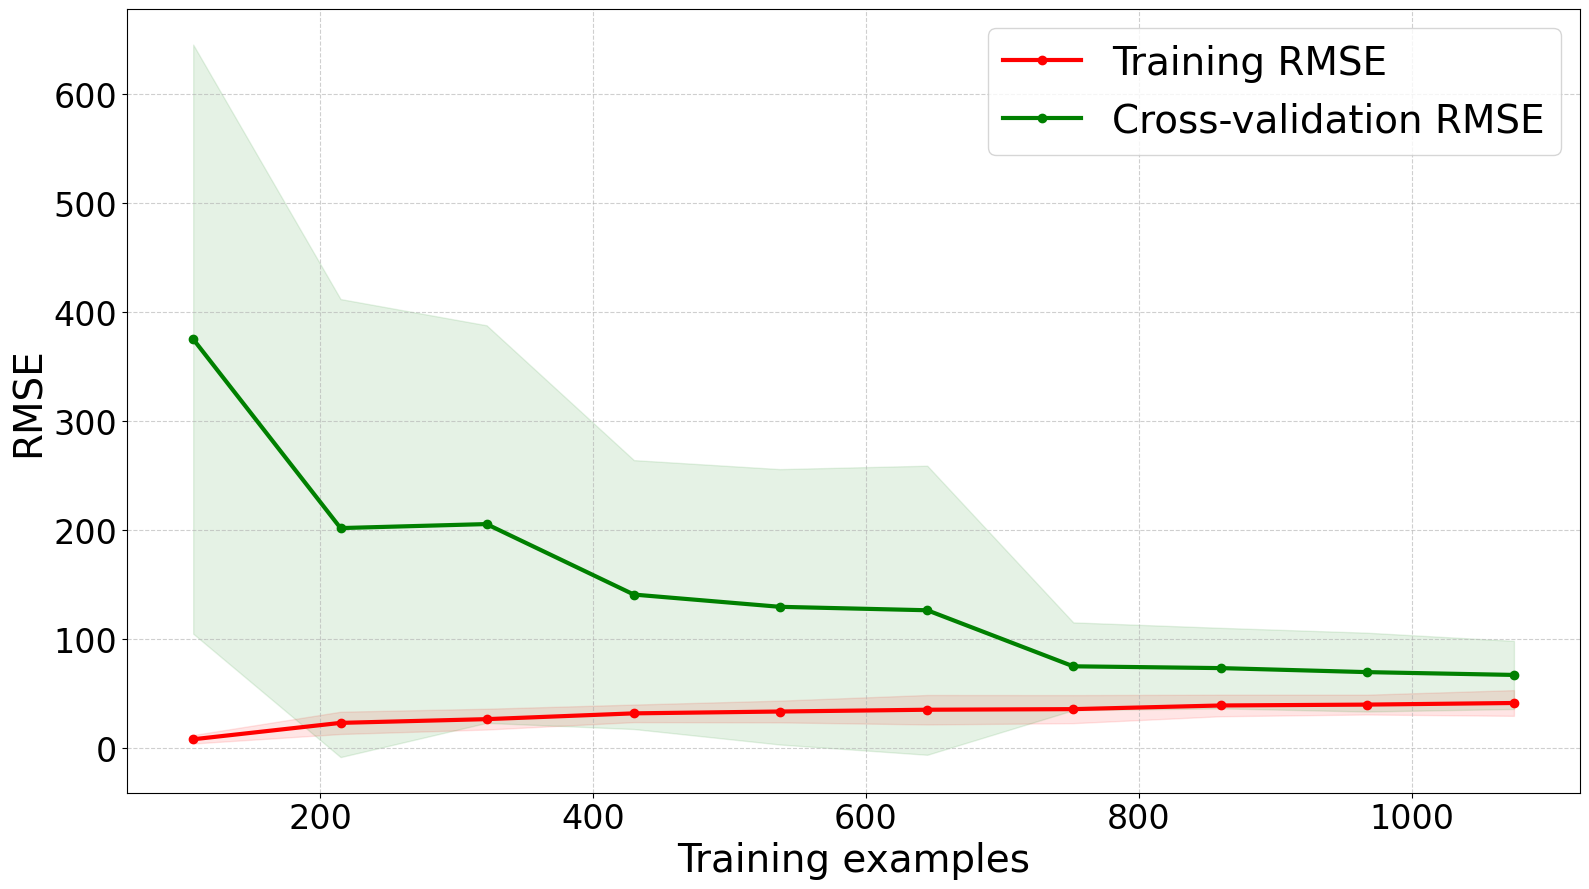


Evaluating Decision Tree with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Decision Tree Results:
[{'Approach': 'custom', 'Model Name': 'DecisionTreeRegressor', 'Model Size (kB)': 6.7451171875, 'Best Hyperparameters': {'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 40, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}, 'Hyperparameter Tuning Time (s)': 3.5997250080108643, 'Train RMSE': 47.266060879987165, 'Train R²': 0.9951322305593309, 'Training Time (s)': 0.045295000076293945, 'Validation RMSE': 73.9695440958346, 'Validation R²': 0.9850448810191719, 'Validation Time (s)': 0.02429819107055664, 'Test RMSE': 146.77538835428845, 'Test R²': 0.954612511489962, 'Test Time (s)': 0.0035130977630615234}]
Plotting learning curve for DecisionTreeRegressor(random_state=42)...


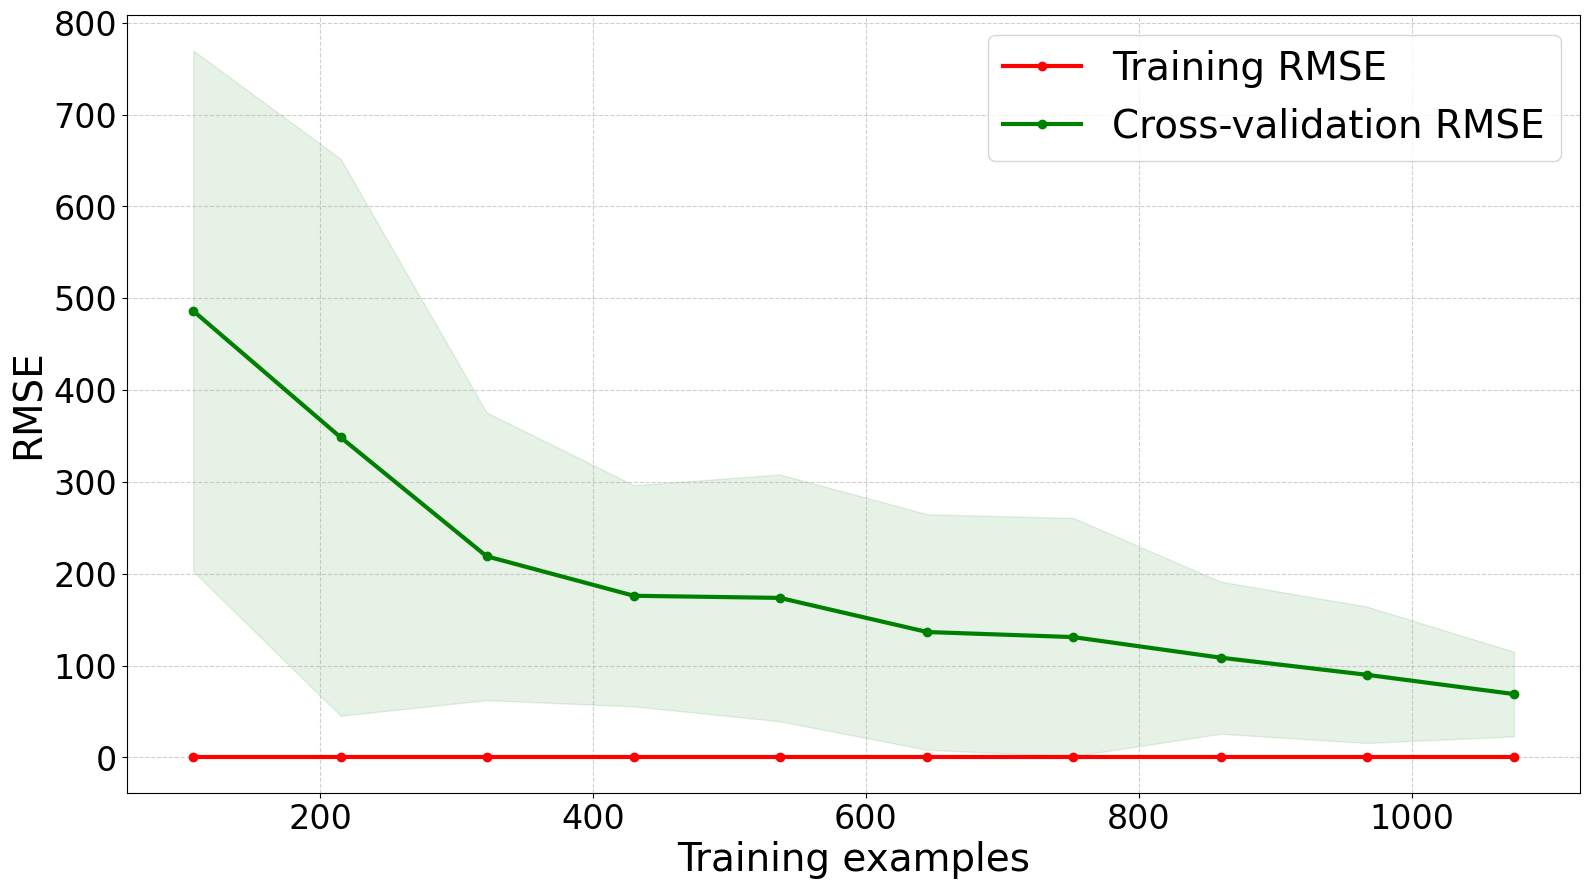


Evaluating KNeighbors with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
KNeighbors Results:
[{'Approach': 'custom', 'Model Name': 'KNeighborsRegressor', 'Model Size (kB)': 112.2607421875, 'Best Hyperparameters': {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}, 'Hyperparameter Tuning Time (s)': 12.277416229248047, 'Train RMSE': 52.596527245058155, 'Train R²': 0.9937649424613204, 'Training Time (s)': 0.022221088409423828, 'Validation RMSE': 82.10398403898795, 'Validation R²': 0.98326200377539, 'Validation Time (s)': 0.022667884826660156, 'Test RMSE': 84.51012967020701, 'Test R²': 0.9849530938636358, 'Test Time (s)': 0.0042362213134765625}]
Plotting learning curve for KNeighborsRegressor()...


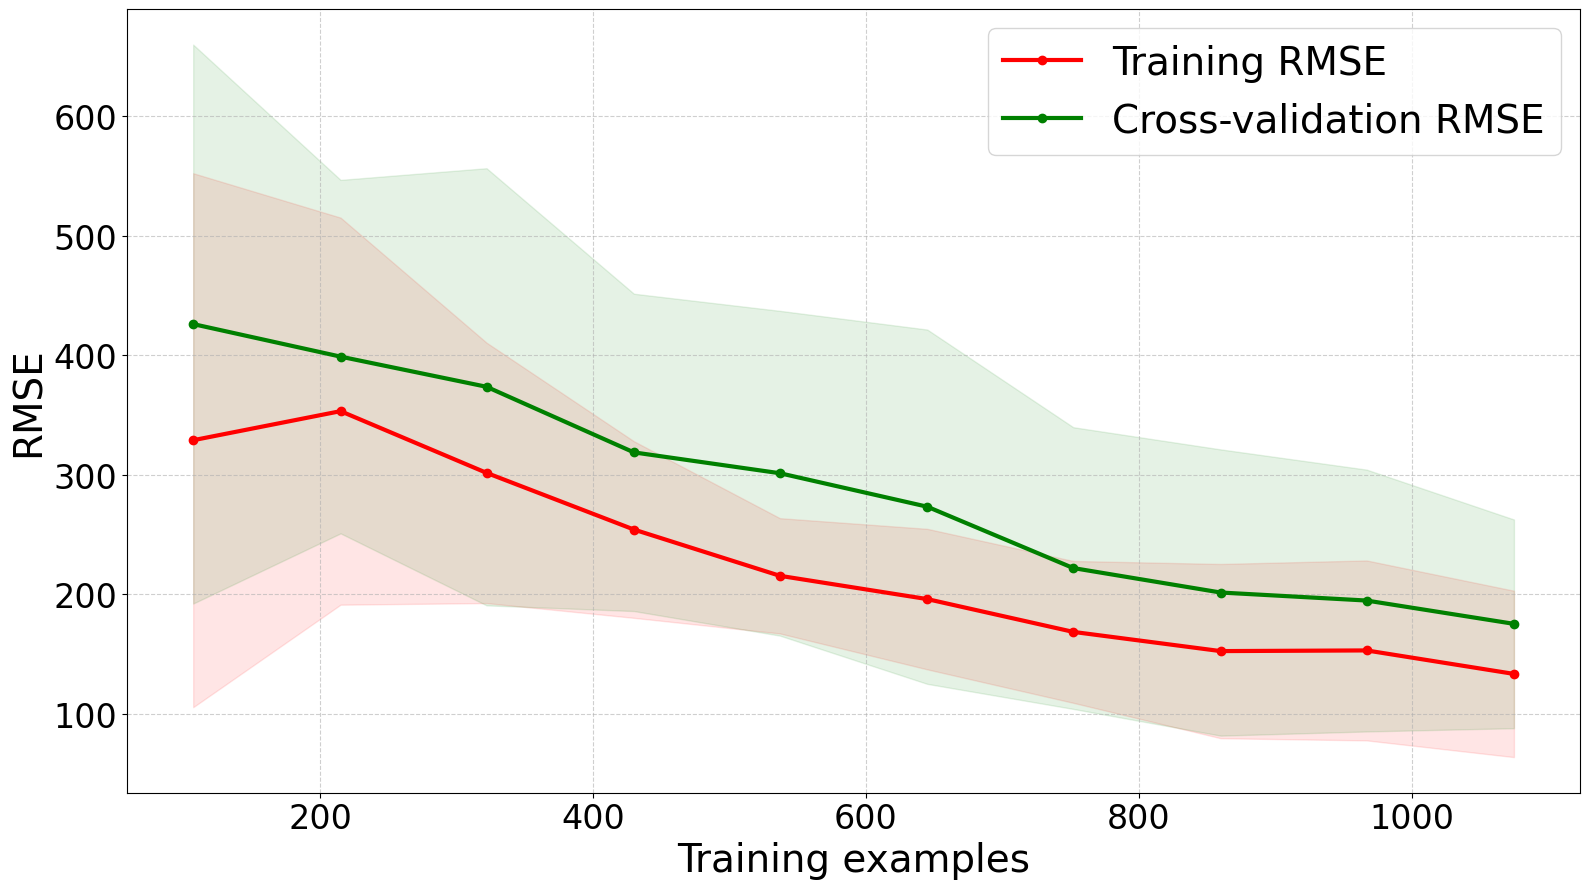


Evaluating Neural Network with cross-validation...
Starting hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Neural Network Results:
[{'Approach': 'custom', 'Model Name': 'MLPRegressor', 'Model Size (kB)': 13.10546875, 'Best Hyperparameters': {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (30, 15, 30), 'solver': 'lbfgs', 'tol': 0.001}, 'Hyperparameter Tuning Time (s)': 13.31163740158081, 'Train RMSE': 71.39011505351816, 'Train R²': 0.9889739931425547, 'Training Time (s)': 4.383149862289429, 'Validation RMSE': 83.70493524877313, 'Validation R²': 0.9845634822836379, 'Validation Time (s)': 0.03153681755065918, 'Test RMSE': 66.55556213669244, 'Test R²': 0.9906674916438777, 'Test Time (s)': 0.0035974979400634766}]
Plotting learning curve for MLPRegressor(random_state=42)...


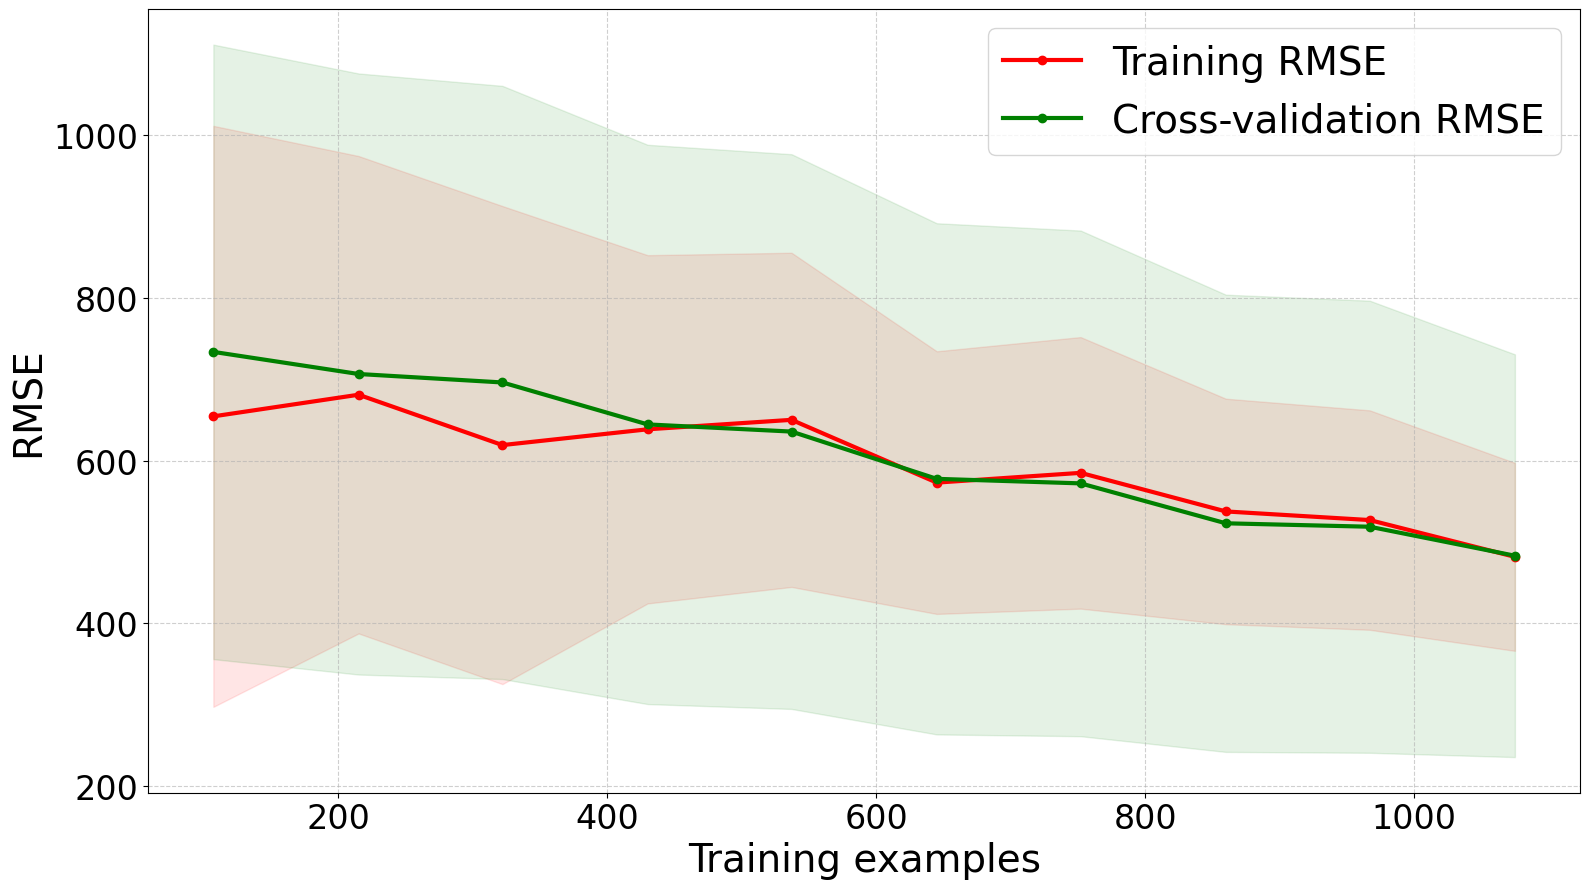

Results with Custom Preprocessing Pipeline:


Approach                 Model Name  Model Size (kB)                               Best Hyperparameters Hyperparameter Tuning Time (s)  Train RMSE  Train R²  Training Time (s)  Validation RMSE  Validation R²  Validation Time (s)  Test RMSE  Test R²  Test Time (s)
9   custom               MLPRegressor           13.105  {'activation': 'relu', 'early_stopping': True,...                         13.312      71.390     0.989              4.383           83.705          0.985                0.032     66.556    0.991          0.004
8   custom        KNeighborsRegressor          112.261  {'algorithm': 'auto', 'leaf_size': 2, 'n_neigh...                         12.277      52.597     0.994              0.022           82.104          0.983                0.023     84.510    0.985          0.004
6   custom  GradientBoostingRegressor          623.914  {'learning_rate': 0.01, 'max_depth': 3, 'max_f...                         26.418      68.689     0.990              5.192           93.314          0.980                0.032     86.926    0.984          0.007
5   custom      RandomForestRegressor          148.494  {'bootstrap': False, 'max_depth': 9, 'max_feat...                         28.292      34.538     0.997              0.422           65.313          0.988                0.046    144.046    0.956          0.010
7   custom      DecisionTreeRegressor            6.745  {'criterion': 'friedman_mse', 'max_depth': 10,...                          3.600      47.266     0.995              0.045           73.970          0.985                0.024    146.775    0.955          0.004
4   custom                        SVR           13.583                         {'C': 1000, 'epsilon': 50}                         10.475     247.568     0.867              0.377          276.302          0.832                0.066    208.737    0.908          0.007
1   custom                      Ridge            0.622                                      {'alpha': 10}                          0.126     400.095     0.655              0.021          401.445          0.643                0.017    406.188    0.652          0.005
0   custom           LinearRegression            0.653                                                  -                              -     400.045     0.655              0.011          401.527          0.643                0.011    406.204    0.652          0.002
2   custom                      Lasso            0.720                                      {'alpha': 10}                          0.115     400.326     0.654              0.021          401.228          0.643                0.016    406.322    0.652          0.003
3   custom                 ElasticNet            0.731                    {'alpha': 0.1, 'l1_ratio': 0.7}                          0.457     400.326     0.654              0.023          401.508          0.643                0.017    406.342    0.652          0.003

In [ ]:
# Initialize a list to store results from all evaluated models
all_custom_results = []

# Evaluate each regression model using cross-validation
for model_name, model in regression_models.items():
    print(f"\nEvaluating {model_name} with cross-validation...")

    # Check if hyperparameter space is provided for the current model
    if model_name in hyperparameter_space:
        model_hyperparameter_space = hyperparameter_space[model_name]
        # Evaluate model with hyperparameter tuning
        model_results = evaluate_model(
            'custom',
            model,
            X_custom_train,
            y_custom_train,
            X_custom_val,
            y_custom_val,
            X_custom_test,
            y_custom_test,
            model_hyperparameter_space=model_hyperparameter_space,
            cv=cv,
            n_jobs=-1
        )
    else:
        # Evaluate model without hyperparameter tuning
        model_results = evaluate_model(
            'custom',
            model,
            X_custom_train,
            y_custom_train,
            X_custom_val,
            y_custom_val,
            X_custom_test,
            y_custom_test,
            cv=cv,
            n_jobs=-1
        )

    print(f"{model_name} Results:")
    print(model_results)
    # Append the results to the list
    all_custom_results.extend(model_results)

    # Plot and save the learning curve for the model
    plot_learning_curve(
        'custom',
        model,
        X_custom_train,
        y_custom_train,
        X_custom_val,
        y_custom_val,
        cv=cv,
        n_jobs=-1
    )

# Convert results list to DataFrame for better readability
custom_results_df = pd.DataFrame(all_custom_results)
# Sort results by Test RMSE
custom_results_df.sort_values(by='Test RMSE', inplace=True)

# Save the results to a CSV file
save_file(custom_results_df, 'custom/tables/custom_results_df.csv')

print("Results with Custom Preprocessing Pipeline:")
# Display the sorted results DataFrame
custom_results_df


The above sections detail the implementation of each model, from pipeline construction to hyperparameter tuning and evaluation. This structured approach enables a comprehensive comparison and selection of the most suitable model for predicting COVID-19 mortality in India.


### **Visualizing the impact of Computation Processing**

This plot illustrates the effect of computational processing on the `positive_rate` column. In the standard preprocessing pipeline, missing values are handled using linear interpolation or extrapolation, resulting in constant values beyond the last valid data point. Conversely, the custom pipeline computes missing values based on new cases and new tests, providing a more accurate representation of the data.

The equation used in the custom pipeline is:

$$
X_{positive\_rate}^{t}=\frac{\sum_{i=0}^{6}\frac{X_{new\_cases}^{t-i}}{X_{new\_tests}^{t-i}}}{7}
$$


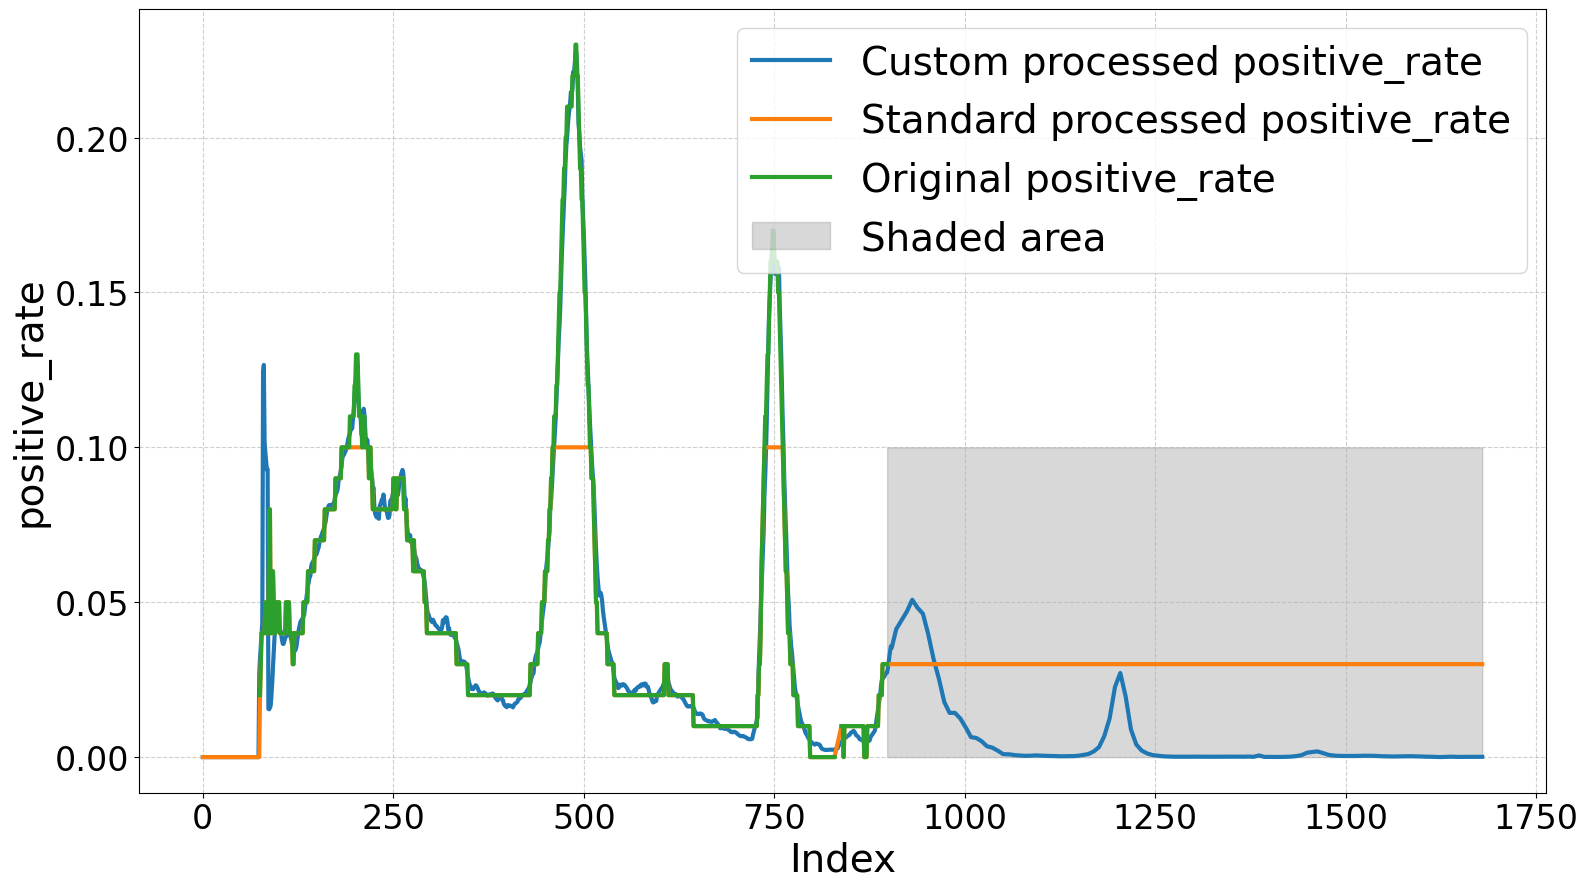

In [ ]:
# Customize the plot for positive_rate
column = 'positive_rate'

# Get the last valid index in the original data for the specified column
last_valid_index = original_india_data[column].last_valid_index()

# Retrieve the custom computation processor from the preprocessing pipeline
custom_computation_processor = custom_preprocessing_pipeline.named_steps['computation_processor']

# Obtain the output data for the specified column from the custom computation processor
output_data_custom = custom_computation_processor.get_output_data(column)

# Retrieve the standard outlier processor from the standard preprocessing pipeline
standard_outlier_processor = standard_preprocessing_pipeline.named_steps['standard_outlier_processor']

# Obtain the output data for the specified column from the standard outlier processor
output_data_standard = standard_outlier_processor.get_output_data(column)

# Set the figure size to be appropriate for a research paper
fig, ax = plt.subplots(figsize=(16, 9))

# Plot the custom processed data with increased line width
ax.plot(output_data_custom, label=f"Custom processed {column}", linewidth=3)
# Plot the standard processed data with increased line width
ax.plot(output_data_standard, label=f"Standard processed {column}", linewidth=3)
# Plot the original data with increased line width
ax.plot(original_india_data[column], label=f"Original {column}", linewidth=3)

# Determine the y-range for shading
y_min = 0.0
y_max = 0.1

# Add shaded area from last valid index to the end of the x-axis
ax.fill_between(
    output_data_custom.index,
    y_min,  # Minimum y value for shading
    y_max,  # Maximum y value for shading
    where=(output_data_custom.index >= last_valid_index),
    color='gray', alpha=0.3, label='Shaded area'
)

# Add legend with larger font size
ax.legend(fontsize=28)

# Add grid with dashed lines and reduced alpha for better visibility
ax.grid(True, linestyle='--', alpha=0.6)

# Add axis labels with larger font size and bold text
ax.set_xlabel('Index', fontsize=28)
ax.set_ylabel(f"{column}", fontsize=28)

# Customize tick parameters for both x and y axes
ax.tick_params(axis='both', which='major', labelsize=24)

# Adjust layout for tight fit
plt.tight_layout()

# Save the plot with high resolution
save_file(fig, f"custom/plots/computation_processing_plot_{column}.pdf")

# Display the plot
plt.show()


This plot visually contrasts the outcomes of the custom processing approach with the standard method. The shaded area highlights the extrapolated region, showing how the custom method maintains a meaningful trend in contrast to the constant values produced by the standard approach.

### **Variance Analysis for Standard Pipeline Results**

To evaluate the consistency of model performance across different data splits, we calculated the variances in Root Mean Squared Error (RMSE) and (R²) using the standard pipeline. This analysis helps us understand how stable and reliable each model is when applied to the training, validation, and test datasets. The table below summarizes the RMSE and (R²) variances for each model evaluated using the standard pipeline.


In [ ]:
# Display Variance Table for Results using Standard Pipeline
standard_variance_table = calculate_variance_table(standard_results_df)
standard_variance_table


Approach                 Model Name  RMSE Variance  R² Variance
0  standard      DecisionTreeRegressor        776.666        0.002
1  standard      RandomForestRegressor       3740.121        0.008
2  standard  GradientBoostingRegressor       1762.070        0.005
3  standard                        SVR        746.453        0.002
4  standard        KNeighborsRegressor       8318.961        0.028
5  standard                      Ridge       1437.239        0.005
6  standard                 ElasticNet       1437.262        0.005
7  standard           LinearRegression       1438.698        0.005
8  standard                      Lasso       1441.244        0.005
9  standard               MLPRegressor      13739.921        0.055

### **Variance Analysis for Custom Pipeline Results**

Similarly, we performed a variance analysis on the results obtained from the custom pipeline. By comparing these variances with those from the standard pipeline, we can gain insights into the effectiveness of the custom pipeline in producing stable and consistent model performance across different datasets. The table below presents the RMSE and (R²) variances for each model evaluated using the custom pipeline.


In [ ]:
# Display Variance table for Results using Custom Pipeline
custom_variance_table = calculate_variance_table(custom_results_df)
custom_variance_table

Approach                 Model Name  RMSE Variance  R² Variance
0   custom               MLPRegressor         52.125        0.000
1   custom        KNeighborsRegressor        210.551        0.000
2   custom  GradientBoostingRegressor        108.862        0.000
3   custom      RandomForestRegressor       2126.466        0.000
4   custom      DecisionTreeRegressor       1768.430        0.000
5   custom                        SVR        766.496        0.001
6   custom                      Ridge          6.828        0.000
7   custom           LinearRegression          6.889        0.000
8   custom                      Lasso          6.967        0.000
9   custom                 ElasticNet          6.772        0.000

---

### **Discussion**

In this section, we present the performance metrics of various regression models and their detailed analysis, evaluated using both the standard and custom preprocessing pipelines. The performance is measured in terms of Root Mean Squared Error (RMSE), R², and their variances across the training, validation, and testing datasets.

---

### 1. **Test Results: Test RMSE and R²**

**Custom Pipeline:**
- **Best Test RMSE:** `MLPRegressor` with **66.556** RMSE.
- **Best Test R²:** `MLPRegressor` with **0.991** R².
- **Worst Test RMSE:** `ElasticNet` with **406.342** RMSE.
- **Worst Test R²:** `ElasticNet` with **0.652** R².

**Standard Pipeline:**
- **Best Test RMSE:** `DecisionTreeRegressor` with **222.858** RMSE.
- **Best Test R²:** `DecisionTreeRegressor` with **0.817** R².
- **Worst Test RMSE:** `MLPRegressor` with **419.340** RMSE.
- **Worst Test R²:** `MLPRegressor` with **0.350** R².

**Comparison:**
- The **Custom Pipeline** outperforms the **Standard Pipeline** across all models, showing significantly lower RMSE and higher R² values. The **MLPRegressor** with the Custom Pipeline demonstrates the best performance with the lowest RMSE and highest R². Conversely, the same model with the same hyperparameter space fails to generalize for the test data in the **Standard Pipeline**.

---

### 2. **Generalizability: Overfitting and Underfitting**

#### RMSE Variance:
- **Custom Pipeline:** Generally shows lower RMSE variance, indicating better generalization across different data splits. For instance, `MLPRegressor` has RMSE variance of **52.125**, indicating high stability in the model's performance across different datasets..
- **Standard Pipeline:** Exhibits higher RMSE variances, suggesting weaker generalization. Notably, `MLPRegressor` shows a significant RMSE variance of **13,739.921**, indicating instability in the model's performance across different datasets.

#### R² Variance:
- **Custom Pipeline:** Displays very low R² variances across all models, with most models showing near-zero variance. This suggests that the models in the Custom Pipeline are highly consistent in capturing the variance in the data across training, validation, and testing datasets.
- **Standard Pipeline:** While the R² variances are still relatively low, they are higher than those in the Custom Pipeline. For instance, `MLPRegressor` in the Standard Pipeline shows a variance of **0.055**, indicating some inconsistency in model performance.

**Comparison:**
- The **Custom Pipeline** demonstrates better generalization with lower RMSE and R² variances, indicating less tendency to overfit or underfit. The models are more consistent across the training, validation, and test datasets. The **Standard Pipeline** shows higher variances, suggesting weaker generalization and a higher risk of overfitting or underfitting.

---

### 3. **Training Time**

**Custom Pipeline:**
- **Shortest Training Time:** `LinearRegression` with **0.011** seconds.
- **Longest Training Time:** `GradientBoostingRegressor` with **5.192** seconds.

**Standard Pipeline:**
- **Shortest Training Time:** `LinearRegression` with **0.016** seconds.
- **Longest Training Time:** `GradientBoostingRegressor` with **6.669** seconds.

**Comparison:**
- Training times are relatively comparable between the two pipelines, with the **Custom Pipeline** showing slightly longer times for some models. However, the difference is minimal, suggesting that the improved performance in the **Custom Pipeline** doesn't come at a significant cost in training time.

---

### 4. **Hyperparameter Tuning Time**

**Custom Pipeline:**
- **Shortest Tuning Time:** `Lasso` with **0.115** seconds.
- **Longest Tuning Time:** `RandomForestRegressor` with **28.292** seconds.

**Standard Pipeline:**
- **Shortest Tuning Time:** `Lasso` with **0.127** seconds.
- **Longest Tuning Time:** `RandomForestRegressor` with **29.228** seconds.

**Comparison:**
- **Custom Pipeline** generally has slightly shorter hyperparameter tuning times, especially for more complex models like `RandomForestRegressor`. But the different is not much significant.

---

### 5. **Model Size**

**Custom Pipeline:**
- **Smallest Model:** `Ridge` with **0.622** kB.
- **Largest Model:** `GradientBoostingRegressor` with **623.914** kB.

**Standard Pipeline:**
- **Smallest Model:** `Ridge` with **0.697** kB.
- **Largest Model:** `GradientBoostingRegressor` with **486.214** kB.

**Comparison:**
- Model sizes are generally larger in the **Custom Pipeline**, especially for models like `GradientBoostingRegressor`. This is likely due to the richer feature set and more complex model representations in the Custom Pipeline. However, the difference in size is not substantial enough to significantly affect storage or deployment for most practical applications.

---

### **Summary**

- **Test Results:** The **Custom Pipeline** consistently outperforms the **Standard Pipeline** in terms of lower RMSE and higher R², demonstrating superior predictive performance.
- **Generalizability:** The **Custom Pipeline** shows better generalizability with lower variance in both RMSE and R², indicating less risk of overfitting or underfitting.
- **Training Time:** Training times are comparable, with the **Custom Pipeline** slightly longer for some models.
- **Hyperparameter Tuning Time:** The **Custom Pipeline** has slightly longer tuning times, reflecting the need for more precise hyperparameter adjustments due to the complex preprocessing.
- **Model Size:** The **Custom Pipeline** models are generally larger, but the difference is not substantial enough to be a concern in most scenarios.

Overall, the **Custom Pipeline** is the better approach across almost all criteria, offering more accurate, generalizable models at a minimal cost in terms of additional computation.

## **Download the working directory**

Access and download the complete working directory containing all original and processed data, plots, and tables used in this study.

In [ ]:
def download_workspace_excluding_sample_data():
    import os
    from google.colab import files

    # Define the workspace directory and the zip file name
    workspace_dir = '/content/'
    zip_file = '/content/workspace.zip'

    # Remove any existing zip file
    if os.path.exists(zip_file):
        os.remove(zip_file)

    # Create the zip file excluding the sample_data directory
    !zip -r $zip_file $workspace_dir -x "*/sample_data/*"

    # Download the zip file
    files.download(zip_file)

# Call the function to zip and download the workspace excluding sample_data
download_workspace_excluding_sample_data()


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2024.08.08/ (stored 0%)
  adding: content/.config/logs/2024.08.08/13.24.56.528223.log (deflated 58%)
  adding: content/.config/logs/2024.08.08/13.25.18.960783.log (deflated 57%)
  adding: content/.config/logs/2024.08.08/13.25.07.449650.log (deflated 86%)
  adding: content/.config/logs/2024.08.08/13.25.08.320892.log (deflated 58%)
  adding: content/.config/logs/2024.08.08/13.25.19.623332.log (deflated 56%)
  adding: content/.config/logs/2024.08.08/13.24.35.865761.log (deflated 93%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---